# Import

In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy import stats
import pylab 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics import utils
sns.set()
%matplotlib inline

/home/yjoung90/.pyenv/versions/3.6.4/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
train = pd.read_csv('../data/train.csv')
weather = pd.read_csv('../data/weather.csv')
key = pd.read_csv('../data/key.csv')
test = pd.read_csv('../data/test.csv')
sample = pd.read_csv('../data/sampleSubmission.csv')

# 함수

In [3]:
def TM_transform(series, T_replace, M_replace):  # Temporary solution
    """
    데이터내의 T, M을 원하는 값으로 바꿔주는 함수
    TM_transform(series, T_replace)
    """
    series = series.astype(str).map(lambda s: s.strip())
    series[series == 'T'] = T_replace
    series[series == 'M'] = M_replace
    return series.astype('float')

In [4]:
def get_item_nbr(df) : # 모든 units이 0이 아닌 item_nbr을 구하는 함수, list형태로 return
    tmp = df.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
    tmp = tmp.loc[:, (tmp != 0).any(axis = 0)]
    tmp.loc['2012-12-25'] = 0 # 2012-12-25가 빠져있음 train data에서.. 그래서 log_units = 0으로 넣어줌.
    
    tmp.reset_index(inplace = True)
    tmp.sort_values(by = 'date', inplace = True)
    tmp.drop(['date'], axis = 1, inplace = True)
    
    result = list(tmp.columns)
    
    return result

In [5]:
def match_dateformat(df, year):
    """
    영문 월을 숫자 월로 바꾸어주고 나중에 사용하기 쉽도록 datetime.date 형태로 바꾸어주는 함수
    """
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    for i in range(len(df)):
        dates = df.loc[i][0]
        dates = dates.split(" ")
        for j in range(len(months)):
            if dates[0] == months[j]:
                dates[0] = str(j + 1)
                dates_df = ["{} {} {}".format(year, dates[0], dates[1])]
                dates_df = pd.to_datetime(dates_df)
                df.loc[i][0] = dates_df.date[0]
    return df

In [6]:
def merge_holiday(holiday_df1, holiday_df2, holiday_df3):
    """
    각 연도별 공휴일 리스트 합치기
    """
    frame = [holiday_df1, holiday_df2, holiday_df3]
    holiday = pd.concat(frame).reset_index(drop=True)
    return holiday

def find_holiday(file, year):
    """
    수요에 영향을 미치는 주요 공휴일을 찾아내는 함수
    """
    holidays = ["New Year's Day", "Martin Luther King Jr. Day", "Valentine's Day",  "President's Day", "Easter Sunday", 
                      "Mother's Day", "Memorial Day", "Father's Day", "Independence Day", "Labor Day", "Columbus Day",
                      "Halloween", "Veterans Day", "Thanksgiving Day", "Black Friday", "Christmas Eve", "Christmas Day", "New Year's Eve"]
    
    holi = pd.read_excel(file, year, header=None)
    holi = match_dateformat(holi, year)
    holiday = pd.DataFrame(columns=[0,1,2,3,4])
    for _ in holidays:
        for i in range(len(holi[2])):
            if _ == holi[2][i]:
                holiday = holiday.append(holi.loc[i])
    return holiday

def cs_preprocessing(codesum):
    codesum_temp = []
    for _ in codesum:
        _ = _.replace('+', '')
        _ = _.replace('-', '')
        if len(_) > 2:
            _1 = _[:2]
            codesum_temp.append(_1)
            _2 = _[2:]
            codesum_temp.append(_2)
        else:
            codesum_temp.append(_)
    codesum = codesum_temp
    return codesum

def weather_flagger(weather):
    codesum_ls = ['FC', 'TS', 'GR', 'RA', 'DZ', 'SN', 'SG', 'GS', 'PL', 'IC', 'FG', 'BR', 'UP', 'HZ', 'FU', 'VA', 'DU', 'DS', 'PO', 'SA', 'SS', 'PY', 'SQ', 'DR', 'SH', 'FZ', 'MI', 'PR', 'BC', 'BL', 'VC']
    weather['date'] = pd.to_datetime(weather['date']) #weather는 글로벌변수
    for i in range(len(weather['codesum'])):
        codesum = weather['codesum'][i].split(" ")
        codesum = cs_preprocessing(codesum)
        for _ in codesum:
            flag = any(code in _ for code in codesum_ls)
            if flag == True:
                weather.set_value(i, '{}_flag'.format(_), 1)
            else:
                weather.set_value(i, 'normal_flag', 1)
    weather['snowfall'] = TM_transform(weather['snowfall'], 0.02, 0.0)
    weather['preciptotal'] = TM_transform(weather['preciptotal'], 0.02, 0.0)
    weather['snow_event'] = np.where(np.where(weather['SN_flag'] == 1, 1, 0) + np.where(weather['snowfall'] > 2, 1, 0) == 2, 1, 0)
    weather['rain_event'] = np.where(np.where(weather['RA_flag'] == 1, 1, 0) + np.where(weather['preciptotal'] > 1, 1, 0) == 2, 1, 0)
    weather['event'] = weather['snow_event'] + weather['rain_event']
    weather['event'] = np.where(weather['event'] >= 1, 1, 0)
    return weather

def preprocessing(df, holiday, weather):
    """
    train데이터를 가공하는 함수
    """
    df['log_units'] = np.log(df['units'] + 1) # logged units
    df['date'] = pd.to_datetime(df['date'])
    df['weekday'] = df.date.dt.weekday  # 월요일이 0 일요일이 6
    df['weekend'] = df.date.dt.weekday.isin([5, 6])  # 5: 토요일, 6: 일요일

    df['holiday'] = df.date.isin(holiday[0])
    df['weekday_holiday'] = df.holiday & (df.weekend == False)
    df['weekend_holiday'] = df.holiday & df.weekend
    
    df = pd.merge(df, key, on='store_nbr') #key는 글로벌 변수
    df = pd.merge(df, weather[['date', 'station_nbr', 'tmax', 'tmin', 'tavg', 'depart', 'dewpoint', 'wetbulb', 'heat', 'cool',
                               'sunrise', 'sunset', 'codesum', 'snowfall', 'preciptotal', 'stnpressure', 'sealevel', 'resultspeed',
                               'resultspeed', 'resultdir', 'avgspeed' ,'event']], on=['date', 'station_nbr'])
    return df

def test_preprocessing(df, holiday, weather):
    weather = weather_flagger(weather)
    df['date'] = pd.to_datetime(df['date'])
    df['weekday'] = df.date.dt.weekday  # 월요일이 0 일요일이 6
    df['weekend'] = df.date.dt.weekday.isin([5, 6])  # 5: 토요일, 6: 일요일

    df['holiday'] = df.date.isin(holiday[0])
    df['weekday_holiday'] = df.holiday & (df.weekend == False)
    df['weekend_holiday'] = df.holiday & df.weekend
    
    df = pd.merge(df, key, on='store_nbr') #key는 글로벌 변수
    df = pd.merge(df, weather[['date', 'station_nbr', 'tmax', 'tmin', 'tavg', 'depart', 'dewpoint', 'wetbulb', 'heat', 'cool',
                               'sunrise', 'sunset', 'codesum', 'snowfall', 'preciptotal', 'stnpressure', 'sealevel', 'resultspeed',
                               'resultspeed', 'resultdir', 'avgspeed' ,'event']], on=['date', 'station_nbr'])
    return df

In [7]:
def by_store(df, nbr) :
    df_new = df[df['store_nbr'] == nbr]
    df_new.reset_index(drop = True, inplace = True)
    
    return df_new

## 데이터 전처리

In [8]:
train_df = train[train['date'] <= '2013-03-31'].reset_index(drop=True)

In [9]:
weather_df = weather[weather['date'] <= '2013-03-31'].reset_index(drop = True)

In [10]:
holiday12 = find_holiday('../data/holiday.xlsx', '2012')
holiday13 = find_holiday('../data/holiday.xlsx', '2013')
holiday14 = find_holiday('../data/holiday.xlsx', '2014')
holiday = merge_holiday(holiday12, holiday13, holiday14)
weather_df = weather_flagger(weather_df)
processed_train = preprocessing(train, holiday, weather_df)
processed_test = test_preprocessing(test, holiday, weather)

/home/yjoung90/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:50: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/yjoung90/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:52: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


# 데이터 분포 알아보기

### EDA

OLS의 기본 가정인 종속 변수 y가 독립변수 x의 선형 조합으로 결정되는 기댓값과 고정된 분산 $\sigma^{2}$를 가지는 정규 분포인지 알아보자

In [11]:
train_norm_test = train_df.pivot_table(values='units', index=['store_nbr', 'date'], columns=['item_nbr'])
train_df['log_units'] = np.log(train_df['units'] + 1)
train_norm_test_log = train_df.pivot_table(values='log_units', index=['store_nbr', 'date'], columns=['item_nbr'])

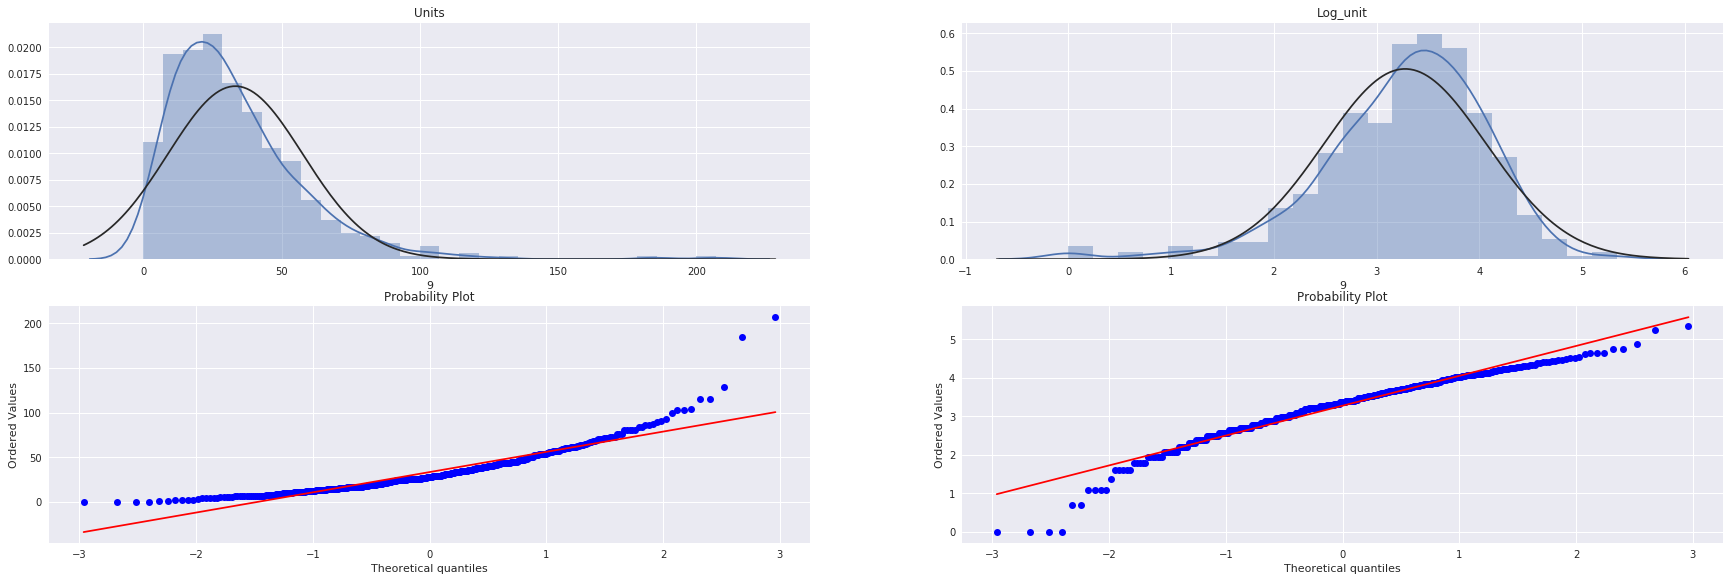

Unit - test statistic: 0.9766720799903479, p-value: 0.0
Log Unit - test statistic: 0.9282494129181219, p-value: 0.0
Unit - Skewness: 2.087893
Unit - Kurtosis: 8.870343
Log Unit - Skewness: -0.976611
Log Unit - Kurtosis: 2.201097


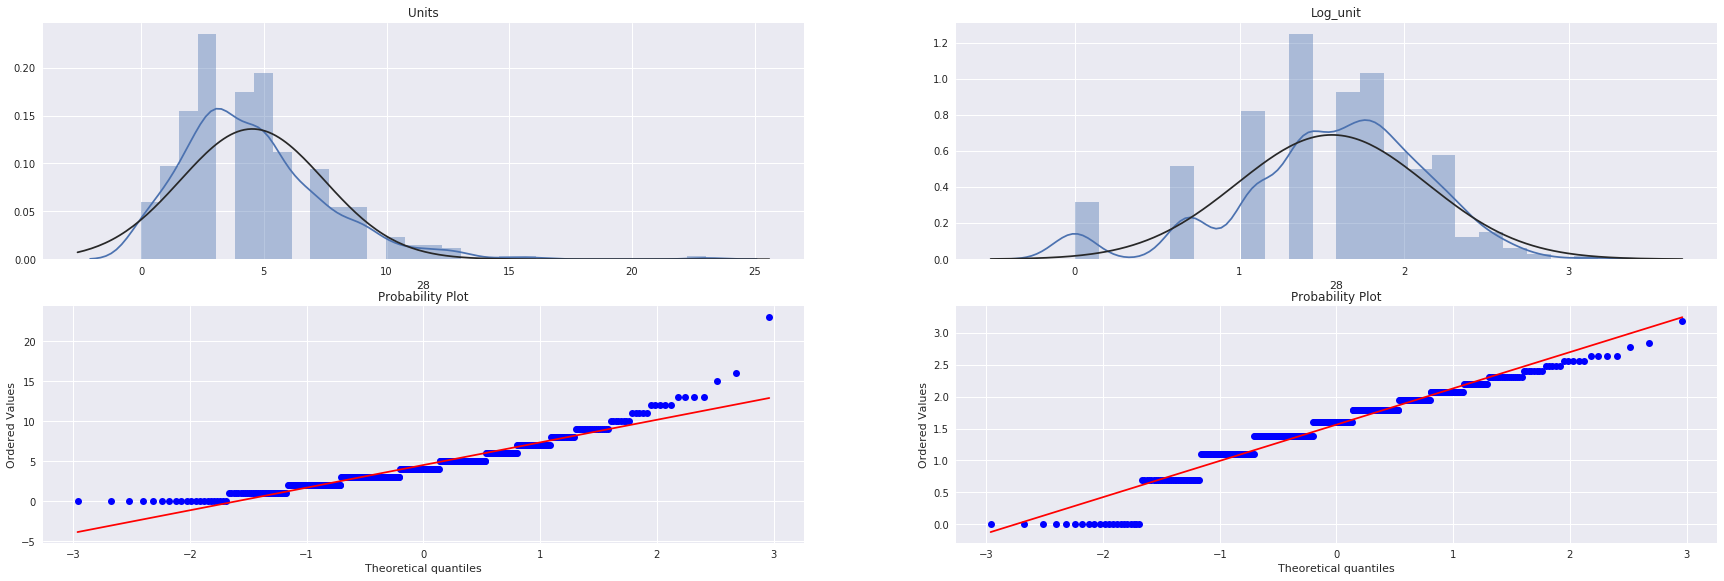

Unit - test statistic: 0.8563707471726999, p-value: 0.0
Log Unit - test statistic: 0.7431522714794547, p-value: 0.0
Unit - Skewness: 1.278333
Unit - Kurtosis: 3.772476
Log Unit - Skewness: -0.691252
Log Unit - Kurtosis: 0.702722


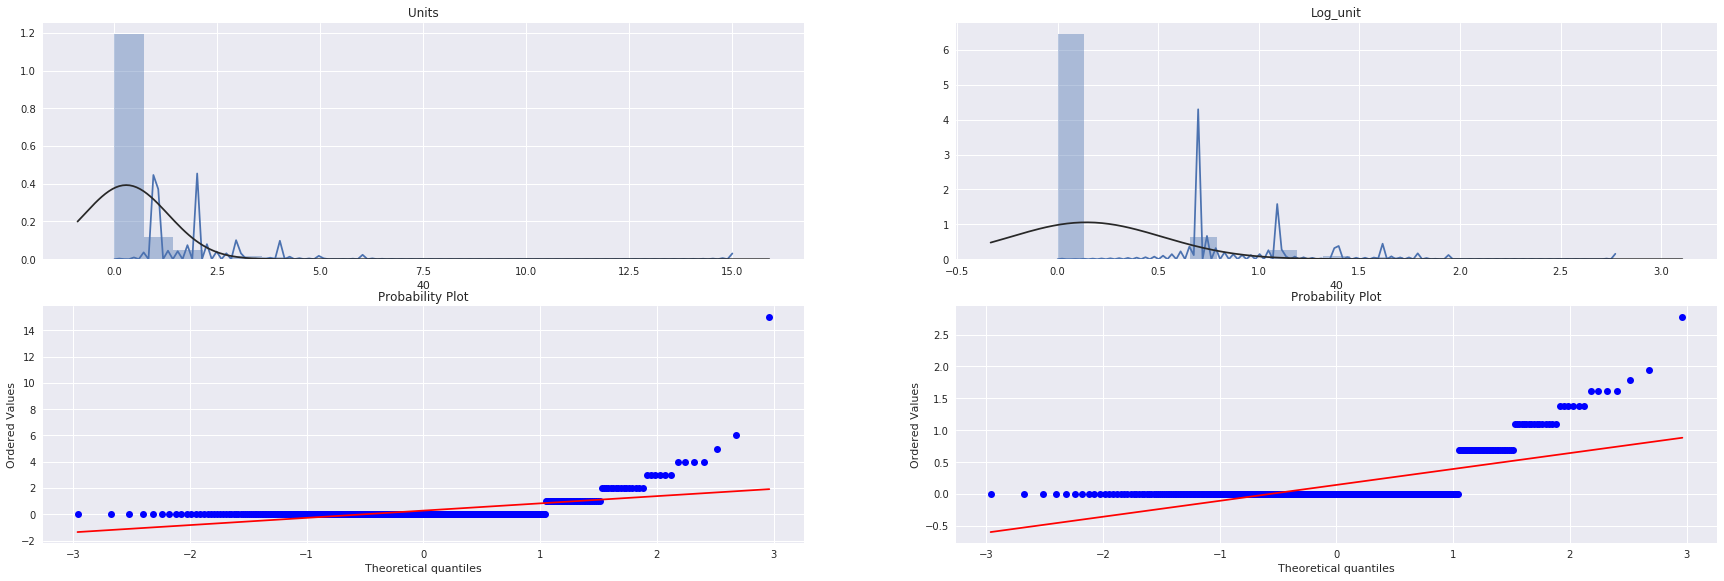

Unit - test statistic: 0.5, p-value: 0.0
Log Unit - test statistic: 0.5, p-value: 0.0
Unit - Skewness: 8.195055
Unit - Kurtosis: 100.935579
Log Unit - Skewness: 2.944335
Log Unit - Kurtosis: 9.633112


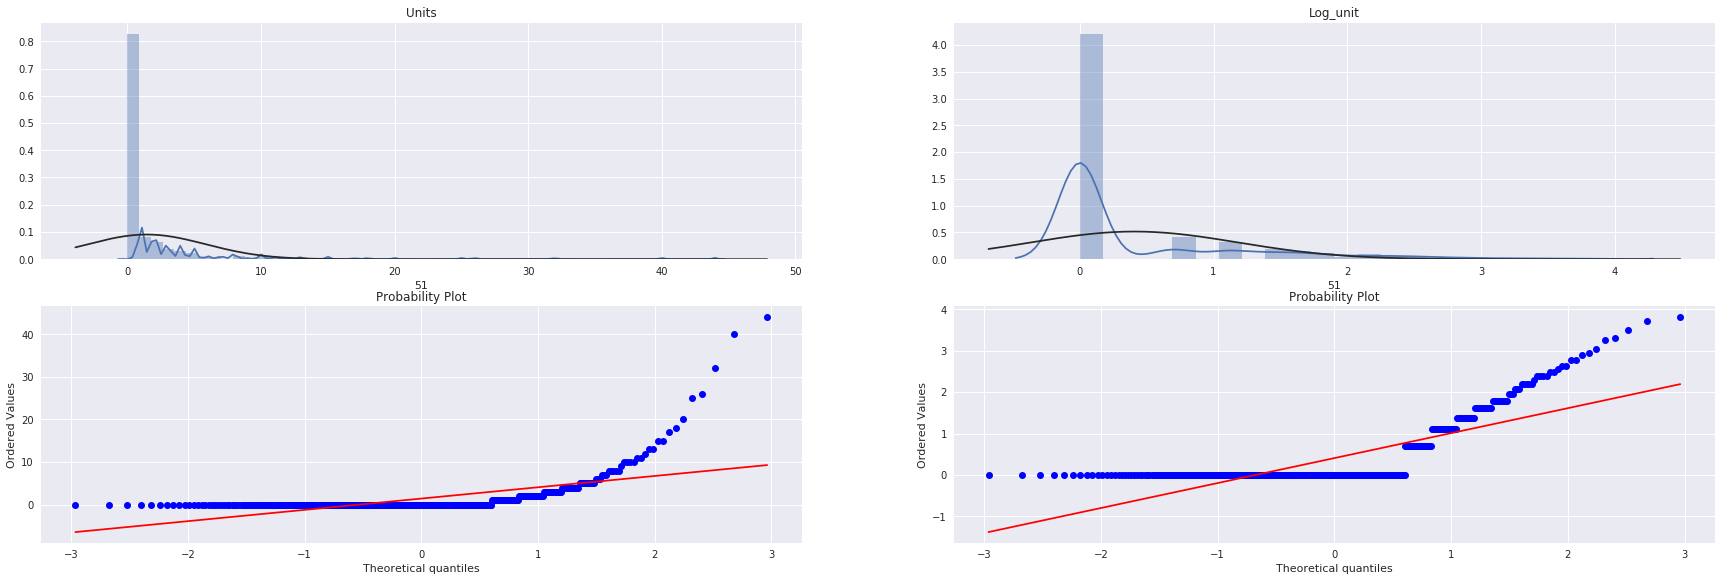

Unit - test statistic: 0.5, p-value: 0.0
Log Unit - test statistic: 0.5, p-value: 0.0
Unit - Skewness: 5.702487
Unit - Kurtosis: 40.949874
Log Unit - Skewness: 1.984351
Log Unit - Kurtosis: 3.401054


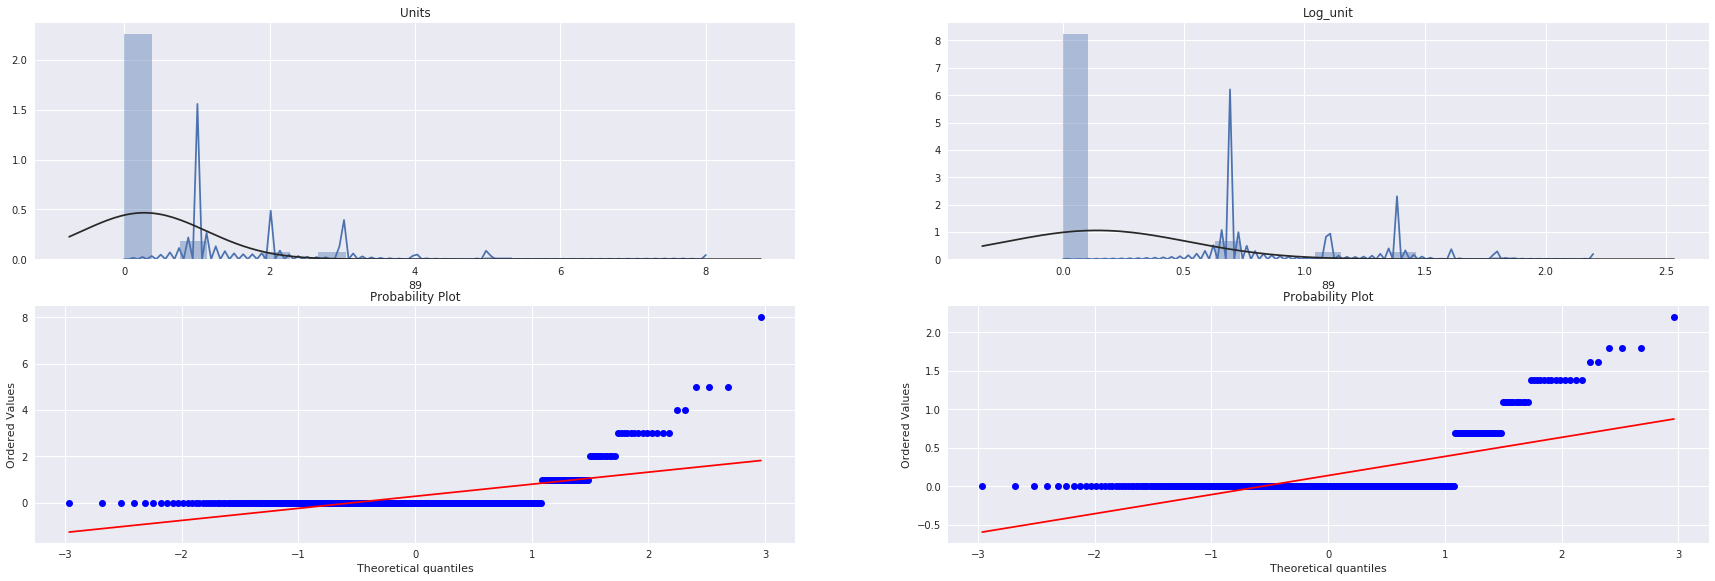

Unit - test statistic: 0.5, p-value: 0.0
Log Unit - test statistic: 0.5, p-value: 0.0
Unit - Skewness: 4.250969
Unit - Kurtosis: 22.960395
Log Unit - Skewness: 2.767661
Log Unit - Kurtosis: 7.073234


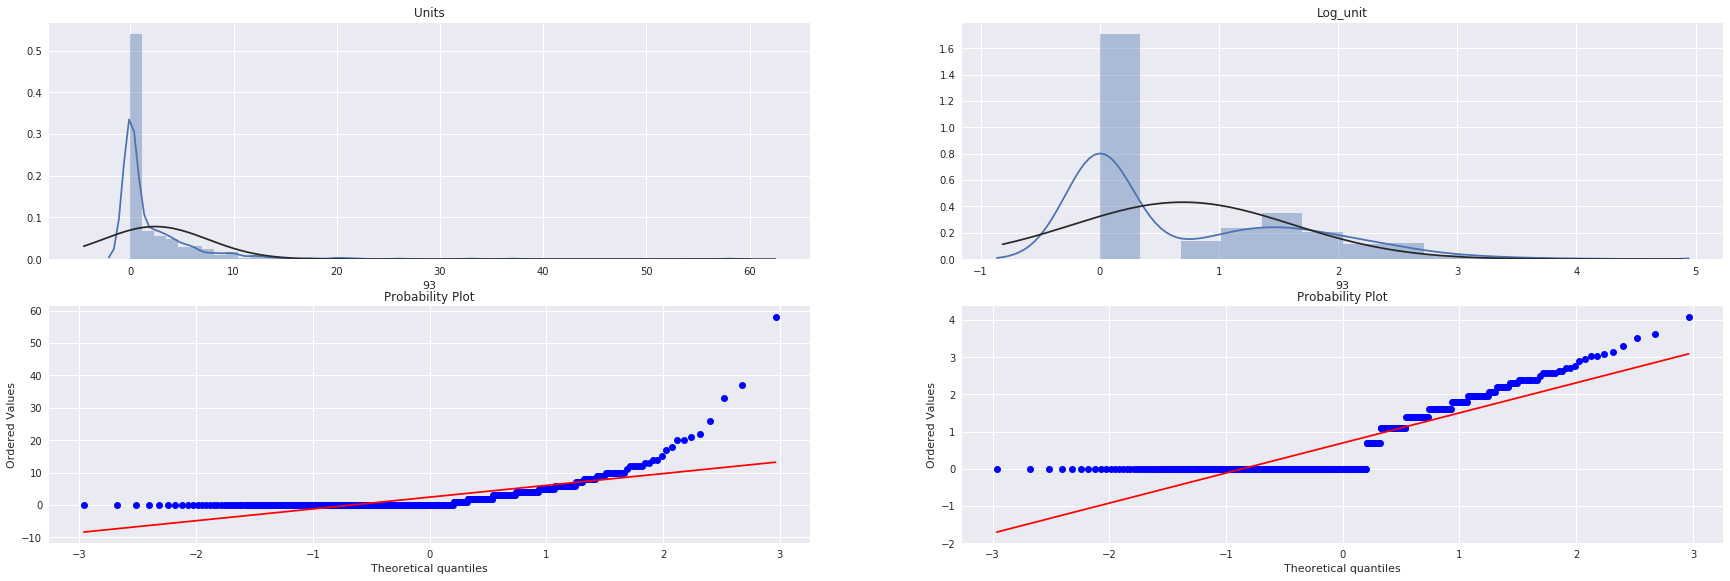

Unit - test statistic: 0.5, p-value: 0.0
Log Unit - test statistic: 0.5, p-value: 0.0
Unit - Skewness: 5.042979
Unit - Kurtosis: 39.388447
Log Unit - Skewness: 1.004291
Log Unit - Kurtosis: -0.076858


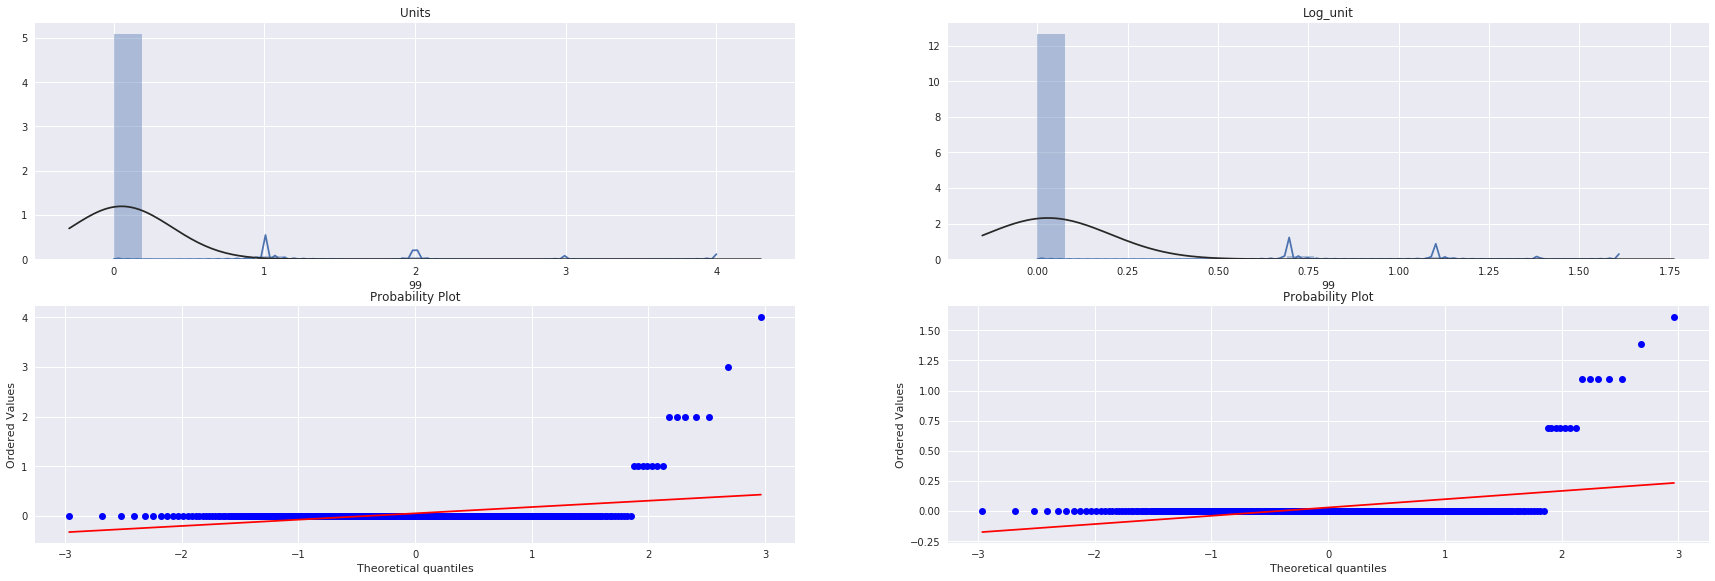

Unit - test statistic: 0.5, p-value: 0.0
Log Unit - test statistic: 0.5, p-value: 0.0
Unit - Skewness: 7.693384
Unit - Kurtosis: 67.710648
Log Unit - Skewness: 6.283348
Log Unit - Kurtosis: 41.083234


In [12]:
# Let's draw per item_nbr per store_nbr * with units
for i in range(1,2):  #원래는 1~45
    temp = []
    temp2 = []
    t = []
    temp = train_norm_test.loc[i]
    temp2 = train_norm_test_log.loc[i]
    temp = temp.loc[:, (temp !=0).any(axis=0)]
    temp2 = temp2.loc[:, (temp2 !=0).any(axis=0)]
    t = list(temp.columns)
    for j in t:
        plt.figure(figsize = (30, 20))
        plt.subplot(4,2,1)
        sns.distplot(temp[j], kde=True, fit=scipy.stats.norm)
        plt.title('Units')
        plt.subplot(4,2,2)
        sns.distplot(temp2[j], kde=True, fit=scipy.stats.norm)
        plt.title('Log_unit')
        plt.subplot(4,2,3)
        scipy.stats.probplot(temp[j], dist="norm", plot=pylab)
        plt.subplot(4,2,4)
        scipy.stats.probplot(temp2[j], dist="norm", plot=pylab)
        pylab.show()
        result_ks = scipy.stats.kstest(temp[j], cdf='norm')
        result_ks_log = scipy.stats.kstest(temp2[j], cdf='norm')
        print('Unit - test statistic: {}, p-value: {}'.format(result_ks[0], result_ks[1]))
        print('Log Unit - test statistic: {}, p-value: {}'.format(result_ks_log[0], result_ks_log[1]))
        print("Unit - Skewness: %f" % temp[j].skew())
        print("Unit - Kurtosis: %f" % temp[j].kurt())
        print("Log Unit - Skewness: %f" % temp2[j].skew())
        print("Log Unit - Kurtosis: %f" % temp2[j].kurt())
    # It seems like improving the normality!

로그를 취하지 않은 종속변수 y값은 

로그를 취한 유닛으로 시간별 판매량을 플롯함으로써 추세, 계절성이 있는지 알아보자

여기에서 UCL은 평균값에 2 Sigma를 더한값이라 하고, 범위안에 속하지 못하는 데이터는 odd하다고 가정한다. (95.45%) 

/home/yjoung90/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/yjoung90/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


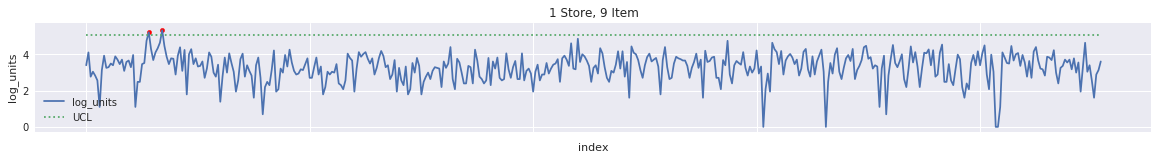

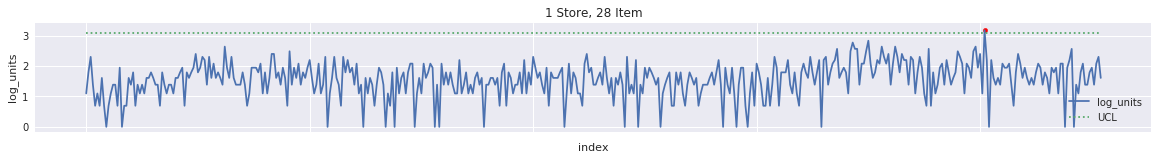

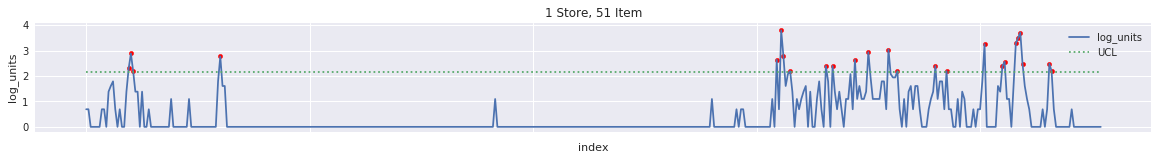

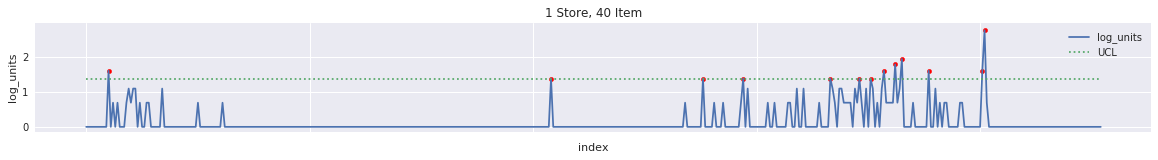

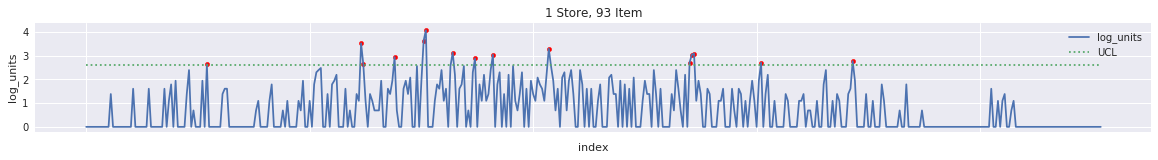

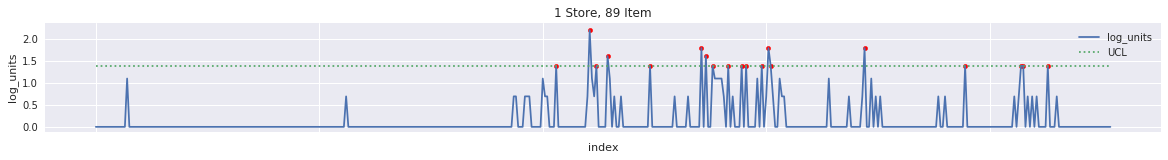

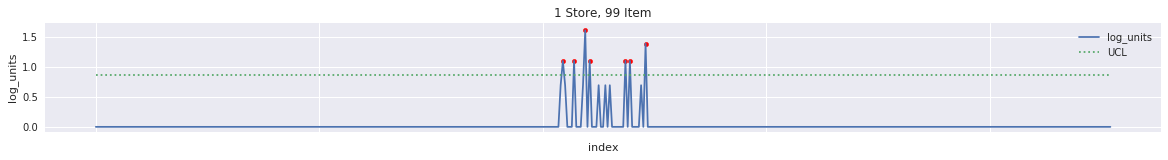

In [13]:
for i in range(1, 2): #원래는 1~45
    tmp = []
    tmp = train_df[train_df['store_nbr'] == i]
    tmp_sold = tmp[tmp['units'] > 0]
    tmp = pd.concat([tmp[tmp['item_nbr'] == num] for num in tmp_sold['item_nbr'].unique()])
    for j in tmp['item_nbr'].unique():
        tmp_item = []
        tmp_item = tmp[tmp['item_nbr'] == j]
        tmp_item['index'] = [k for k in range(len(tmp_item))]
        mean = tmp_item['log_units'].mean()
        std = tmp_item['log_units'].std()
        sig = np.sqrt(std)
        UCL = (sig*2) + mean # 2sigma 95.45%
        tmp_item['UCL'] = UCL
        tmp_item_odd = tmp_item[tmp_item['log_units'] > UCL]
        ax = tmp_item.plot(x='date', y='log_units', kind='line', figsize=(20,2), title=('{} Store, {} Item'.format(i, j)))
        tmp_item.plot(x='date', y='UCL', kind='line', style=':', ax=ax)
        if len(tmp_item_odd) != 0:
            tmp_item_odd.plot(x='index', y='log_units', kind='scatter', color='r', ax=ax)
#          plt.title('{} Store, {} Item'.format(i, j))
        plt.show()

이 oddity는 어디서 나온 것일까? 요일별로 판매량이 다른지 알아보자

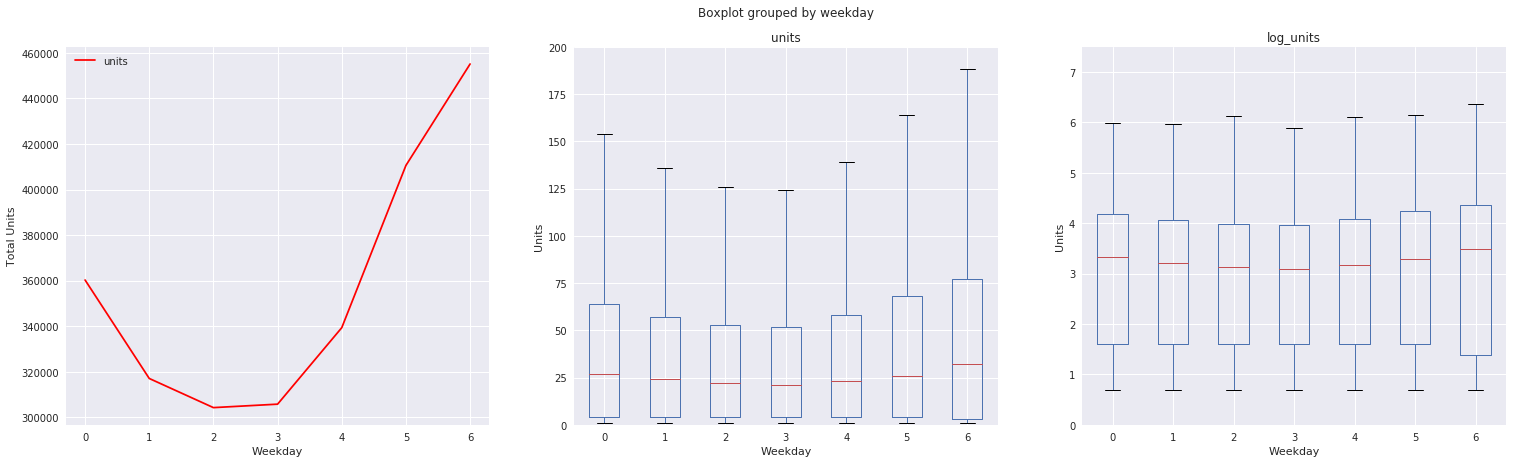

In [14]:
processed_train_f1 = processed_train.pivot_table(values='units', index=['weekday'], aggfunc=np.sum)
processed_train_f2 = processed_train[processed_train['units'] > 0].reset_index(drop=True)
processed_train_f3 = processed_train[processed_train['log_units'] > 0].reset_index(drop=True)


fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (25, 7))
# unit vs weekday
processed_train_f1.plot(kind='line', style='r', ax=axes[0])
# axes[1].set_ylim([0,200])
plt.xticks(rotation=0)
axes[0].set_ylabel('Total Units')
axes[0].set_xlabel('Weekday')
processed_train_f2.boxplot("units", "weekday", ax=axes[1])
axes[1].set_ylim([0,200])
plt.xticks(rotation=0)
axes[1].set_ylabel('Units')
axes[1].set_xlabel('Weekday')
processed_train_f3.boxplot("log_units", "weekday", ax=axes[2])
axes[2].set_ylim([0,7.5])
plt.xticks(rotation=0)
axes[2].set_ylabel('Units')
axes[2].set_xlabel('Weekday')
plt.show()

유닛의 총량으로 보았을때는 차이가 분명히 나타나지만 boxplot으로 보았을때 커다란 차이점을 보기는 힘들다. (특히 유닛에 로그를 취했을 경우)

In [15]:
processed_train = preprocessing(train_df, holiday, weather_df)
processed_train['date'] = processed_train['date'].apply(lambda x:x.date().strftime('%Y-%m-%d'))

/home/yjoung90/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/yjoung90/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Satday: 1
Sunday: 1


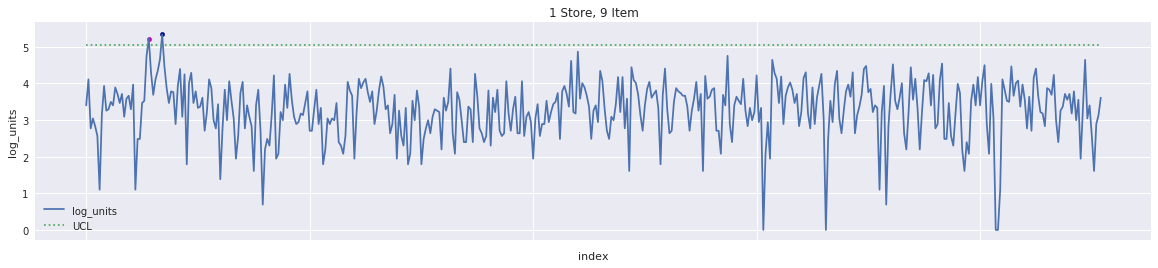

Thurday: 1


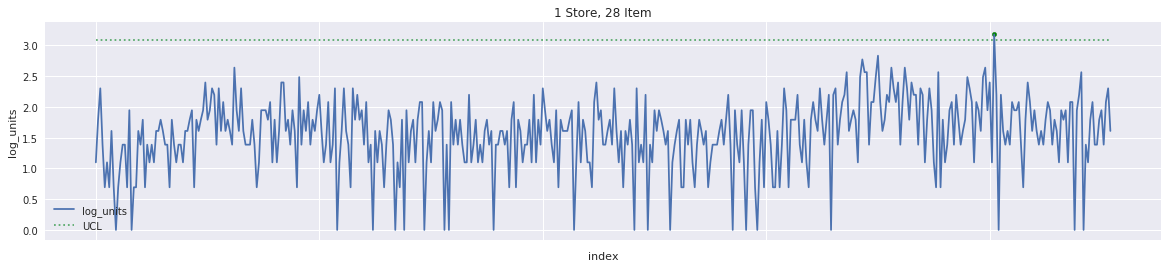

Monday: 3
Tuesday: 1
Wednsday: 3
Thurday: 4
Friday: 5
Satday: 4
Sunday: 5


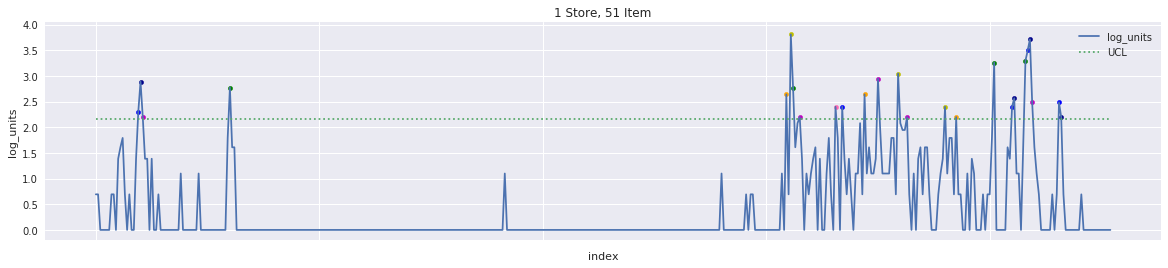

Monday: 1
Tuesday: 1
Wednsday: 4
Thurday: 2
Friday: 1
Satday: 1
Sunday: 3


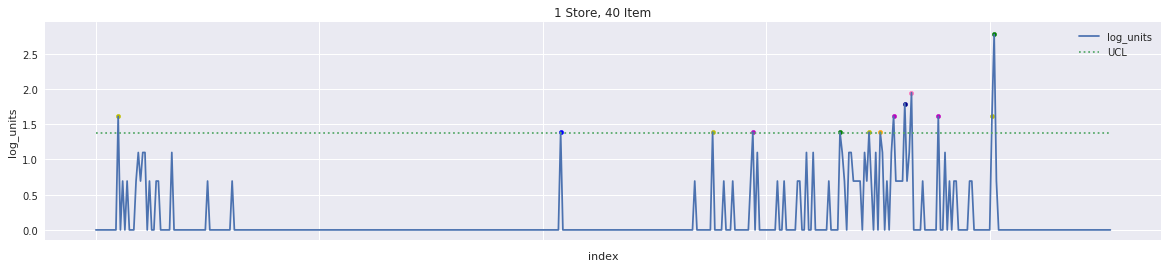

Monday: 1
Wednsday: 1
Thurday: 4
Friday: 5
Satday: 2
Sunday: 2


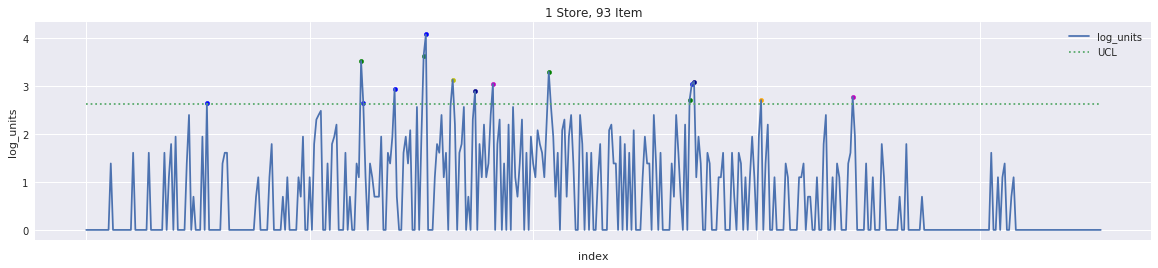

Monday: 2
Tuesday: 2
Wednsday: 5
Thurday: 3
Friday: 3
Sunday: 4


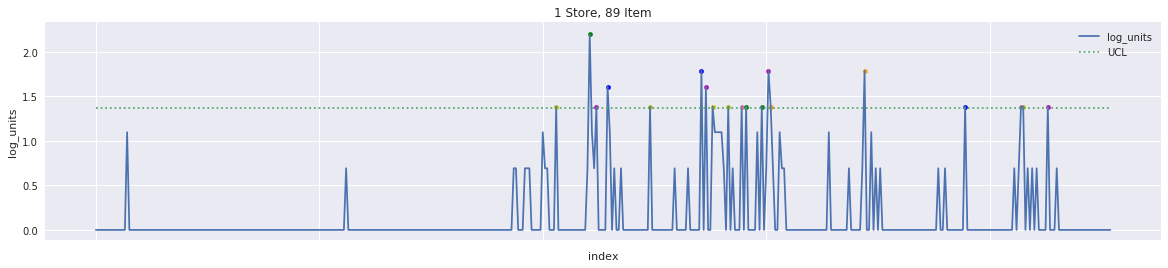

Monday: 2
Tuesday: 1
Thurday: 2
Satday: 2


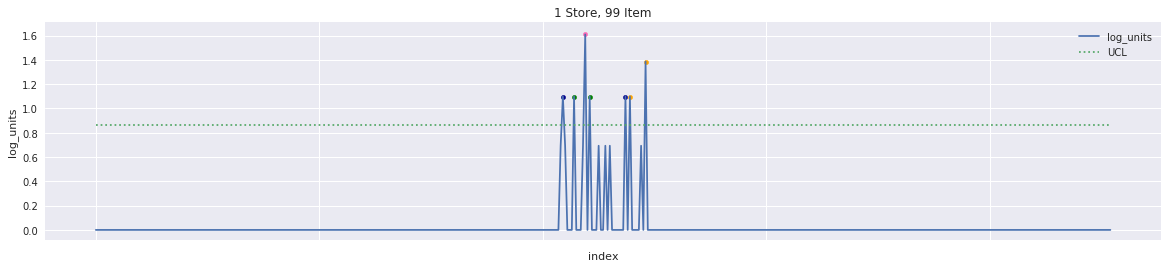

In [16]:
for i in range(1, 2):  #원래는 1~45
    tmp = []
    tmp_sold = []
    tmp = processed_train[processed_train['store_nbr'] == i]
    tmp_sold = tmp[tmp['log_units'] > 0]
    tmp = pd.concat([tmp[tmp['item_nbr'] == num] for num in tmp_sold['item_nbr'].unique()])
    for j in tmp['item_nbr'].unique():
        tmp_item = []
        tmp_item_odd = []
        tmp_item_mon = []
        tmp_item_tue = []
        tmp_item_wed = []
        tmp_item_thu = []
        tmp_item_fri = []
        tmp_item_sat = []
        tmp_item_sun = []
        tmp_item = tmp[tmp['item_nbr'] == j]
        tmp_item['index'] = [k for k in range(len(tmp_item))]
        mean = tmp_item['log_units'].mean()
        std = tmp_item['log_units'].std()
        sig = np.sqrt(std)
        UCL = (sig*2) + mean # 2sigma 95.45%
        tmp_item['UCL'] = UCL
        tmp_item_odd = tmp_item[tmp_item['log_units'] > UCL]
        tmp_item_mon = tmp_item_odd[tmp_item_odd['weekday'] == 0]
        tmp_item_tue = tmp_item_odd[tmp_item_odd['weekday'] == 1]
        tmp_item_wed = tmp_item_odd[tmp_item_odd['weekday'] == 2]
        tmp_item_thu = tmp_item_odd[tmp_item_odd['weekday'] == 3]
        tmp_item_fri = tmp_item_odd[tmp_item_odd['weekday'] == 4]
        tmp_item_sat = tmp_item_odd[tmp_item_odd['weekday'] == 5]
        tmp_item_sun = tmp_item_odd[tmp_item_odd['weekday'] == 6]
        ax = tmp_item.plot(x='date', y='log_units', kind='line', figsize=(20,4), title=('{} Store, {} Item'.format(i, j)))
        tmp_item.plot(x='date', y='UCL', kind='line', style=':', ax=ax)
        if len(tmp_item_odd) != 0:
            tmp_item_odd.plot(x='index', y='log_units', kind='scatter', color='r', alpha='0.0', ax=ax)
            if len(tmp_item_mon) != 0:
                tmp_item_mon.plot(x='index', y='log_units', kind='scatter', color='#FFA500', ax=ax) # orange
                print('Monday: {}'.format(len(tmp_item_mon)))

            if len(tmp_item_tue) != 0:
                tmp_item_tue.plot(x='index', y='log_units', kind='scatter', color='#FF69B4', ax=ax) # pink
                print('Tuesday: {}'.format(len(tmp_item_tue)))

            if len(tmp_item_wed) !=0:
                tmp_item_wed.plot(x='index', y='log_units', kind='scatter', color='y', ax=ax)
                print('Wednsday: {}'.format(len(tmp_item_wed)))

            if len(tmp_item_thu) != 0:
                tmp_item_thu.plot(x='index', y='log_units', kind='scatter', color='g', ax=ax)
                print('Thurday: {}'.format(len(tmp_item_thu)))

            if len(tmp_item_fri) != 0:
                tmp_item_fri.plot(x='index', y='log_units', kind='scatter', color='b', ax=ax)
                print('Friday: {}'.format(len(tmp_item_fri)))

            if len(tmp_item_sat) != 0:
                tmp_item_sat.plot(x='index', y='log_units', kind='scatter', color='#00008B', ax=ax) # darkblue
                print('Satday: {}'.format(len(tmp_item_sat)))

            if len(tmp_item_sun) != 0:    
                tmp_item_sun.plot(x='index', y='log_units', kind='scatter', color='m', ax=ax)            
                print('Sunday: {}'.format(len(tmp_item_sun)))
                           
            plt.show()
        plt.show()

공휴일이 미치는 영향도 알아보자

In [17]:
train_df_holiday = train_df[train_df['holiday'] == True].reset_index(drop = True)
train_df_nonholiday = train_df[train_df['holiday'] == False].reset_index(drop = True)

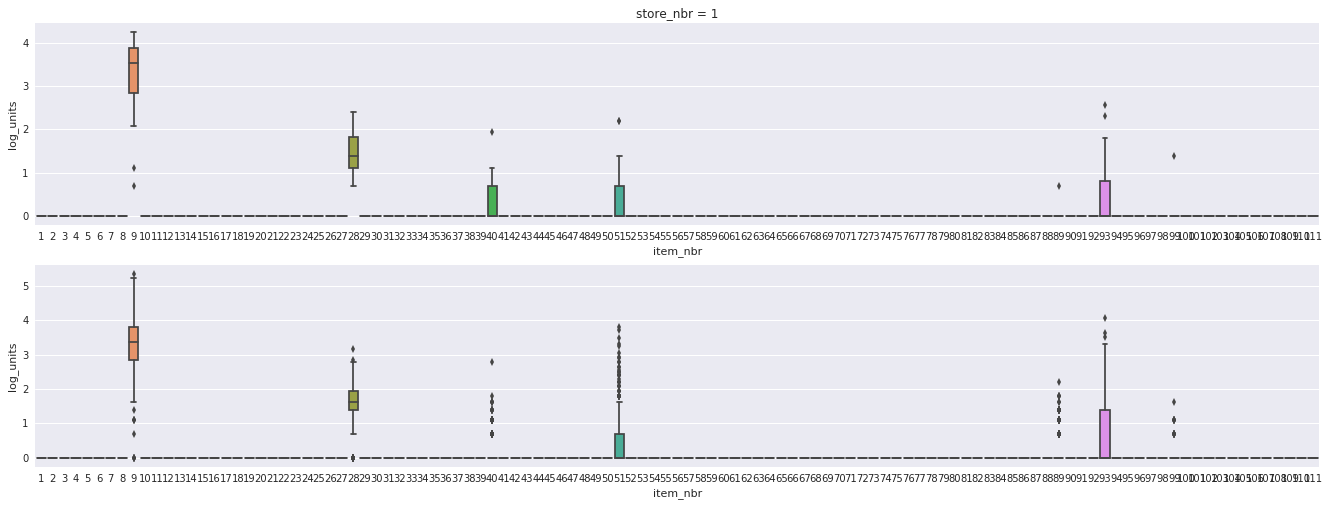

In [18]:
for i in range(1, 2) : # 1 ~ 45
    plt.subplots(figsize = (23, 400))
    plt.subplot(90, 1, i)
    sns.boxplot(x = 'item_nbr', y = 'log_units', data = by_store(train_df_holiday, i))
        
    plt.title('store_nbr = {}'.format(i))
    
    plt.subplot(90, 1, i + 1)
    sns.boxplot(x = 'item_nbr', y = 'log_units', data = by_store(train_df_nonholiday, i))
    
plt.show()

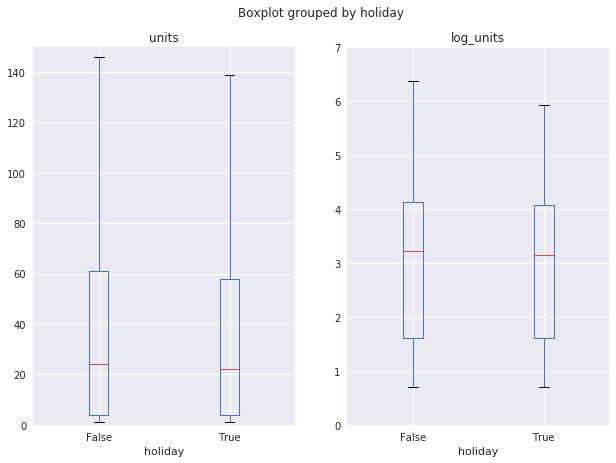

In [19]:
processed_train_f4 = processed_train[processed_train['units'] > 0]
processed_train_f5 = processed_train[processed_train['log_units'] > 0]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (10, 7))
processed_train_f4.boxplot("units", "holiday", ax=axes[0])
axes[0].set_ylim([0,150])
processed_train_f5.boxplot("log_units", "holiday", ax=axes[1])
axes[1].set_ylim([0,7])
plt.show()

그렇다면 이 odd한 날이 weather의 영향을 받은 날일까? 

문제에서 preciptotal이 1이상 snowfall이 2이상인날을 weather event, 즉 stormy weather한 날이라고 정의하였다. 

이 날짜에 맞춰 event가 발생하였다고 가정한다.

In [20]:
event_pivot_station_train = processed_train.pivot_table(values='event', index='date', columns='station_nbr')
event_pivot_station_test = processed_test.pivot_table(values='event', index='date', columns='station_nbr')
event_pivot_store_train = processed_train.pivot_table(values='event', index='date', columns='store_nbr')
event_pivot_store_test = processed_test.pivot_table(values='event', index='date', columns='store_nbr')
event_pivot_station_train = pd.DataFrame(event_pivot_station_train.to_records())
event_pivot_station_test = pd.DataFrame(event_pivot_station_test.to_records())
event_pivot_store_train = pd.DataFrame(event_pivot_store_train.to_records())
event_pivot_store_test = pd.DataFrame(event_pivot_store_test.to_records())

위에서 플롯한 추세, 계절성 플롯에서 odd한 값들이 event에 영향을 받은것인지 알아보기 위해 같은 플롯을 그려보자

event는 초록색 odd는 빨간색 둘이 겹치는 부분은 두색의 합으로 나타난다.

/home/yjoung90/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/yjoung90/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


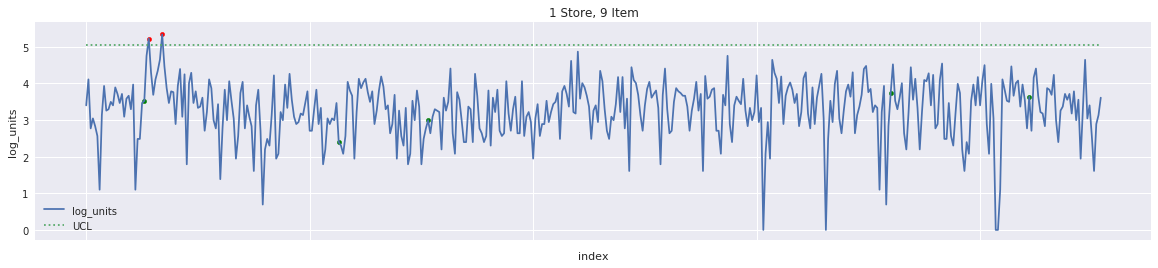

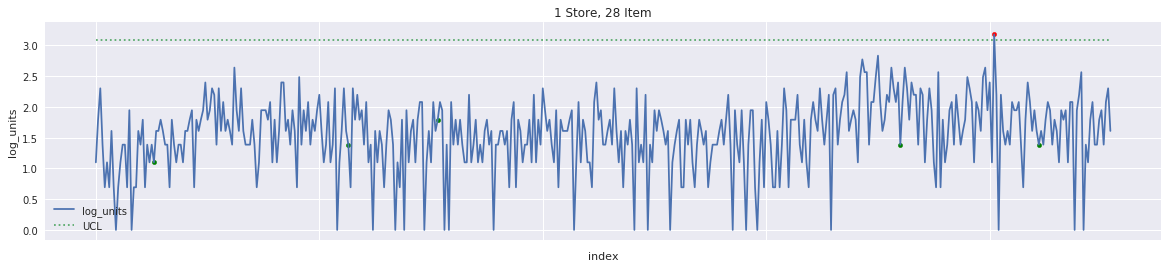

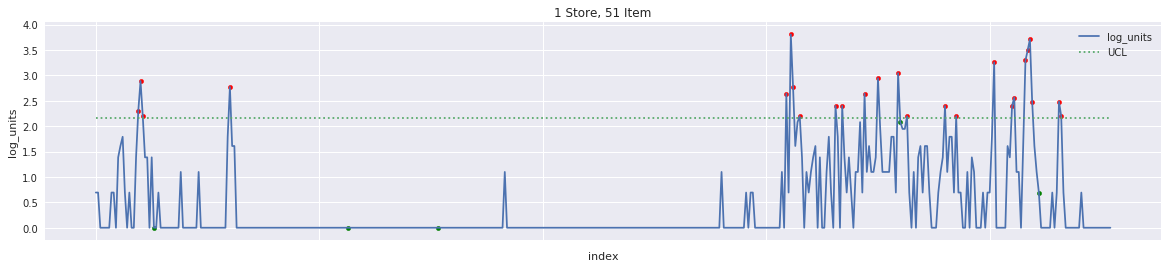

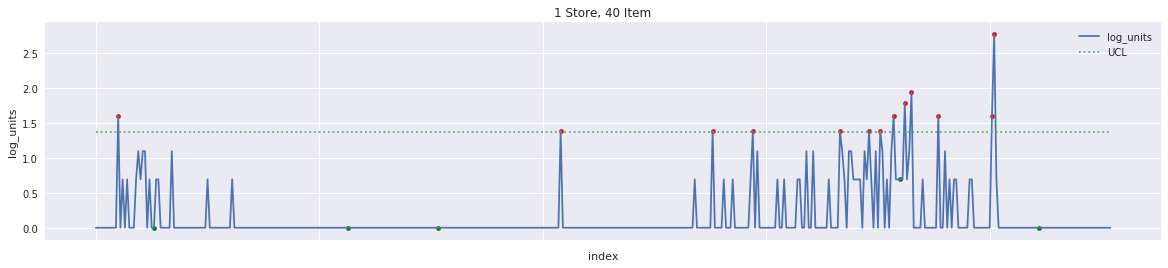

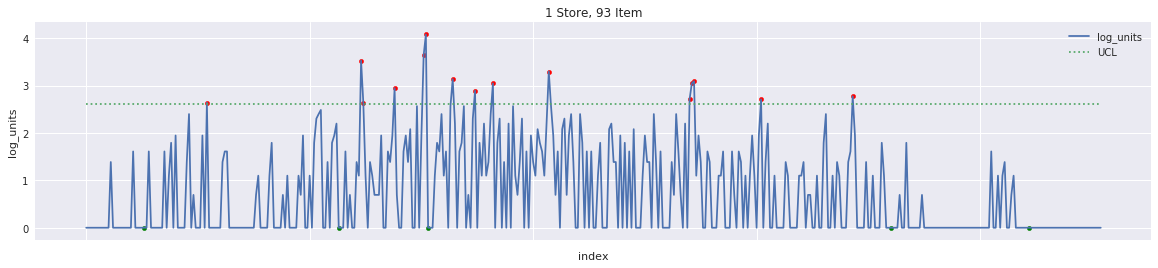

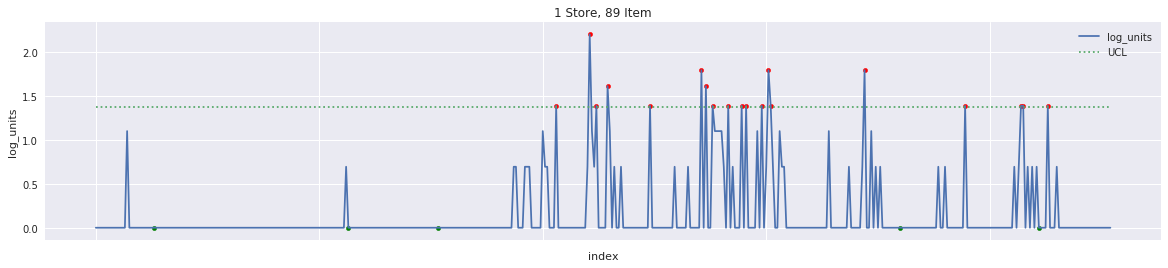

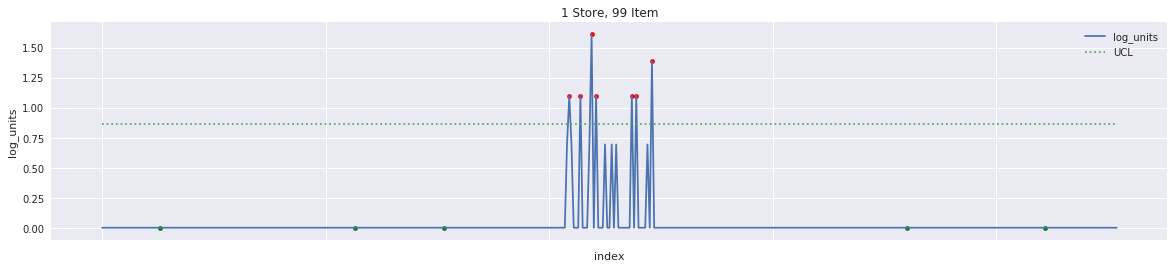

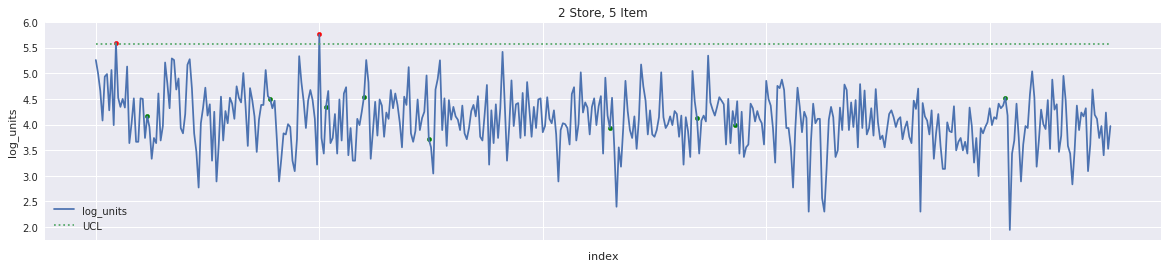

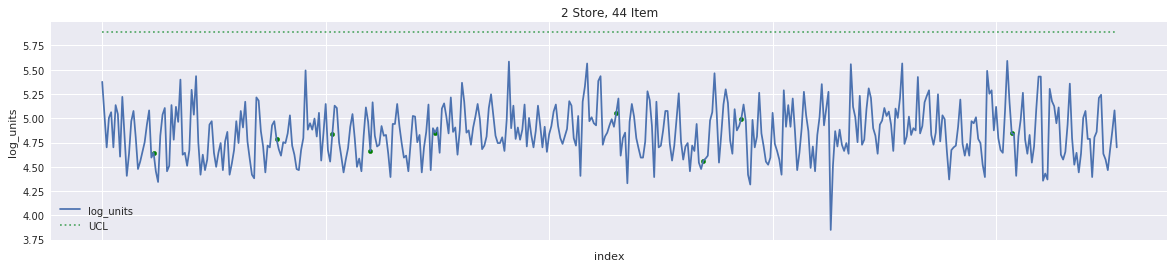

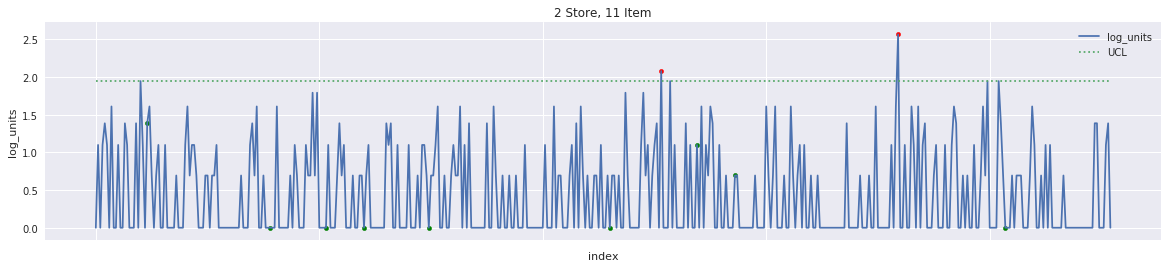

Warning! : 85221     2012-03-19
177573    2012-10-13
Name: date, dtype: object, Match: 2


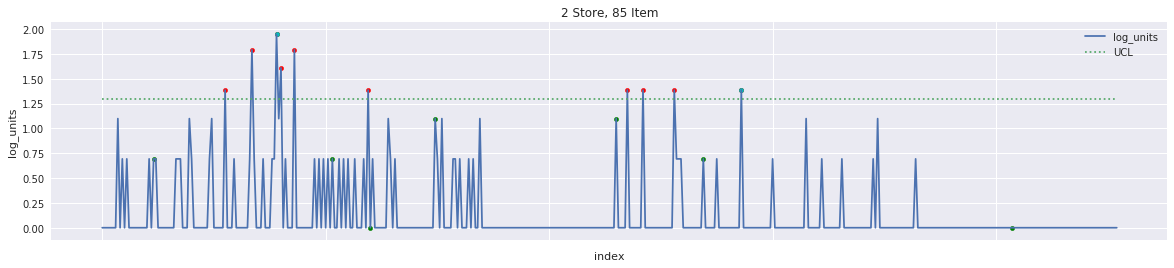

Warning! : 152717    2012-08-18
Name: date, dtype: object, Match: 1


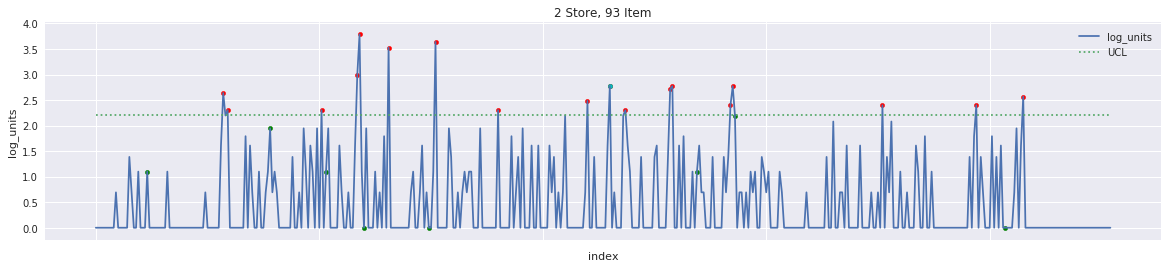

In [21]:
for i in range(1, 3): #원래는 1~45
    tmp = []
    tmp_item_flag = []
    tmp = processed_train[processed_train['store_nbr'] == i]
    tmp_sold = tmp[tmp['log_units'] > 0]
    tmp = pd.concat([tmp[tmp['item_nbr'] == num] for num in tmp_sold['item_nbr'].unique()])
    for j in tmp['item_nbr'].unique():
        tmp_item = tmp[tmp['item_nbr'] == j]
        tmp_item['index'] = [k for k in range(len(tmp_item))]
        mean = tmp_item['log_units'].mean()
        std = tmp_item['log_units'].std()
        sig = np.sqrt(std)
        UCL = (sig*2) + mean # 2sigma 95.45%
        tmp_item['UCL'] = UCL
        tmp_item_odd = tmp_item[tmp_item['log_units'] > UCL]
        tmp_item_event = tmp_item[tmp_item['event'] > 0]
        tmp_item_flag = tmp_item_event[tmp_item_event['log_units'] > UCL]
        ax = tmp_item.plot(x='date', y='log_units', kind='line', figsize=(20,4), title=('{} Store, {} Item'.format(i, j)))
        tmp_item.plot(x='date', y='UCL', kind='line', style=':', ax=ax)
        if len(tmp_item_odd) != 0:
            tmp_item_event.plot(x='index', y='log_units', kind='scatter', color='g', ax=ax)
            tmp_item_odd.plot(x='index', y='log_units', kind='scatter', color='r', ax=ax)
            if len(tmp_item_flag) !=0:
                tmp_item_flag.plot(x='index', y='log_units', kind='scatter', color='c', ax=ax)
                print('Warning! : {}, Match: {}'.format(tmp_item_flag['date'], len(tmp_item_flag)))
        else:
            tmp_item_event.plot(x='index', y='log_units', kind='scatter', color='g', ax=ax)
        plt.show()

event와 odd가 겹쳐질때 warning을 주도록 하였는데 겹치는 경우가 희소하다. 

그렇다면 다른 weather정보가 unit에 영향을 미치는지 알아보도록 하자

In [22]:
weather_tmp = weather[weather['date'] <= '2013-03-31'].reset_index(drop = True)

In [23]:
w_col_ls = list(weather_tmp.columns)
for col in w_col_ls:
    if col == 'date':
        weather_tmp[col] = weather_tmp[col]
    elif col == 'sunrise':
        weather_tmp[col] = weather_tmp[col]
    elif col == 'sunset':
        weather_tmp[col] = weather_tmp[col]
    elif col == 'codesum':
        weather_tmp[col] = weather_tmp[col]
    else:
        weather_tmp[col] = TM_transform(weather_tmp[col], 0.001, np.nan)

In [24]:
weather_tmp = weather_tmp.replace('M', np.nan)

In [25]:
weather_tmp.drop(['RA_flag', 'FZ_flag', 'FG_flag', 'BR_flag', 'normal_flag',
       'UP_flag', 'MI_flag', 'SN_flag', 'HZ_flag', 'TS_flag', 'VC_flag',
       'DZ_flag', 'BL_flag', 'BC_flag', 'DU_flag', 'SQ_flag', 'PL_flag',
       'FU_flag', 'GR_flag', 'GS_flag', 'SG_flag', 'PR_flag', 'snow_event',
       'rain_event'], axis = 1, inplace = True)

In [26]:
# weather_tmp['date'] = weather_tmp['date'].apply(lambda x:x.date().strftime('%Y-%m-%d'))
# weather_tmp = weather_tmp.dropna(how='any', axis=0)
# weather_tmp = weather_tmp.astype('float')
weather_tmp = weather_tmp.reset_index(drop=True)
weather_tmp['station_nbr'] = weather_tmp['station_nbr'].astype('int')

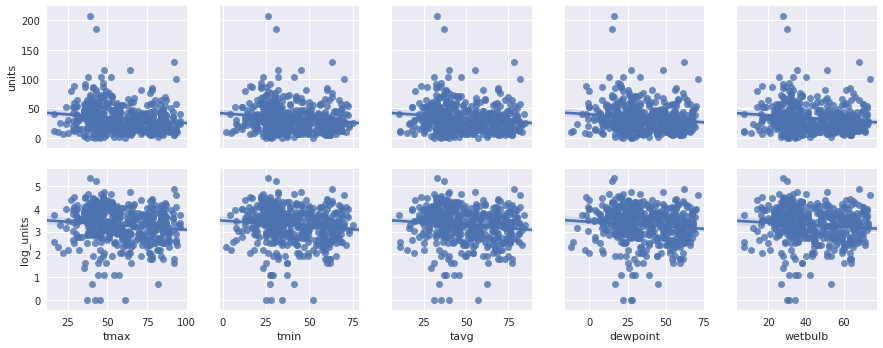

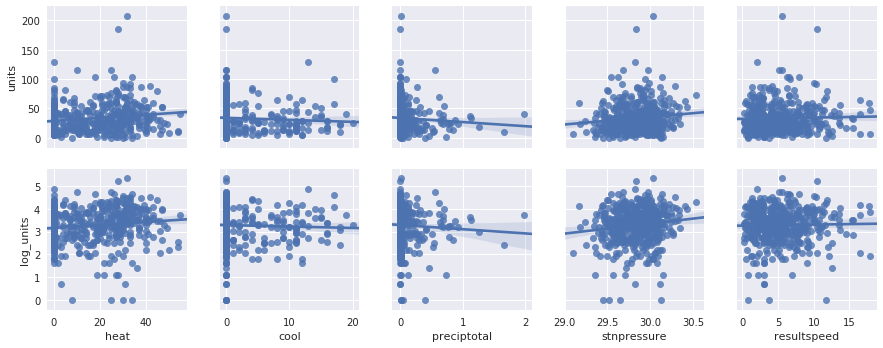

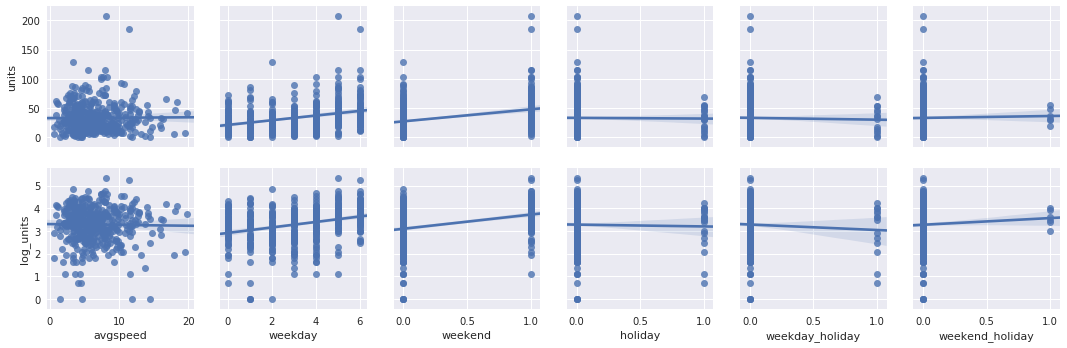

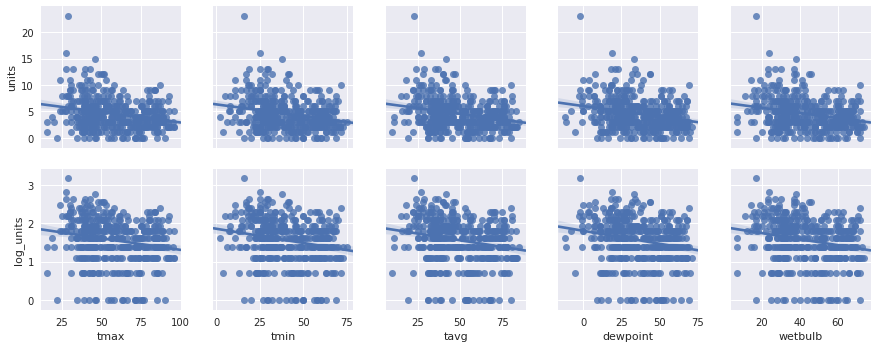

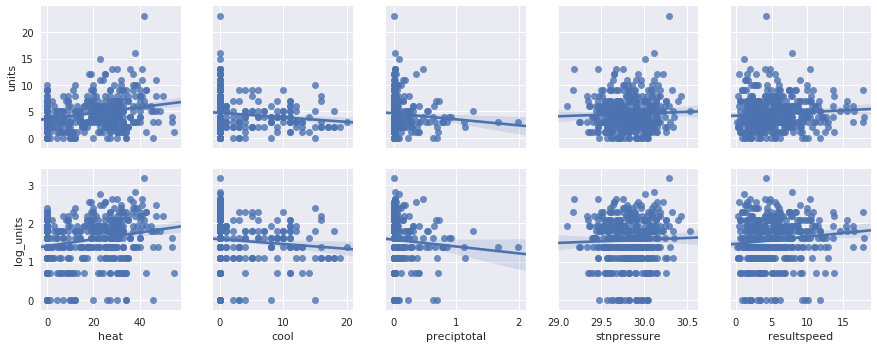

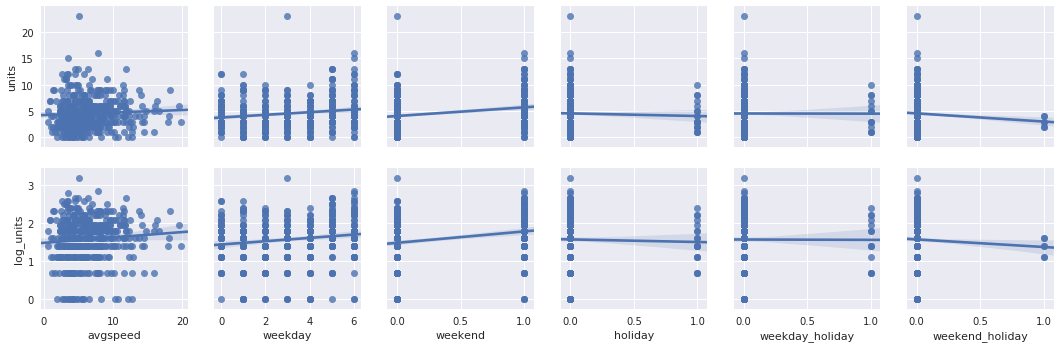

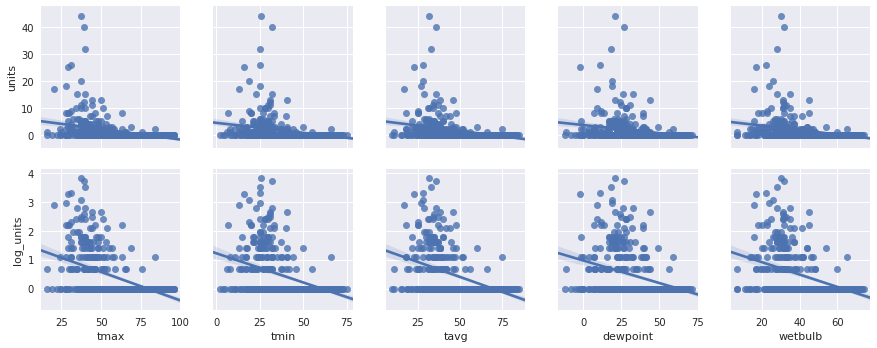

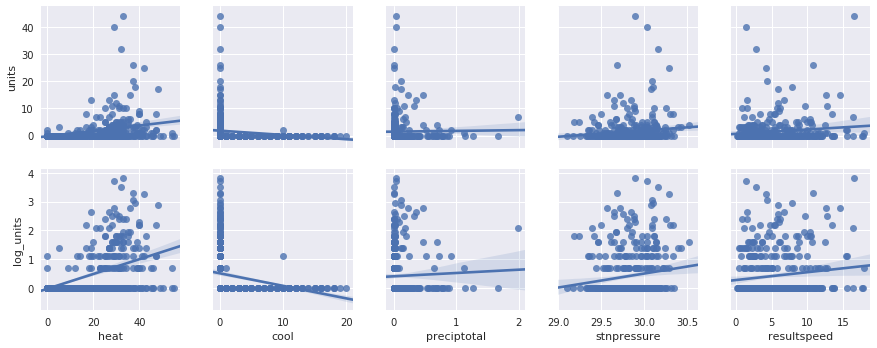

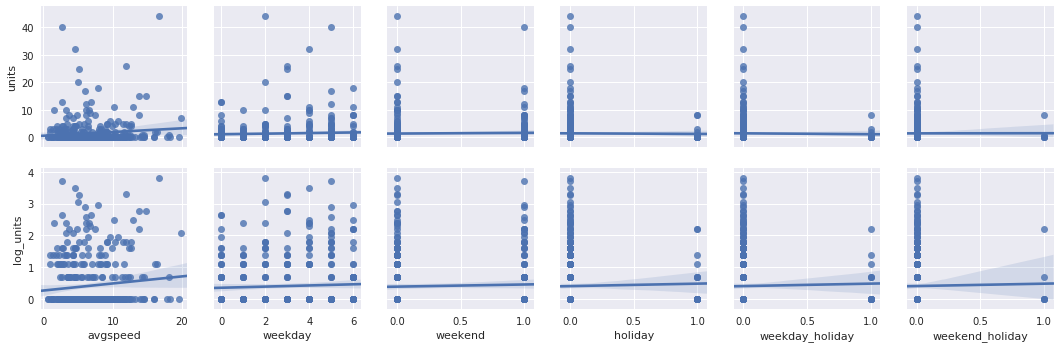

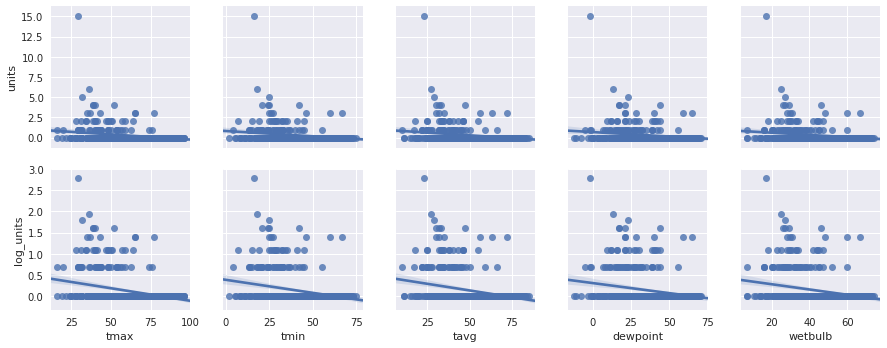

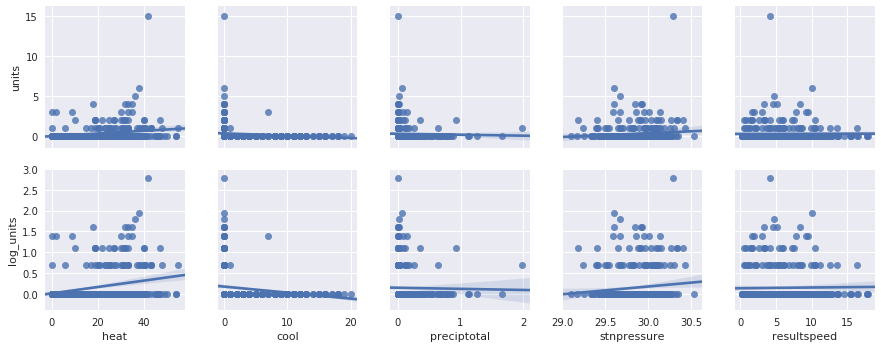

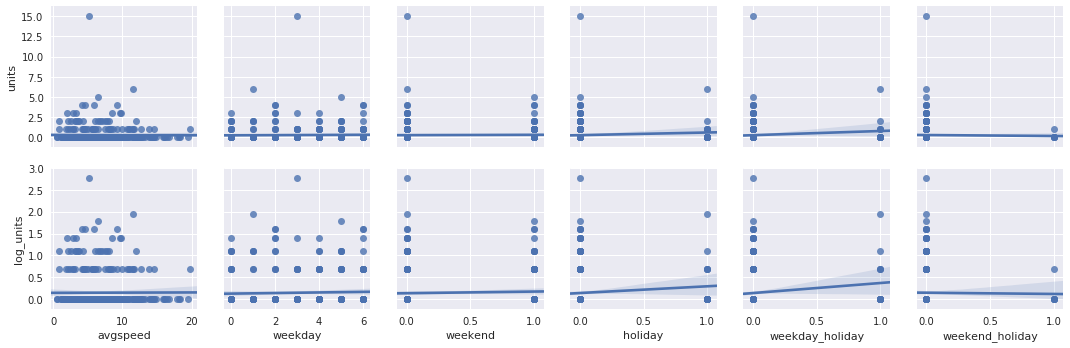

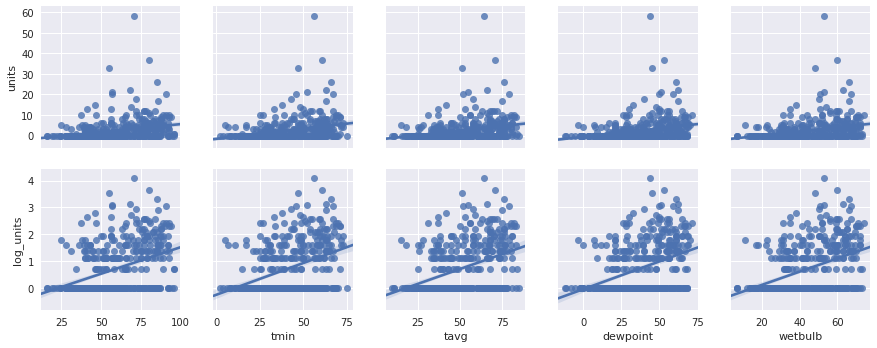

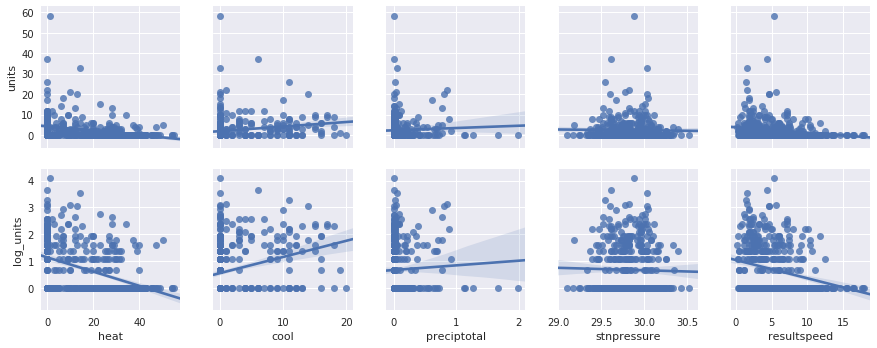

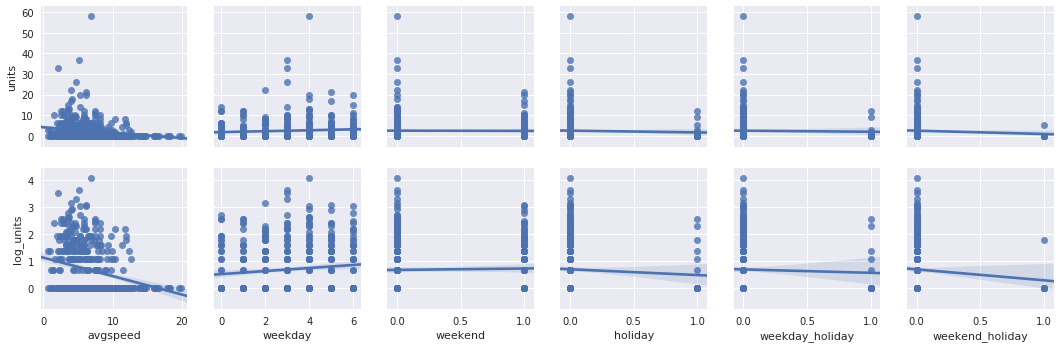

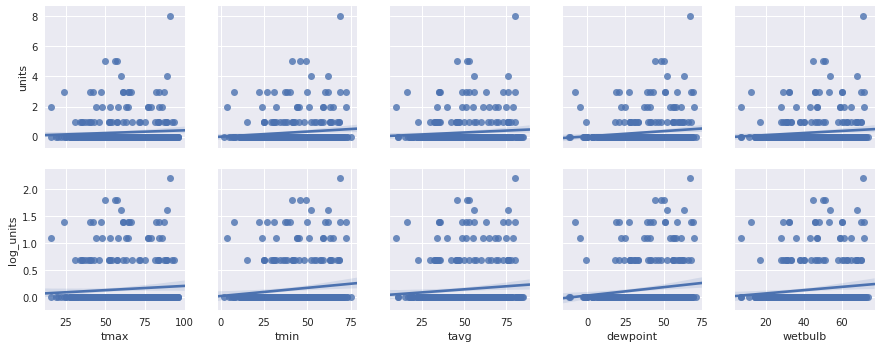

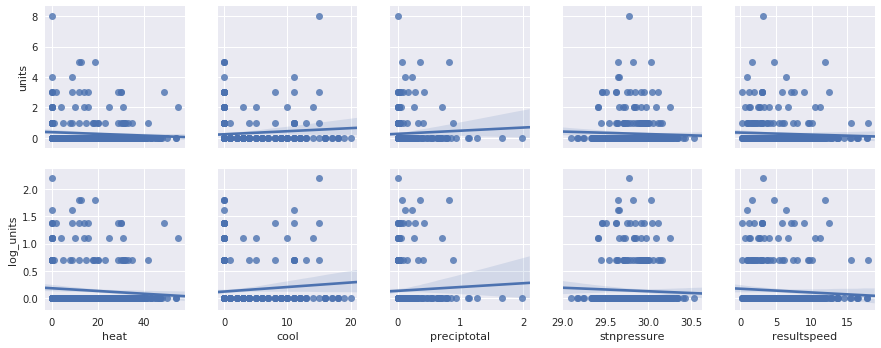

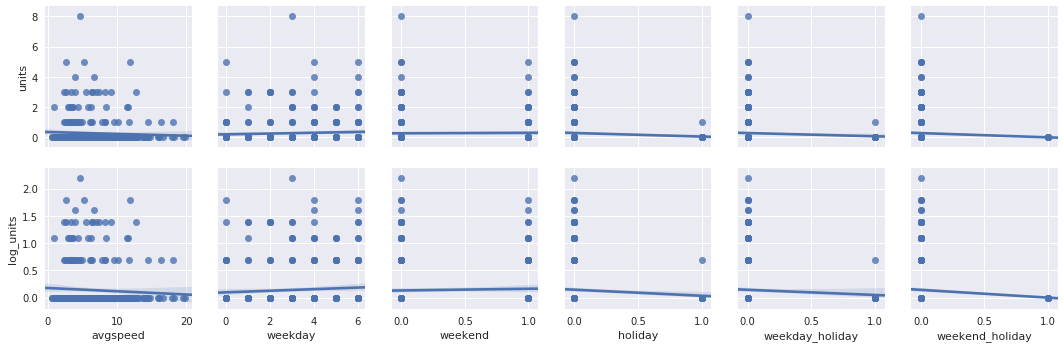

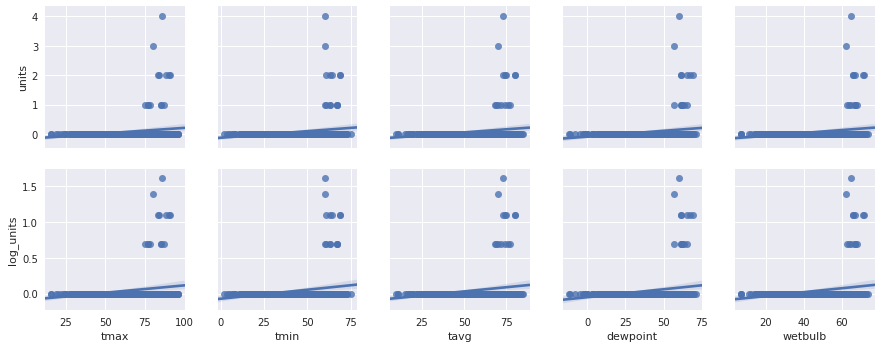

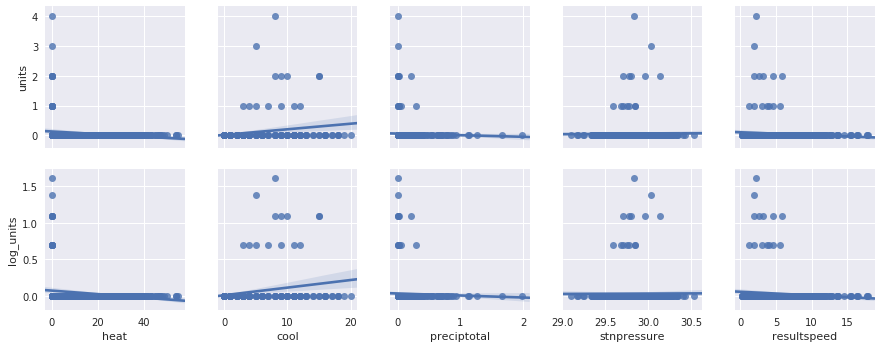

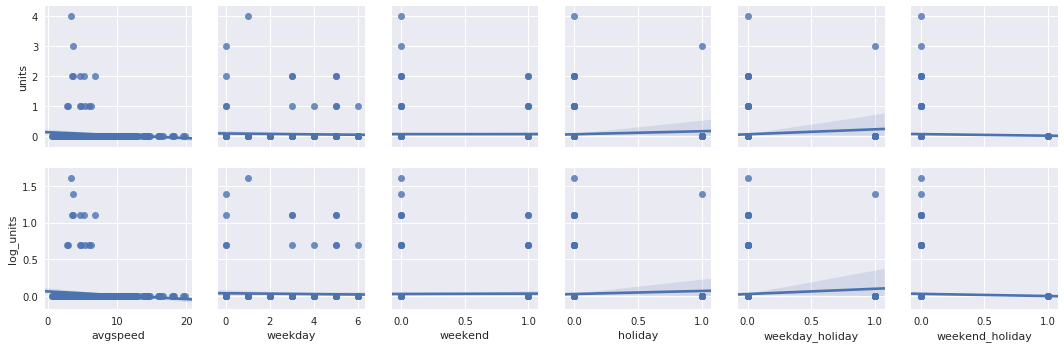

In [27]:
for station_nbr in range(1, 2) : # 1~20번 station
    weather_tmp_st = weather_tmp[weather_tmp['station_nbr'] == station_nbr].reset_index(drop = True)
    train_df_ = pd.merge(train_df, key, on = 'store_nbr')
    train_df_st = train_df_[train_df_['station_nbr'] == station_nbr]
    
    nonzero = train_df_st[train_df_st['log_units'] > 0]
    item_nbr_list = list(nonzero['item_nbr'].unique())
    
    for item_nbr in item_nbr_list :
        train_df_st_it = train_df_st[train_df_st['item_nbr'] == item_nbr]
        weather_tmp_st_it = pd.merge(weather_tmp_st, train_df_st_it, on = ['date', 'station_nbr'])
        
        sns.pairplot(weather_tmp_st_it, x_vars=['tmax', 'tmin', 'tavg', 'dewpoint', 'wetbulb'],
                     y_vars=['units', 'log_units'], kind='reg')
        plt.show()

        sns.pairplot(weather_tmp_st_it, x_vars=['heat', 'cool', 'preciptotal', 'stnpressure', 'resultspeed'],
                     y_vars=['units', 'log_units'], kind='reg')
        plt.show()

        sns.pairplot(weather_tmp_st_it, x_vars=['avgspeed', 'weekday', 'weekend', 'holiday', 'weekday_holiday', 'weekend_holiday'],
                     y_vars=['units', 'log_units'], kind='reg')
        plt.show()

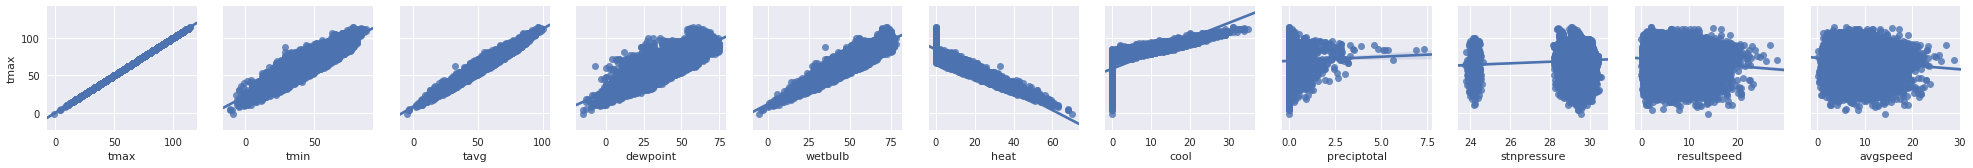

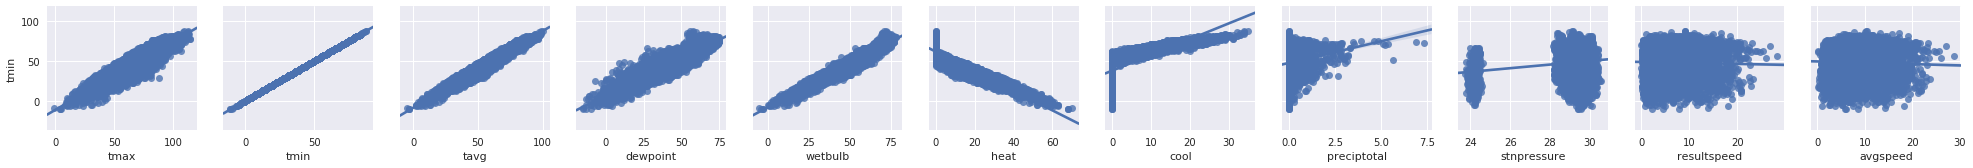

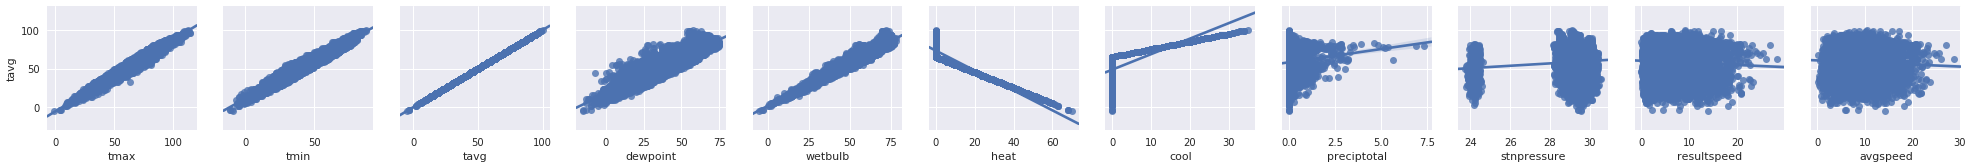

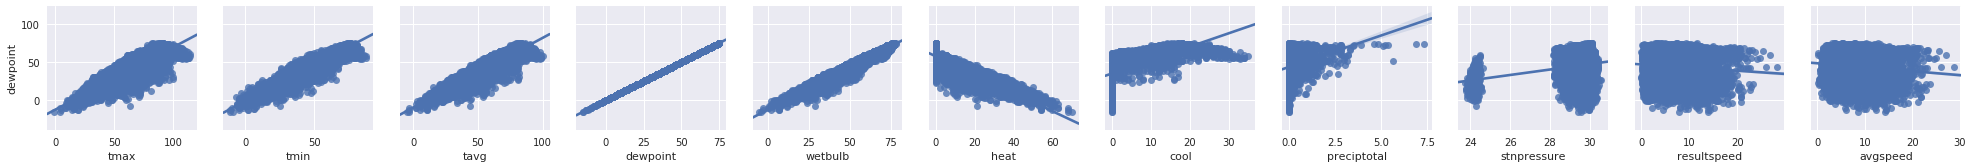

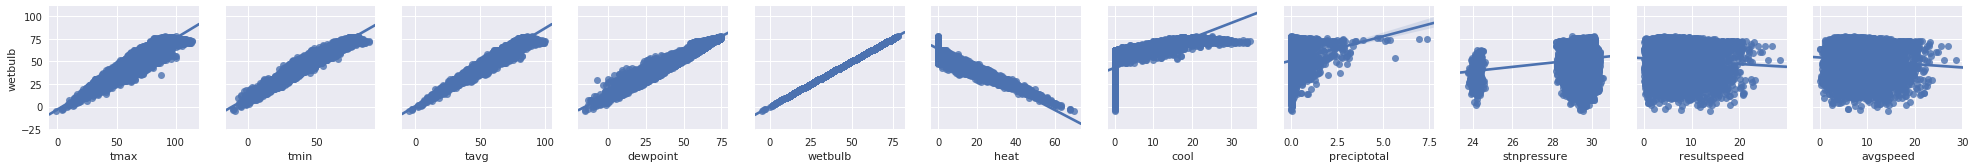

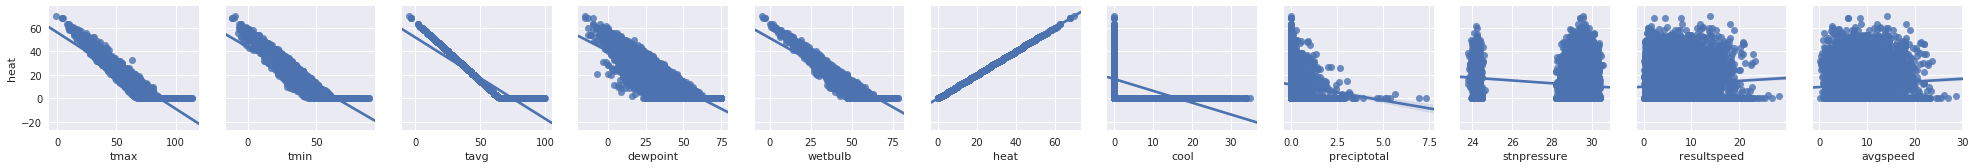

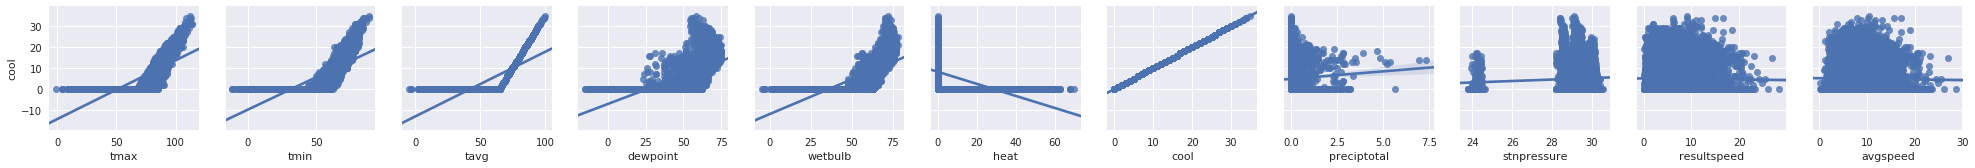

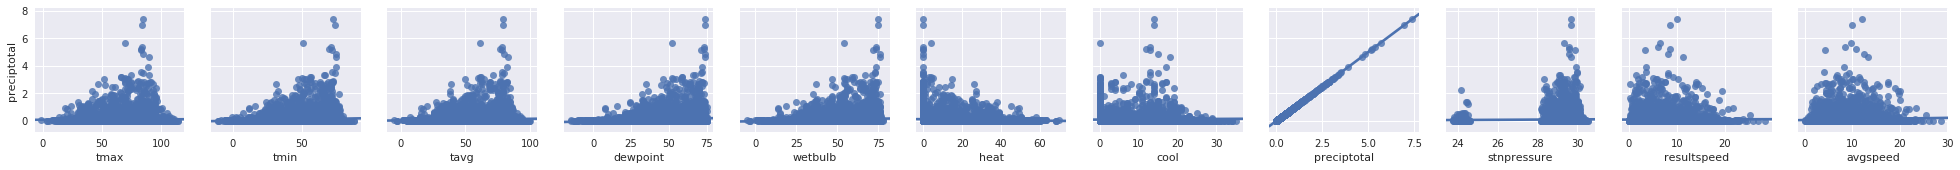

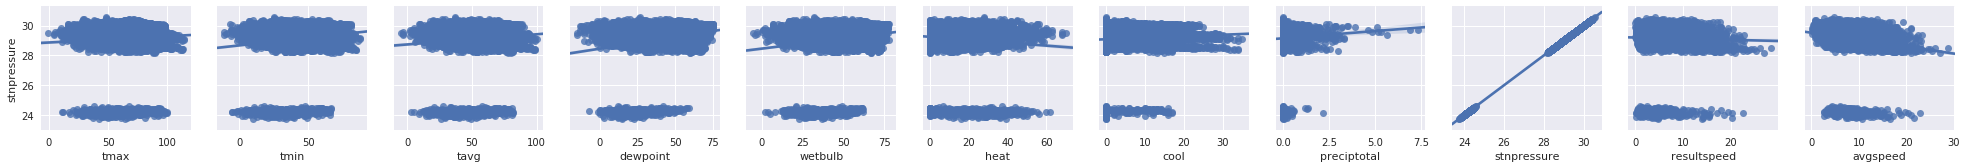

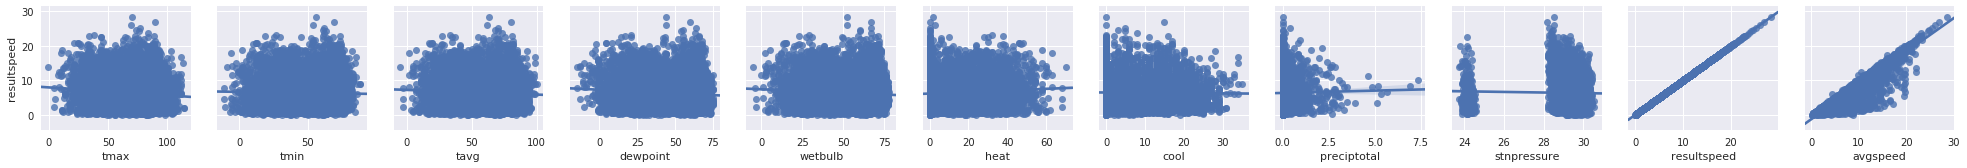

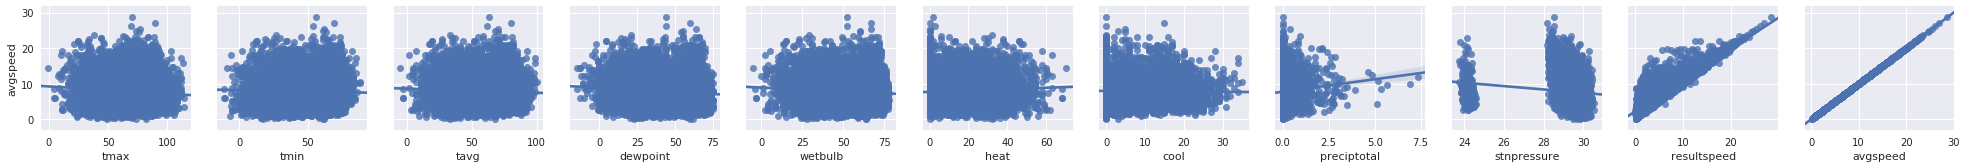

In [28]:
# weather column간 관계
sns.pairplot(weather_tmp, x_vars=['tmax', 'tmin', 'tavg', 'dewpoint', 'wetbulb', 'heat', 'cool',
       'preciptotal', 'stnpressure', 'resultspeed', 'avgspeed'], y_vars=['tmax'], kind='reg')
plt.show()
sns.pairplot(weather_tmp, x_vars=['tmax', 'tmin', 'tavg', 'dewpoint', 'wetbulb', 'heat', 'cool',
       'preciptotal', 'stnpressure', 'resultspeed', 'avgspeed'], y_vars=['tmin'], kind='reg')
plt.show()
sns.pairplot(weather_tmp, x_vars=['tmax', 'tmin', 'tavg', 'dewpoint', 'wetbulb', 'heat', 'cool',
       'preciptotal', 'stnpressure', 'resultspeed', 'avgspeed'], y_vars=['tavg'], kind='reg')
plt.show()
sns.pairplot(weather_tmp, x_vars=['tmax', 'tmin', 'tavg', 'dewpoint', 'wetbulb', 'heat', 'cool',
       'preciptotal', 'stnpressure', 'resultspeed', 'avgspeed'], y_vars=['dewpoint'], kind='reg')
plt.show()
sns.pairplot(weather_tmp, x_vars=['tmax', 'tmin', 'tavg', 'dewpoint', 'wetbulb', 'heat', 'cool',
       'preciptotal', 'stnpressure', 'resultspeed', 'avgspeed'], y_vars=['wetbulb'], kind='reg')
plt.show()
sns.pairplot(weather_tmp, x_vars=['tmax', 'tmin', 'tavg', 'dewpoint', 'wetbulb', 'heat', 'cool',
       'preciptotal', 'stnpressure', 'resultspeed', 'avgspeed'], y_vars=['heat'], kind='reg')
plt.show()
sns.pairplot(weather_tmp, x_vars=['tmax', 'tmin', 'tavg', 'dewpoint', 'wetbulb', 'heat', 'cool',
       'preciptotal', 'stnpressure', 'resultspeed', 'avgspeed'], y_vars=['cool'], kind='reg')
plt.show()
sns.pairplot(weather_tmp, x_vars=['tmax', 'tmin', 'tavg', 'dewpoint', 'wetbulb', 'heat', 'cool',
       'preciptotal', 'stnpressure', 'resultspeed', 'avgspeed'], y_vars=['preciptotal'], kind='reg')
plt.show()
sns.pairplot(weather_tmp, x_vars=['tmax', 'tmin', 'tavg', 'dewpoint', 'wetbulb', 'heat', 'cool',
       'preciptotal', 'stnpressure', 'resultspeed', 'avgspeed'], y_vars=['stnpressure'], kind='reg')
plt.show()
sns.pairplot(weather_tmp, x_vars=['tmax', 'tmin', 'tavg', 'dewpoint', 'wetbulb', 'heat', 'cool',
       'preciptotal', 'stnpressure', 'resultspeed', 'avgspeed'], y_vars=['resultspeed'], kind='reg')
plt.show()
sns.pairplot(weather_tmp, x_vars=['tmax', 'tmin', 'tavg', 'dewpoint', 'wetbulb', 'heat', 'cool',
       'preciptotal', 'stnpressure', 'resultspeed', 'avgspeed'], y_vars=['avgspeed'], kind='reg')
plt.show()

temperature와 dewpoint wetbulb, cool과 heat외에는 상관관계가 없어보인다. 상관계수를 알아보자

In [29]:
train_df['log_units'] = np.log(train_df['units'] + 1)

In [30]:
tmp = pd.merge(train_df, key, on = 'store_nbr')

In [31]:
tmp = tmp[tmp['units'] != 0]

각 weather station별로 units이 0이 아닌 item_nbr들의 units와 weather column들 간의 correlation을 살펴보자

In [32]:
# weather_tmp.drop(['RA_flag', 'FZ_flag', 'FG_flag', 'BR_flag', 'normal_flag',
#        'UP_flag', 'MI_flag', 'SN_flag', 'HZ_flag', 'TS_flag', 'VC_flag',
#        'DZ_flag', 'BL_flag', 'BC_flag', 'DU_flag', 'SQ_flag', 'PL_flag',
#        'FU_flag', 'GR_flag', 'GS_flag', 'SG_flag', 'PR_flag', 'snow_event',
#        'rain_event'], axis = 1, inplace = True)

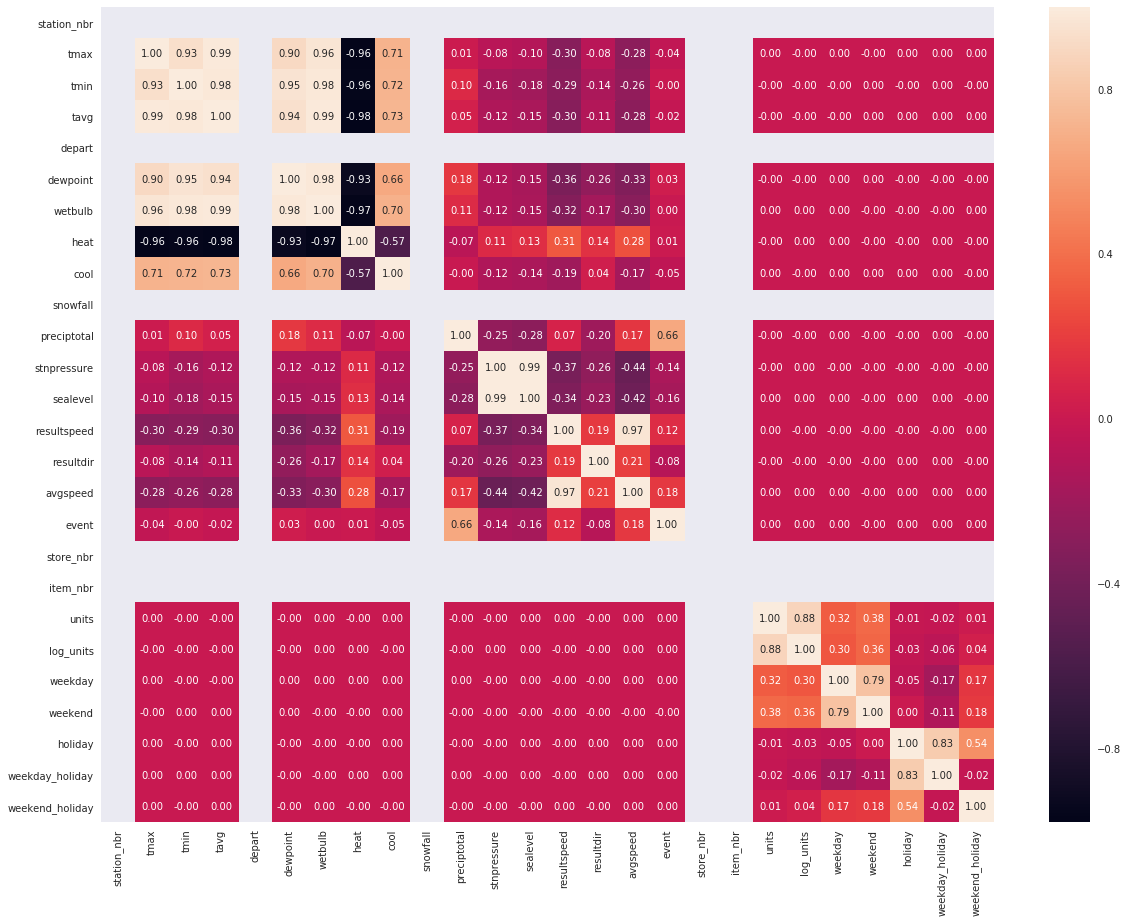

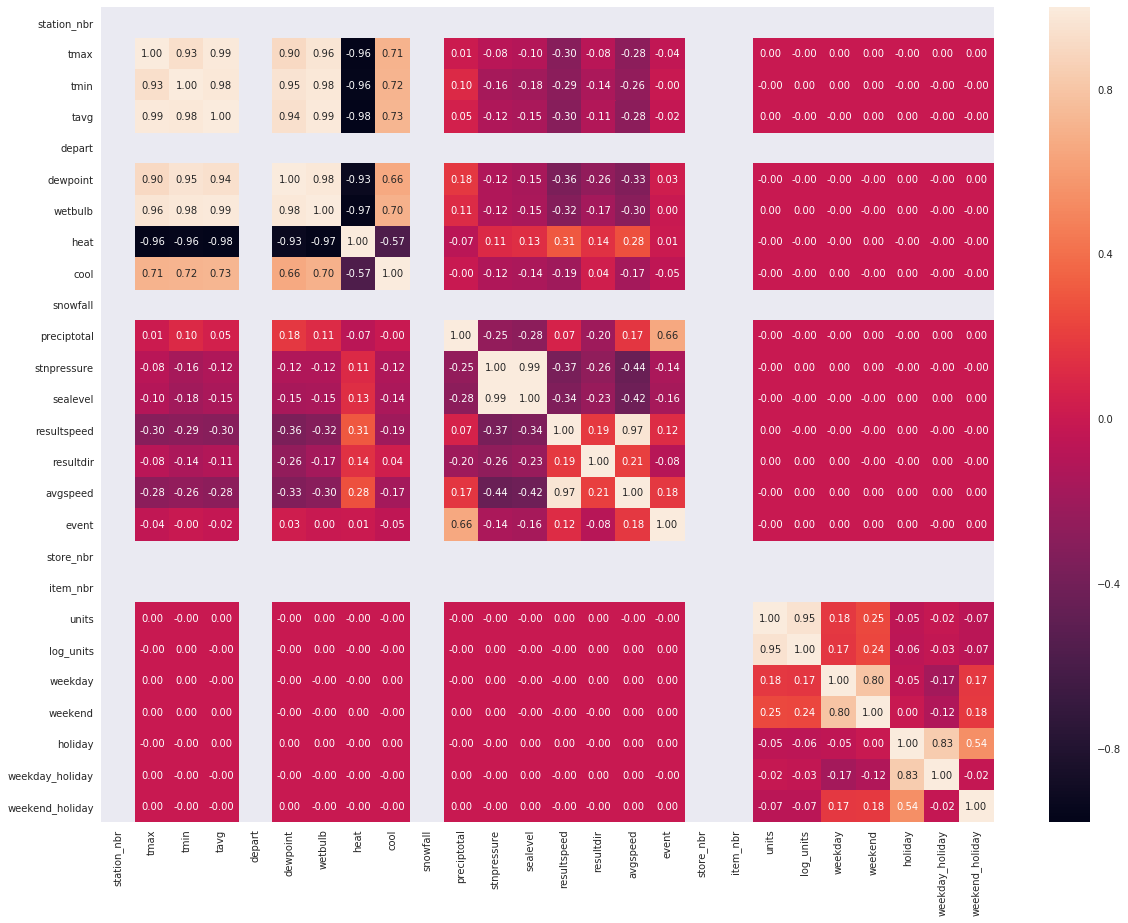

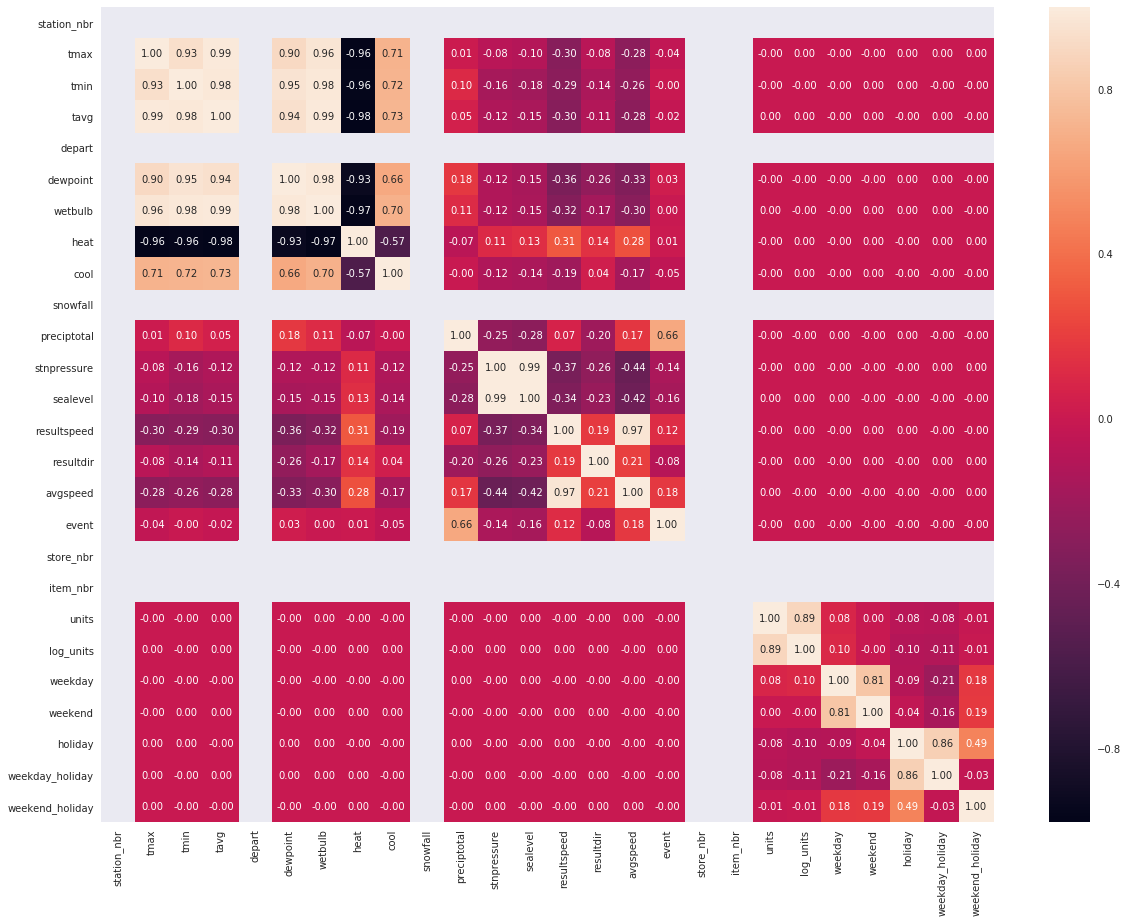

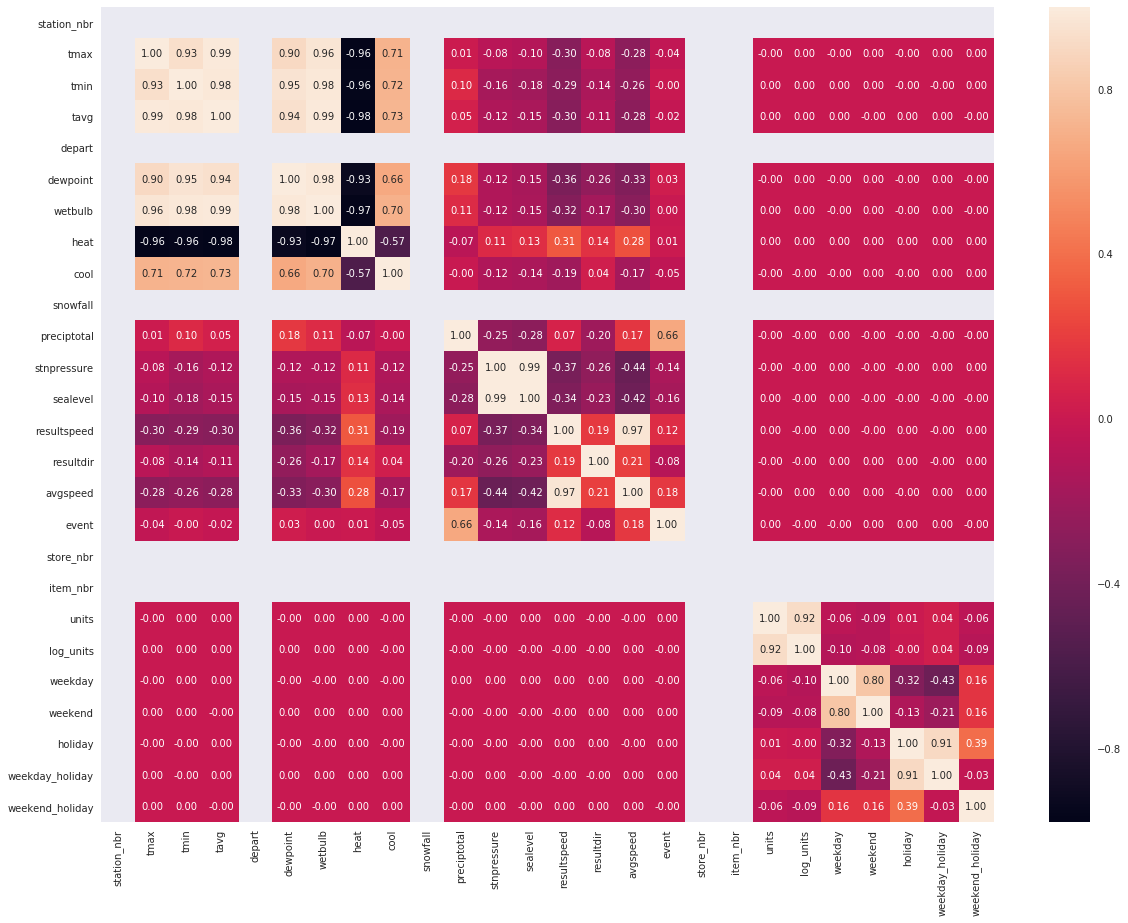

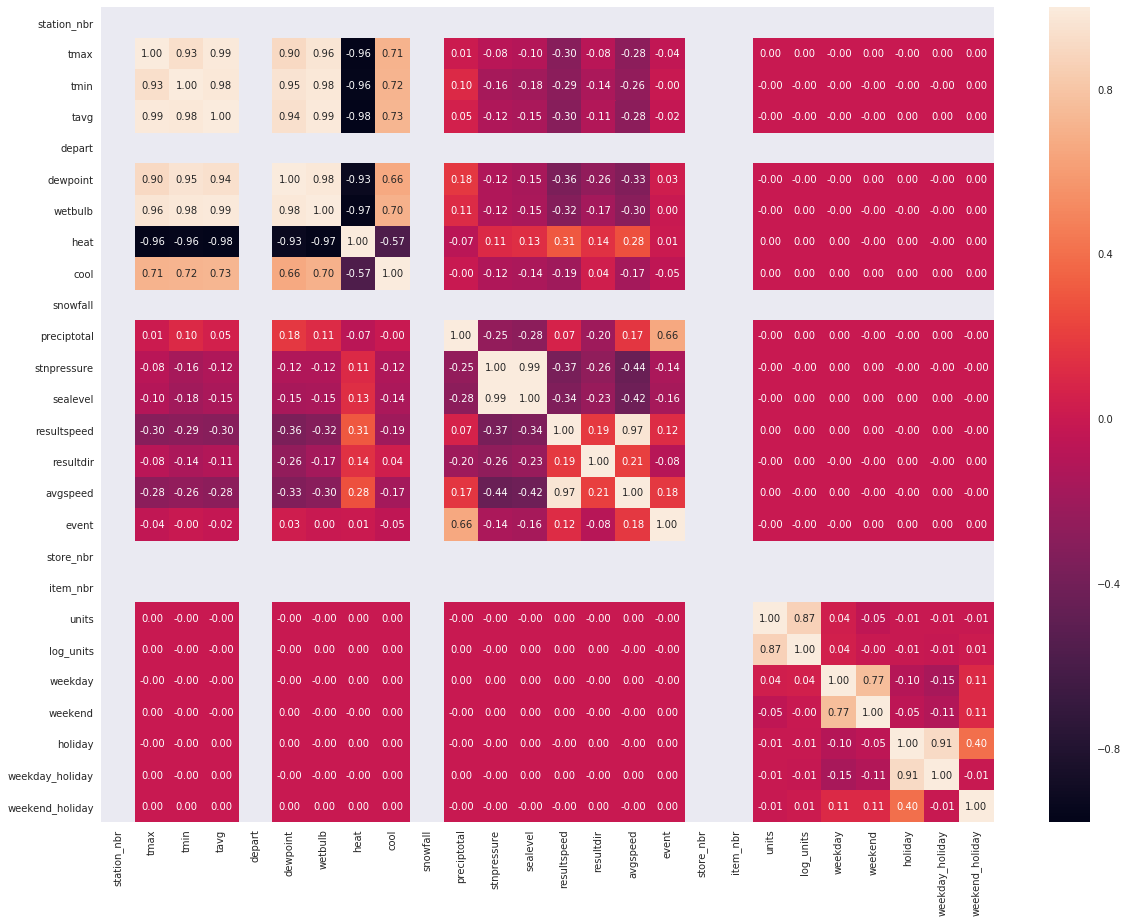

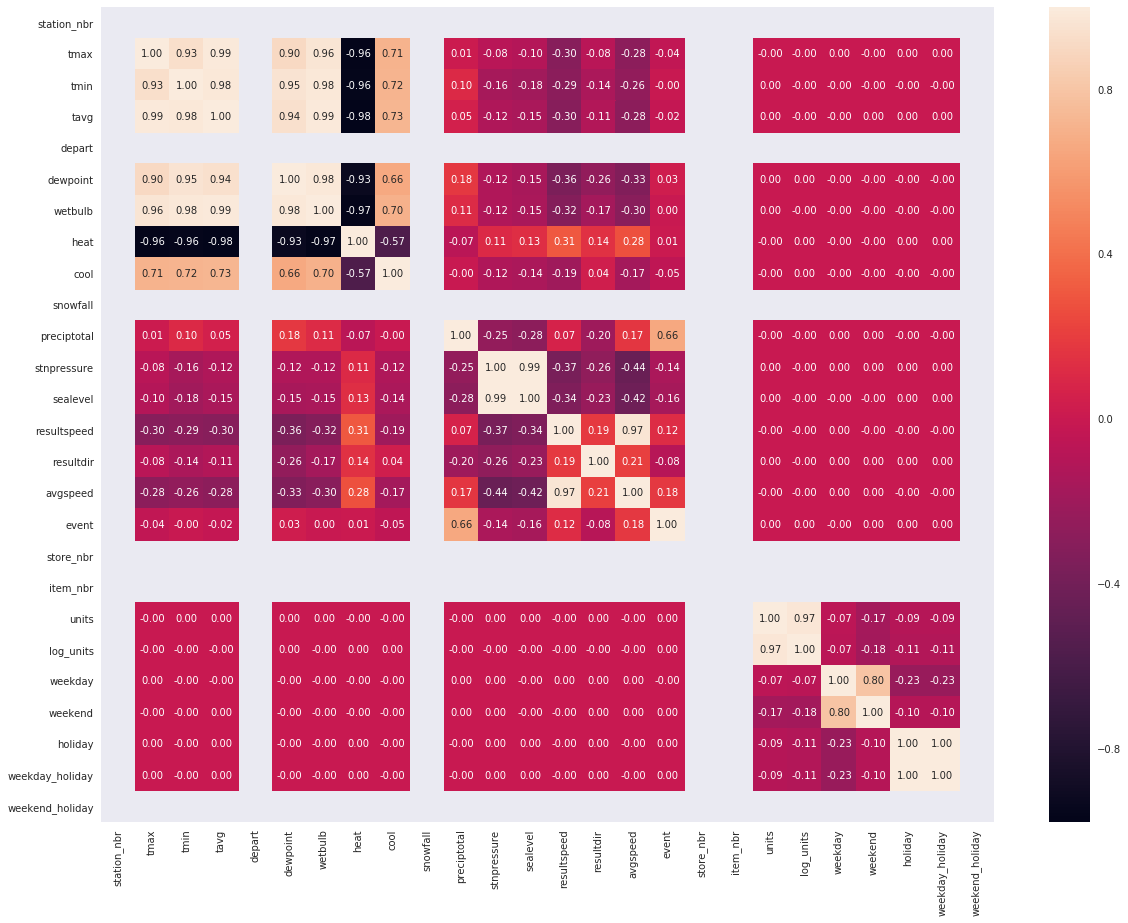

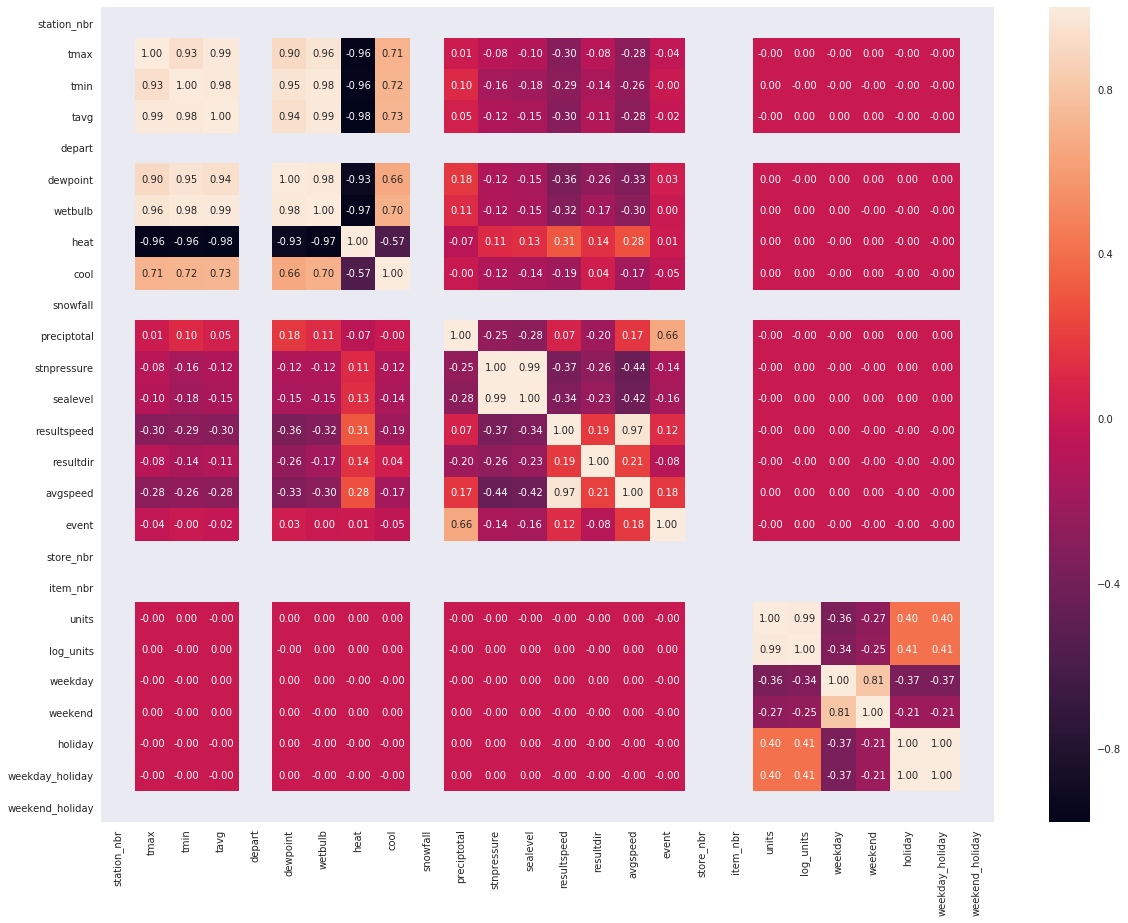

In [33]:
for x in range(1, 2) : #station_nbr은 1~20까지....
    weather_cor = weather_tmp[weather_tmp['station_nbr'] == x]
    tmp_ = tmp[tmp['station_nbr'] == x]
    weather_cor1 = pd.merge(weather_cor, tmp_, on = 'station_nbr')
    item_nbr_list = list(weather_cor1['item_nbr'].unique())

    for num in item_nbr_list :
        weather_cor_ = weather_cor1[weather_cor1['item_nbr'] == num]
        plt.figure(figsize=(20,15))
        sns.heatmap(weather_cor_.corr(), annot = True, fmt = '.2f')

우리가 관심있는 units와 log_units는 weather와는 별로 연관성이 없어보인다. 어떻게 할까?

# Feature Selection

위에서 보았다시피 각 스토어, 각 아이템별로 나누어 모델링을 해야함은 분명하다

weather와 log_units(또는 units)의 큰 상관관계는 없는 것으로 보인다.

그나마 weekday와 holiday가 log_units(또는 units)에 영향을 미치는 것으로 보인다(item_nbr에 따라 다름).

## Modeling

In [34]:
contrast_weekday = np.eye(7)
result_test = [] #outlier 제거 전
result_test2 = [] #outlier 제거 후

In [35]:
processed_train.drop(['weekend', 'weekday_holiday', 'weekend_holiday',
       'station_nbr', 'tmax', 'tmin', 'tavg', 'depart', 'dewpoint', 'wetbulb',
       'heat', 'cool', 'sunrise', 'sunset', 'codesum', 'snowfall',
       'preciptotal', 'stnpressure', 'sealevel', 'resultspeed', 'resultspeed',
       'resultdir', 'avgspeed'], axis = 1, inplace = True)

In [36]:
processed_test.drop(['weekend', 'weekday_holiday', 'weekend_holiday', 'station_nbr', 'tmax', 'tmin',
       'tavg', 'depart', 'dewpoint', 'wetbulb', 'heat', 'cool', 'sunrise',
       'sunset', 'codesum', 'snowfall', 'preciptotal', 'stnpressure',
       'sealevel', 'resultspeed', 'resultspeed', 'resultdir', 'avgspeed'], axis = 1, inplace = True)

In [37]:
df_1 = processed_train[processed_train['store_nbr'] == 1].reset_index(drop = True)

model1 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_1)
result_model1 = model1.fit()
print(result_model1.summary())

test_1 = processed_test[processed_test['store_nbr'] == 1]

test_1['log_units'] = result_model1.predict(test_1)
test_1['units'] = np.exp(test_1['log_units']) - 1
result_test.append(test_1)

                            OLS Regression Results                            
Dep. Variable:              log_units   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     340.5
Date:                Thu, 15 Mar 2018   Prob (F-statistic):               0.00
Time:                        13:58:10   Log-Likelihood:                 23410.
No. Observations:               50505   AIC:                        -4.527e+04
Df Residuals:                   49728   BIC:                        -3.840e+04
Df Model:                         776                                         
Covariance Type:            nonrobust                                         
                                                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

/home/yjoung90/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/yjoung90/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [38]:
# # Cross Validation
# # train set이 총 5분기 이므로 1분기씩 나눠준다..
# cv1_1 = df_1[:10101]
# cv1_2 = df_1[10101:20202]
# cv1_3 = df_1[20202:30414]
# cv1_4 = df_1[30414:40515]
# cv1_5 = df_1[40515:]

# # 기존 train set을 cv_train과 cv_test로 나눌 수 있음
# cv1_train = pd.concat([cv1_1, cv1_2, cv1_3, cv1_4], ignore_index = True)
# cv1_test = cv1_5

# model_cv1 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = cv1_train)
# result_model_cv1 = model_cv1.fit()
# print(result_model_cv1.summary())

# cv1_test['log_units_cv'] = result_model_cv1.predict(cv1_test)
# cv1_test['units_cv'] = np.exp(cv1_test['log_units_cv']) - 1

# cv1_test['RMSLE'] = np.log((cv1_test['units_cv'] + 1) / (cv1_test['units'] + 1)) ** 2
# RMSLE = np.sqrt(np.sum(cv1_test['RMSLE']) / len(cv1_test))
# print(RMSLE)

1506


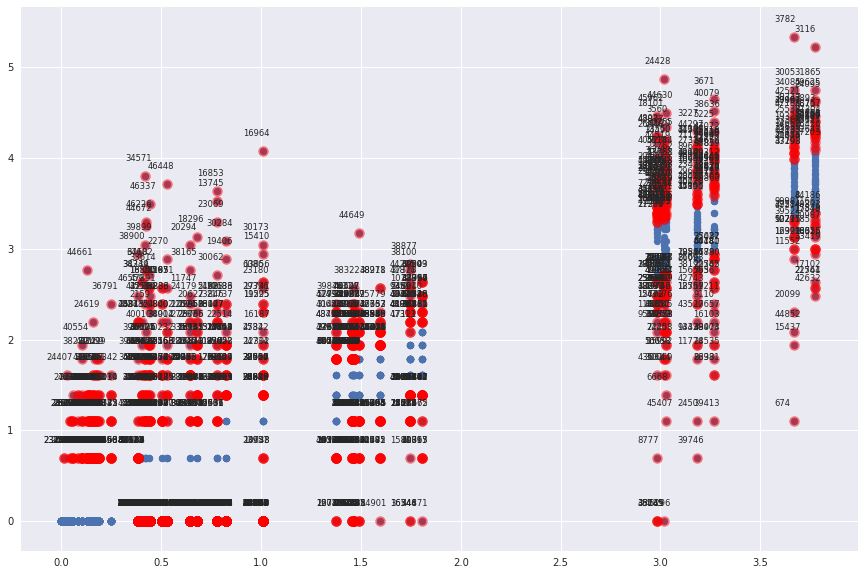

In [39]:
item_nbr_list_1 = get_item_nbr(df_1) #1번 store에서 팔린 item_nbr만 list로 저장

influence1 = result_model1.get_influence()

cooks_d2_1, pvals1 = influence1.cooks_distance # fox outlier recommendation으로 outlier 판별
fox_cr1 = 4 / (len(df_1) - 778)
idx1 = np.where(cooks_d2_1 > fox_cr1)[0]

print(len(idx1)) #outlier 갯수

X1 = result_model1.predict(df_1)

fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(X1, df_1['log_units'])
plt.scatter(X1[idx1], df_1.loc[idx1]['log_units'], s = 100, c = "r", alpha = 0.5)
utils.annotate_axes(range(len(idx1)), idx1, list(zip(X1[idx1], df_1.loc[idx1]['log_units'])),
                    [(-20, 15)] * len(idx1), size = "small", ax = ax)

plt.show()
del model1, result_model1, test_1

In [40]:
for num in idx1 : # outlier들을 각 item_nbr별 평균치로 대체
    for item_nbr in item_nbr_list_1 :
        if item_nbr == df_1.loc[num].item_nbr :
            mean = df_1[df_1['item_nbr'] == item_nbr]['log_units'].mean()
            df_1.set_value(num, 'log_units', mean)
            df_1.set_value(num, 'units', np.exp(mean) - 1)

model1_new = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_1)
result_model1_new = model1_new.fit()
print(result_model1_new.summary())

test_1_new = processed_test[processed_test['store_nbr'] == 1]

test_1_new['log_units'] = result_model1_new.predict(test_1_new)
test_1_new['units'] = np.exp(test_1_new['log_units']) - 1
result_test2.append(test_1_new)
del model_1_new, result_model1_new, test_1_new

/home/yjoung90/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """
/home/yjoung90/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


                            OLS Regression Results                            
Dep. Variable:              log_units   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 1.219e+04
Date:                Thu, 15 Mar 2018   Prob (F-statistic):               0.00
Time:                        13:59:10   Log-Likelihood:             1.1342e+05
No. Observations:               50505   AIC:                        -2.253e+05
Df Residuals:                   49728   BIC:                        -2.184e+05
Df Model:                         776                                         
Covariance Type:            nonrobust                                         
                                                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

/home/yjoung90/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/yjoung90/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


NameError: name 'model_1_new' is not defined

In [ ]:
df_2 = processed_train[processed_train['store_nbr'] == 2].reset_index(drop = True)

model2 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_2)
result_model2 = model2.fit()
print(result_model2.summary())

test_2 = processed_test[processed_test['store_nbr'] == 2]

test_2['log_units'] = result_model2.predict(test_2)
test_2['units'] = np.exp(test_2['log_units']) - 1
result_test.append(test_2)

In [ ]:
# Cross Validation
# # train set이 총 5분기 이므로 1분기씩 나눠준다..
# cv2_1 = df_2[:10101]
# cv2_2 = df_2[10101:20202]
# cv2_3 = df_2[20202:30414]
# cv2_4 = df_2[30414:40515]
# cv2_5 = df_2[40515:]

# # 기존 train set을 cv_train과 cv_test로 나눌 수 있음
# cv2_train = pd.concat([cv2_1, cv2_2, cv2_3, cv2_4], ignore_index = True)
# cv2_test = cv2_5

# model_cv2 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = cv2_train)
# result_model_cv2 = model_cv2.fit()
# print(result_model_cv2.summary())

# cv2_test['log_units_cv'] = result_model_cv2.predict(cv2_test)
# cv2_test['units_cv'] = np.exp(cv2_test['log_units_cv']) - 1

# cv2_test['RMSLE'] = np.log((cv2_test['units_cv'] + 1) / (cv2_test['units'] + 1)) ** 2
# RMSLE = np.sqrt(np.sum(cv2_test['RMSLE']) / len(cv2_test))
# print(RMSLE)

In [ ]:
item_nbr_list_2 = get_item_nbr(df_2) #2번 store에서 팔린 item_nbr만 list로 저장

influence2 = result_model2.get_influence()

cooks_d2_2, pvals2 = influence2.cooks_distance # fox outlier recommendation으로 outlier 판별
fox_cr2 = 4 / (len(df_2) - 778)
idx2 = np.where(cooks_d2_2 > fox_cr2)[0]

print(len(idx2)) #outlier 갯수

X2 = result_model2.predict(df_2)

fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(X2, df_2['log_units'])
plt.scatter(X2[idx2], df_2.loc[idx2]['log_units'], s = 100, c = "r", alpha = 0.5)
utils.annotate_axes(range(len(idx2)), idx2, list(zip(X2[idx2], df_2.loc[idx2]['log_units'])),
                    [(-20, 15)] * len(idx2), size = "small", ax = ax)

plt.show()
del model2, result_model2, test_2

In [ ]:
for num in idx2 : # outlier들을 각 item_nbr별 평균치로 대체
    for item_nbr in item_nbr_list_2 :
        if item_nbr == df_2.loc[num].item_nbr :
            mean = df_2[df_2['item_nbr'] == item_nbr]['log_units'].mean()
            df_2.set_value(num, 'log_units', mean)
            df_2.set_value(num, 'units', np.exp(mean) - 1)

model2_new = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_2)
result_model2_new = model2_new.fit()
print(result_model2_new.summary())

test_2_new = processed_test[processed_test['store_nbr'] == 2]

test_2_new['log_units'] = result_model2_new.predict(test_2_new)
test_2_new['units'] = np.exp(test_2_new['log_units']) - 1
result_test2.append(test_2_new)
del model_2_new, result_model2_new, test_2_new

In [ ]:
df_3 = processed_train[processed_train['store_nbr'] == 3].reset_index(drop = True)

model3 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_3)
result_model3 = model3.fit()
print(result_model3.summary())

test_3 = processed_test[processed_test['store_nbr'] == 3]

test_3['log_units'] = result_model3.predict(test_3)
test_3['units'] = np.exp(test_3['log_units']) - 1
result_test.append(test_3)


In [ ]:
# Cross Validation
# # train set이 총 5분기 이므로 1분기씩 나눠준다..
# cv3_1 = df_3[:10101]
# cv3_2 = df_3[10101:20202]
# cv3_3 = df_3[20202:30414]
# cv3_4 = df_3[30414:40515]
# cv3_5 = df_3[40515:]

# # 기존 train set을 cv_train과 cv_test로 나눌 수 있음
# cv3_train = pd.concat([cv3_1, cv3_2, cv3_3, cv3_4], ignore_index = True)
# cv3_test = cv3_5

# model_cv3 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = cv3_train)
# result_model_cv3 = model_cv3.fit()
# print(result_model_cv3.summary())

# cv3_test['log_units_cv'] = result_model_cv3.predict(cv3_test)
# cv3_test['units_cv'] = np.exp(cv3_test['log_units_cv']) - 1

# cv3_test['RMSLE'] = np.log((cv3_test['units_cv'] + 1) / (cv3_test['units'] + 1)) ** 2
# RMSLE = np.sqrt(np.sum(cv3_test['RMSLE']) / len(cv3_test))
# print(RMSLE)

In [ ]:
item_nbr_list_3 = get_item_nbr(df_3) #3번 store에서 팔린 item_nbr만 list로 저장

influence3 = result_model3.get_influence()

cooks_d2_3, pvals3 = influence3.cooks_distance # fox outlier recommendation으로 outlier 판별
fox_cr3 = 4 / (len(df_3) - 778)
idx3 = np.where(cooks_d2_3 > fox_cr3)[0]

print(len(idx3)) #outlier 갯수

X3 = result_model3.predict(df_3)

fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(X3, df_3['log_units'])
plt.scatter(X3[idx3], df_3.loc[idx3]['log_units'], s = 100, c = "r", alpha = 0.5)
utils.annotate_axes(range(len(idx3)), idx3, list(zip(X3[idx3], df_3.loc[idx3]['log_units'])),
                    [(-20, 15)] * len(idx3), size = "small", ax = ax)

plt.show()
del model3, result_model3, test_3

In [ ]:
for num in idx3 : # outlier들을 각 item_nbr별 평균치로 대체
    for item_nbr in item_nbr_list_3 :
        if item_nbr == df_3.loc[num].item_nbr :
            mean = df_3[df_3['item_nbr'] == item_nbr]['log_units'].mean()
            df_3.set_value(num, 'log_units', mean)
            df_3.set_value(num, 'units', np.exp(mean) - 1)

model3_new = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_3)
result_model3_new = model3_new.fit()
print(result_model3_new.summary())

test_3_new = processed_test[processed_test['store_nbr'] == 3]

test_3_new['log_units'] = result_model3_new.predict(test_3_new)
test_3_new['units'] = np.exp(test_3_new['log_units']) - 1
result_test2.append(test_3_new)
del model_3_new, result_model3_new, test_3_new

In [ ]:
df_4 = processed_train[processed_train['store_nbr'] == 4].reset_index(drop = True)

model4 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_4)
result_model4 = model4.fit()
print(result_model4.summary())

test_4 = processed_test[processed_test['store_nbr'] == 4]

test_4['log_units'] = result_model4.predict(test_4)
test_4['units'] = np.exp(test_4['log_units']) - 1
result_test.append(test_4)


In [ ]:
# # Cross Validation
# # train set이 총 5분기 이므로 1분기씩 나눠준다..
# cv4_1 = df_4[:10101]
# cv4_2 = df_4[10101:20202]
# cv4_3 = df_4[20202:30414]
# cv4_4 = df_4[30414:40515]
# cv4_5 = df_4[40515:]

# # 기존 train set을 cv_train과 cv_test로 나눌 수 있음
# cv4_train = pd.concat([cv4_1, cv4_2, cv4_3, cv4_4], ignore_index = True)
# cv4_test = cv4_5

# model_cv4 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = cv4_train)
# result_model_cv4 = model_cv4.fit()
# print(result_model_cv4.summary())

# cv4_test['log_units_cv'] = result_model_cv4.predict(cv4_test)
# cv4_test['units_cv'] = np.exp(cv4_test['log_units_cv']) - 1

# cv4_test['RMSLE'] = np.log((cv4_test['units_cv'] + 1) / (cv4_test['units'] + 1)) ** 2
# RMSLE = np.sqrt(np.sum(cv4_test['RMSLE']) / len(cv4_test))
# print(RMSLE)

In [ ]:
item_nbr_list_4 = get_item_nbr(df_4) #4번 store에서 팔린 item_nbr만 list로 저장

influence4 = result_model4.get_influence()

cooks_d2_4, pvals4 = influence4.cooks_distance # fox outlier recommendation으로 outlier 판별
fox_cr4 = 4 / (len(df_4) - 778)
idx4 = np.where(cooks_d2_4 > fox_cr4)[0]

print(len(idx4)) #outlier 갯수

X4 = result_model4.predict(df_4)

fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(X4, df_4['log_units'])
plt.scatter(X4[idx4], df_4.loc[idx4]['log_units'], s = 100, c = "r", alpha = 0.5)
utils.annotate_axes(range(len(idx4)), idx4, list(zip(X4[idx4], df_4.loc[idx4]['log_units'])),
                    [(-20, 15)] * len(idx4), size = "small", ax = ax)

plt.show()
del model4, result_model4, test_4

In [ ]:
for num in idx4 : # outlier들을 각 item_nbr별 평균치로 대체
    for item_nbr in item_nbr_list_4 :
        if item_nbr == df_4.loc[num].item_nbr :
            mean = df_4[df_4['item_nbr'] == item_nbr]['log_units'].mean()
            df_4.set_value(num, 'log_units', mean)
            df_4.set_value(num, 'units', np.exp(mean) - 1)

model4_new = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_4)
result_model4_new = model4_new.fit()
print(result_model4_new.summary())

test_4_new = processed_test[processed_test['store_nbr'] == 4]

test_4_new['log_units'] = result_model4_new.predict(test_4_new)
test_4_new['units'] = np.exp(test_4_new['log_units']) - 1
result_test2.append(test_4_new)
del model_4_new, result_model4_new, test_4_new

In [ ]:
df_5 = processed_train[processed_train['store_nbr'] == 5].reset_index(drop = True)

model5 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_5)
result_model5 = model5.fit()
print(result_model5.summary())

test_5 = processed_test[processed_test['store_nbr'] == 5]

test_5['log_units'] = result_model5.predict(test_5)
test_5['units'] = np.exp(test_5['log_units']) - 1
result_test.append(test_5)


In [ ]:
# # Cross Validation
# # train set이 총 5분기 이므로 1분기씩 나눠준다..
# cv5_1 = df_5[:10101]
# cv5_2 = df_5[10101:20202]
# cv5_3 = df_5[20202:30414]
# cv5_4 = df_5[30414:40515]
# cv5_5 = df_5[40515:]

# # 기존 train set을 cv_train과 cv_test로 나눌 수 있음
# cv5_train = pd.concat([cv5_1, cv5_2, cv5_3, cv5_4], ignore_index = True)
# cv5_test = cv5_5

# model_cv5 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = cv5_train)
# result_model_cv5 = model_cv5.fit()
# print(result_model_cv5.summary())

# cv5_test['log_units_cv'] = result_model_cv5.predict(cv5_test)
# cv5_test['units_cv'] = np.exp(cv5_test['log_units_cv']) - 1

# cv5_test['RMSLE'] = np.log((cv5_test['units_cv'] + 1) / (cv5_test['units'] + 1)) ** 2
# RMSLE = np.sqrt(np.sum(cv5_test['RMSLE']) / len(cv5_test))
# print(RMSLE)

In [ ]:
item_nbr_list_5 = get_item_nbr(df_5) #5번 store에서 팔린 item_nbr만 list로 저장

influence5 = result_model5.get_influence()

cooks_d2_5, pvals5 = influence5.cooks_distance # fox outlier recommendation으로 outlier 판별
fox_cr5 = 4 / (len(df_5) - 778)
idx5 = np.where(cooks_d2_5 > fox_cr5)[0]

print(len(idx5)) #outlier 갯수

X5 = result_model5.predict(df_5)

fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(X5, df_5['log_units'])
plt.scatter(X5[idx5], df_5.loc[idx5]['log_units'], s = 100, c = "r", alpha = 0.5)
utils.annotate_axes(range(len(idx5)), idx5, list(zip(X5[idx5], df_5.loc[idx5]['log_units'])),
                    [(-20, 15)] * len(idx5), size = "small", ax = ax)

plt.show()
del model5, result_model5, test_5

In [ ]:
for num in idx5 : # outlier들을 각 item_nbr별 평균치로 대체
    for item_nbr in item_nbr_list_5 :
        if item_nbr == df_5.loc[num].item_nbr :
            mean = df_5[df_5['item_nbr'] == item_nbr]['log_units'].mean()
            df_5.set_value(num, 'log_units', mean)
            df_5.set_value(num, 'units', np.exp(mean) - 1)

model5_new = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_5)
result_model5_new = model5_new.fit()
print(result_model5_new.summary())

test_5_new = processed_test[processed_test['store_nbr'] == 5]

test_5_new['log_units'] = result_model5_new.predict(test_5_new)
test_5_new['units'] = np.exp(test_5_new['log_units']) - 1
result_test2.append(test_5_new)
del model_5_new, result_model5_new, test_5_new

In [ ]:
df_6 = processed_train[processed_train['store_nbr'] == 6].reset_index(drop = True)

model6 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_6)
result_model6 = model6.fit()
print(result_model6.summary())

test_6 = processed_test[processed_test['store_nbr'] == 6]

test_6['log_units'] = result_model6.predict(test_6)
test_6['units'] = np.exp(test_6['log_units']) - 1
result_test.append(test_6)


In [ ]:
# # Cross Validation
# # train set이 총 5분기 이므로 1분기씩 나눠준다..
# cv6_1 = df_6[:10101]
# cv6_2 = df_6[10101:20202]
# cv6_3 = df_6[20202:30414]
# cv6_4 = df_6[30414:40515]
# cv6_5 = df_6[40515:]

# # 기존 train set을 cv_train과 cv_test로 나눌 수 있음
# cv6_train = pd.concat([cv6_1, cv6_2, cv6_3, cv6_4], ignore_index = True)
# cv6_test = cv6_5

# model_cv6 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = cv6_train)
# result_model_cv6 = model_cv6.fit()
# print(result_model_cv6.summary())

# cv6_test['log_units_cv'] = result_model_cv6.predict(cv6_test)
# cv6_test['units_cv'] = np.exp(cv6_test['log_units_cv']) - 1

# cv6_test['RMSLE'] = np.log((cv6_test['units_cv'] + 1) / (cv6_test['units'] + 1)) ** 2
# RMSLE = np.sqrt(np.sum(cv6_test['RMSLE']) / len(cv6_test))
# print(RMSLE)

In [ ]:
item_nbr_list_6 = get_item_nbr(df_6) #6번 store에서 팔린 item_nbr만 list로 저장

influence6 = result_model6.get_influence()

cooks_d2_6, pvals6 = influence6.cooks_distance # fox outlier recommendation으로 outlier 판별
fox_cr6 = 4 / (len(df_6) - 778)
idx6 = np.where(cooks_d2_6 > fox_cr6)[0]

print(len(idx6)) #outlier 갯수

X6 = result_model6.predict(df_6)

fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(X6, df_6['log_units'])
plt.scatter(X6[idx6], df_6.loc[idx6]['log_units'], s = 100, c = "r", alpha = 0.5)
utils.annotate_axes(range(len(idx6)), idx6, list(zip(X6[idx6], df_6.loc[idx6]['log_units'])),
                    [(-20, 15)] * len(idx6), size = "small", ax = ax)

plt.show()
del model6, result_model6, test_6

In [ ]:
for num in idx6 : # outlier들을 각 item_nbr별 평균치로 대체
    for item_nbr in item_nbr_list_6 :
        if item_nbr == df_6.loc[num].item_nbr :
            mean = df_6[df_6['item_nbr'] == item_nbr]['log_units'].mean()
            df_6.set_value(num, 'log_units', mean)
            df_6.set_value(num, 'units', np.exp(mean) - 1)

model6_new = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_6)
result_model6_new = model6_new.fit()
print(result_model6_new.summary())

test_6_new = processed_test[processed_test['store_nbr'] == 6]

test_6_new['log_units'] = result_model6_new.predict(test_6_new)
test_6_new['units'] = np.exp(test_6_new['log_units']) - 1
result_test2.append(test_6_new)
del model_6_new, result_model6_new, test_6_new

In [ ]:
df_7 = processed_train[processed_train['store_nbr'] == 7].reset_index(drop = True)

model7 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_7)
result_model7 = model7.fit()
print(result_model7.summary())

test_7 = processed_test[processed_test['store_nbr'] == 7]

test_7['log_units'] = result_model7.predict(test_7)
test_7['units'] = np.exp(test_7['log_units']) - 1
result_test.append(test_7)


In [ ]:
# # Cross Validation
# # train set이 총 5분기 이므로 1분기씩 나눠준다..
# cv7_1 = df_7[:10101]
# cv7_2 = df_7[10101:20202]
# cv7_3 = df_7[20202:30414]
# cv7_4 = df_7[30414:40515]
# cv7_5 = df_7[40515:]

# # 기존 train set을 cv_train과 cv_test로 나눌 수 있음
# cv7_train = pd.concat([cv7_1, cv7_2, cv7_3, cv7_4], ignore_index = True)
# cv7_test = cv7_5

# model_cv7 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = cv7_train)
# result_model_cv7 = model_cv7.fit()
# print(result_model_cv7.summary())

# cv7_test['log_units_cv'] = result_model_cv7.predict(cv7_test)
# cv7_test['units_cv'] = np.exp(cv7_test['log_units_cv']) - 1

# cv7_test['RMSLE'] = np.log((cv7_test['units_cv'] + 1) / (cv7_test['units'] + 1)) ** 2
# RMSLE = np.sqrt(np.sum(cv7_test['RMSLE']) / len(cv7_test))
# print(RMSLE)

In [ ]:
item_nbr_list_7 = get_item_nbr(df_7) #7번 store에서 팔린 item_nbr만 list로 저장

influence7 = result_model7.get_influence()

cooks_d2_7, pvals7 = influence7.cooks_distance # fox outlier recommendation으로 outlier 판별
fox_cr7 = 4 / (len(df_7) - 778)
idx7 = np.where(cooks_d2_7 > fox_cr7)[0]

print(len(idx7)) #outlier 갯수

X7 = result_model7.predict(df_7)

fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(X7, df_7['log_units'])
plt.scatter(X7[idx7], df_7.loc[idx7]['log_units'], s = 100, c = "r", alpha = 0.5)
utils.annotate_axes(range(len(idx7)), idx7, list(zip(X7[idx7], df_7.loc[idx7]['log_units'])),
                    [(-20, 15)] * len(idx7), size = "small", ax = ax)

plt.show()
del model7, result_model7, test_7

In [ ]:
for num in idx7 : # outlier들을 각 item_nbr별 평균치로 대체
    for item_nbr in item_nbr_list_7 :
        if item_nbr == df_7.loc[num].item_nbr :
            mean = df_7[df_7['item_nbr'] == item_nbr]['log_units'].mean()
            df_7.set_value(num, 'log_units', mean)
            df_7.set_value(num, 'units', np.exp(mean) - 1)

model7_new = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_7)
result_model7_new = model7_new.fit()
print(result_model7_new.summary())

test_7_new = processed_test[processed_test['store_nbr'] == 7]

test_7_new['log_units'] = result_model7_new.predict(test_7_new)
test_7_new['units'] = np.exp(test_7_new['log_units']) - 1
result_test2.append(test_7_new)
del model_7_new, result_model7_new, test_7_new

In [ ]:
df_8 = processed_train[processed_train['store_nbr'] == 8].reset_index(drop = True)

model8 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_8)
result_model8 = model8.fit()
print(result_model8.summary())

test_8 = processed_test[processed_test['store_nbr'] == 8]

test_8['log_units'] = result_model8.predict(test_8)
test_8['units'] = np.exp(test_8['log_units']) - 1
result_test.append(test_8)


In [ ]:
# # Cross Validation
# # train set이 총 5분기 이므로 1분기씩 나눠준다..
# cv8_1 = df_8[:10101]
# cv8_2 = df_8[10101:20202]
# cv8_3 = df_8[20202:30414]
# cv8_4 = df_8[30414:40515]
# cv8_5 = df_8[40515:]

# # 기존 train set을 cv_train과 cv_test로 나눌 수 있음
# cv8_train = pd.concat([cv8_1, cv8_2, cv8_3, cv8_4], ignore_index = True)
# cv8_test = cv8_5

# model_cv8 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = cv8_train)
# result_model_cv8 = model_cv8.fit()
# print(result_model_cv8.summary())

# cv8_test['log_units_cv'] = result_model_cv8.predict(cv8_test)
# cv8_test['units_cv'] = np.exp(cv8_test['log_units_cv']) - 1

# cv8_test['RMSLE'] = np.log((cv8_test['units_cv'] + 1) / (cv8_test['units'] + 1)) ** 2
# RMSLE = np.sqrt(np.sum(cv8_test['RMSLE']) / len(cv8_test))
# print(RMSLE)

In [ ]:
item_nbr_list_8 = get_item_nbr(df_8) #8번 store에서 팔린 item_nbr만 list로 저장

influence8 = result_model8.get_influence()

cooks_d2_8, pvals8 = influence8.cooks_distance # fox outlier recommendation으로 outlier 판별
fox_cr8 = 4 / (len(df_8) - 778)
idx8 = np.where(cooks_d2_8 > fox_cr8)[0]

print(len(idx8)) #outlier 갯수

X8 = result_model8.predict(df_8)

fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(X8, df_8['log_units'])
plt.scatter(X8[idx8], df_8.loc[idx8]['log_units'], s = 100, c = "r", alpha = 0.5)
utils.annotate_axes(range(len(idx8)), idx8, list(zip(X8[idx8], df_8.loc[idx8]['log_units'])),
                    [(-20, 15)] * len(idx8), size = "small", ax = ax)

plt.show()
del model8, result_model8, test_8

In [ ]:
for num in idx8 : # outlier들을 각 item_nbr별 평균치로 대체
    for item_nbr in item_nbr_list_8 :
        if item_nbr == df_8.loc[num].item_nbr :
            mean = df_8[df_8['item_nbr'] == item_nbr]['log_units'].mean()
            df_8.set_value(num, 'log_units', mean)
            df_8.set_value(num, 'units', np.exp(mean) - 1)

model8_new = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_8)
result_model8_new = model8_new.fit()
print(result_model8_new.summary())

test_8_new = processed_test[processed_test['store_nbr'] == 8]

test_8_new['log_units'] = result_model8_new.predict(test_8_new)
test_8_new['units'] = np.exp(test_8_new['log_units']) - 1
result_test2.append(test_8_new)
del model_8_new, result_model8_new, test_8_new

In [ ]:
df_9 = processed_train[processed_train['store_nbr'] == 9].reset_index(drop = True)

model9 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_9)
result_model9 = model9.fit()
print(result_model9.summary())

test_9 = processed_test[processed_test['store_nbr'] == 9]

test_9['log_units'] = result_model9.predict(test_9)
test_9['units'] = np.exp(test_9['log_units']) - 1
result_test.append(test_9)


In [ ]:
# # Cross Validation
# # train set이 총 5분기 이므로 1분기씩 나눠준다..
# cv9_1 = df_9[:10101]
# cv9_2 = df_9[10101:20202]
# cv9_3 = df_9[20202:30414]
# cv9_4 = df_9[30414:40515]
# cv9_5 = df_9[40515:]

# # 기존 train set을 cv_train과 cv_test로 나눌 수 있음
# cv9_train = pd.concat([cv9_1, cv9_2, cv9_3, cv9_4], ignore_index = True)
# cv9_test = cv9_5

# model_cv9 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = cv9_train)
# result_model_cv9 = model_cv9.fit()
# print(result_model_cv9.summary())

# cv9_test['log_units_cv'] = result_model_cv9.predict(cv9_test)
# cv9_test['units_cv'] = np.exp(cv9_test['log_units_cv']) - 1

# cv9_test['RMSLE'] = np.log((cv9_test['units_cv'] + 1) / (cv9_test['units'] + 1)) ** 2
# RMSLE = np.sqrt(np.sum(cv9_test['RMSLE']) / len(cv9_test))
# print(RMSLE)

In [ ]:
item_nbr_list_9 = get_item_nbr(df_9) #9번 store에서 팔린 item_nbr만 list로 저장

influence9 = result_model9.get_influence()

cooks_d2_9, pvals9 = influence9.cooks_distance # fox outlier recommendation으로 outlier 판별
fox_cr9 = 4 / (len(df_9) - 778)
idx9 = np.where(cooks_d2_9 > fox_cr9)[0]

print(len(idx9)) #outlier 갯수

X9 = result_model9.predict(df_9)

fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(X9, df_9['log_units'])
plt.scatter(X9[idx9], df_9.loc[idx9]['log_units'], s = 100, c = "r", alpha = 0.5)
utils.annotate_axes(range(len(idx9)), idx9, list(zip(X9[idx9], df_9.loc[idx9]['log_units'])),
                    [(-20, 15)] * len(idx9), size = "small", ax = ax)

plt.show()
del model9, result_model9, test_9

In [ ]:
for num in idx9 : # outlier들을 각 item_nbr별 평균치로 대체
    for item_nbr in item_nbr_list_9 :
        if item_nbr == df_9.loc[num].item_nbr :
            mean = df_9[df_9['item_nbr'] == item_nbr]['log_units'].mean()
            df_9.set_value(num, 'log_units', mean)
            df_9.set_value(num, 'units', np.exp(mean) - 1)

model9_new = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_9)
result_model9_new = model9_new.fit()
print(result_model9_new.summary())

test_9_new = processed_test[processed_test['store_nbr'] == 9]

test_9_new['log_units'] = result_model9_new.predict(test_9_new)
test_9_new['units'] = np.exp(test_9_new['log_units']) - 1
result_test2.append(test_9_new)
del model_9_new, result_model9_new, test_9_new

In [ ]:
df_10 = processed_train[processed_train['store_nbr'] == 10].reset_index(drop = True)

model10 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_10)
result_model10 = model10.fit()
print(result_model10.summary())

test_10 = processed_test[processed_test['store_nbr'] == 10]

test_10['log_units'] = result_model10.predict(test_10)
test_10['units'] = np.exp(test_10['log_units']) - 1
result_test.append(test_10)


In [ ]:
# # Cross Validation
# # train set이 총 5분기 이므로 1분기씩 나눠준다..
# cv10_1 = df_10[:10101]
# cv10_2 = df_10[10101:20202]
# cv10_3 = df_10[20202:30414]
# cv10_4 = df_10[30414:40515]
# cv10_5 = df_10[40515:]

# # 기존 train set을 cv_train과 cv_test로 나눌 수 있음
# cv10_train = pd.concat([cv10_1, cv10_2, cv10_3, cv10_4], ignore_index = True)
# cv10_test = cv10_5

# model_cv10 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = cv10_train)
# result_model_cv10 = model_cv10.fit()
# print(result_model_cv10.summary())

# cv10_test['log_units_cv'] = result_model_cv10.predict(cv10_test)
# cv10_test['units_cv'] = np.exp(cv10_test['log_units_cv']) - 1

# cv10_test['RMSLE'] = np.log((cv10_test['units_cv'] + 1) / (cv10_test['units'] + 1)) ** 2
# RMSLE = np.sqrt(np.sum(cv10_test['RMSLE']) / len(cv10_test))
# print(RMSLE)

In [ ]:
item_nbr_list_10 = get_item_nbr(df_10) #10번 store에서 팔린 item_nbr만 list로 저장

influence10 = result_model10.get_influence()

cooks_d2_10, pvals10 = influence10.cooks_distance # fox outlier recommendation으로 outlier 판별
fox_cr10 = 4 / (len(df_10) - 778)
idx10 = np.where(cooks_d2_10 > fox_cr10)[0]

print(len(idx10)) #outlier 갯수

X10 = result_model10.predict(df_10)

fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(X10, df_10['log_units'])
plt.scatter(X10[idx10], df_10.loc[idx10]['log_units'], s = 100, c = "r", alpha = 0.5)
utils.annotate_axes(range(len(idx10)), idx10, list(zip(X10[idx10], df_10.loc[idx10]['log_units'])),
                    [(-20, 15)] * len(idx10), size = "small", ax = ax)

plt.show()
del model10, result_model10, test_10

In [ ]:
for num in idx10 : # outlier들을 각 item_nbr별 평균치로 대체
    for item_nbr in item_nbr_list_10 :
        if item_nbr == df_10.loc[num].item_nbr :
            mean = df_10[df_10['item_nbr'] == item_nbr]['log_units'].mean()
            df_10.set_value(num, 'log_units', mean)
            df_10.set_value(num, 'units', np.exp(mean) - 1)

model10_new = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_10)
result_model10_new = model10_new.fit()
print(result_model10_new.summary())

test_10_new = processed_test[processed_test['store_nbr'] == 10]

test_10_new['log_units'] = result_model10_new.predict(test_10_new)
test_10_new['units'] = np.exp(test_10_new['log_units']) - 1
result_test2.append(test_10_new)
del model_10_new, result_model10_new, test_10_new

In [ ]:
df_11 = processed_train[processed_train['store_nbr'] == 11].reset_index(drop = True)

model11 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_11)
result_model11 = model11.fit()
print(result_model11.summary())

test_11 = processed_test[processed_test['store_nbr'] == 11]

test_11['log_units'] = result_model11.predict(test_11)
test_11['units'] = np.exp(test_11['log_units']) - 1
result_test.append(test_11)


In [ ]:
# # Cross Validation
# # train set이 총 5분기 이므로 1분기씩 나눠준다..
# cv11_1 = df_11[:10101]
# cv11_2 = df_11[10101:20202]
# cv11_3 = df_11[20202:30414]
# cv11_4 = df_11[30414:40515]
# cv11_5 = df_11[40515:]

# # 기존 train set을 cv_train과 cv_test로 나눌 수 있음
# cv11_train = pd.concat([cv11_1, cv11_2, cv11_3, cv11_4], ignore_index = True)
# cv11_test = cv11_5

# model_cv11 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = cv11_train)
# result_model_cv11 = model_cv11.fit()
# print(result_model_cv11.summary())

# cv11_test['log_units_cv'] = result_model_cv11.predict(cv11_test)
# cv11_test['units_cv'] = np.exp(cv11_test['log_units_cv']) - 1

# cv11_test['RMSLE'] = np.log((cv11_test['units_cv'] + 1) / (cv11_test['units'] + 1)) ** 2
# RMSLE = np.sqrt(np.sum(cv11_test['RMSLE']) / len(cv11_test))
# print(RMSLE)

In [ ]:
item_nbr_list_11 = get_item_nbr(df_11) #11번 store에서 팔린 item_nbr만 list로 저장

influence11 = result_model11.get_influence()

cooks_d2_11, pvals11 = influence11.cooks_distance # fox outlier recommendation으로 outlier 판별
fox_cr11 = 4 / (len(df_11) - 778)
idx11 = np.where(cooks_d2_11 > fox_cr11)[0]

print(len(idx11)) #outlier 갯수

X11 = result_model11.predict(df_11)

fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(X11, df_11['log_units'])
plt.scatter(X11[idx11], df_11.loc[idx11]['log_units'], s = 100, c = "r", alpha = 0.5)
utils.annotate_axes(range(len(idx11)), idx11, list(zip(X11[idx11], df_11.loc[idx11]['log_units'])),
                    [(-20, 15)] * len(idx11), size = "small", ax = ax)

plt.show()
del model11, result_model11, test_11

In [ ]:
for num in idx11 : # outlier들을 각 item_nbr별 평균치로 대체
    for item_nbr in item_nbr_list_11 :
        if item_nbr == df_11.loc[num].item_nbr :
            mean = df_11[df_11['item_nbr'] == item_nbr]['log_units'].mean()
            df_11.set_value(num, 'log_units', mean)
            df_11.set_value(num, 'units', np.exp(mean) - 1)

model11_new = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_11)
result_model11_new = model11_new.fit()
print(result_model11_new.summary())

test_11_new = processed_test[processed_test['store_nbr'] == 11]

test_11_new['log_units'] = result_model11_new.predict(test_11_new)
test_11_new['units'] = np.exp(test_11_new['log_units']) - 1
result_test2.append(test_11_new)
del model_11_new, result_model11_new, test_11_new

In [ ]:
df_12 = processed_train[processed_train['store_nbr'] == 12].reset_index(drop = True)

model12 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_12)
result_model12 = model12.fit()
print(result_model12.summary())

test_12 = processed_test[processed_test['store_nbr'] == 12]

test_12['log_units'] = result_model12.predict(test_12)
test_12['units'] = np.exp(test_12['log_units']) - 1
result_test.append(test_12)


In [ ]:
# # Cross Validation
# # train set이 총 5분기 이므로 1분기씩 나눠준다..
# cv12_1 = df_12[:10101]
# cv12_2 = df_12[10101:20202]
# cv12_3 = df_12[20202:30414]
# cv12_4 = df_12[30414:40515]
# cv12_5 = df_12[40515:]

# # 기존 train set을 cv_train과 cv_test로 나눌 수 있음
# cv12_train = pd.concat([cv12_1, cv12_2, cv12_3, cv12_4], ignore_index = True)
# cv12_test = cv12_5

# model_cv12 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = cv12_train)
# result_model_cv12 = model_cv12.fit()
# print(result_model_cv12.summary())

# cv12_test['log_units_cv'] = result_model_cv12.predict(cv12_test)
# cv12_test['units_cv'] = np.exp(cv12_test['log_units_cv']) - 1

# cv12_test['RMSLE'] = np.log((cv12_test['units_cv'] + 1) / (cv12_test['units'] + 1)) ** 2
# RMSLE = np.sqrt(np.sum(cv12_test['RMSLE']) / len(cv12_test))
# print(RMSLE)

In [ ]:
item_nbr_list_12 = get_item_nbr(df_12) #12번 store에서 팔린 item_nbr만 list로 저장

influence12 = result_model12.get_influence()

cooks_d2_12, pvals12 = influence12.cooks_distance # fox outlier recommendation으로 outlier 판별
fox_cr12 = 4 / (len(df_12) - 778)
idx12 = np.where(cooks_d2_12 > fox_cr12)[0]

print(len(idx12)) #outlier 갯수

X12 = result_model12.predict(df_12)

fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(X12, df_12['log_units'])
plt.scatter(X12[idx12], df_12.loc[idx12]['log_units'], s = 100, c = "r", alpha = 0.5)
utils.annotate_axes(range(len(idx12)), idx12, list(zip(X12[idx12], df_12.loc[idx12]['log_units'])),
                    [(-20, 15)] * len(idx12), size = "small", ax = ax)

plt.show()
del model12, result_model12, test_12

In [ ]:
for num in idx12 : # outlier들을 각 item_nbr별 평균치로 대체
    for item_nbr in item_nbr_list_12 :
        if item_nbr == df_12.loc[num].item_nbr :
            mean = df_12[df_12['item_nbr'] == item_nbr]['log_units'].mean()
            df_12.set_value(num, 'log_units', mean)
            df_12.set_value(num, 'units', np.exp(mean) - 1)

model12_new = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_12)
result_model12_new = model12_new.fit()
print(result_model12_new.summary())

test_12_new = processed_test[processed_test['store_nbr'] == 12]

test_12_new['log_units'] = result_model12_new.predict(test_12_new)
test_12_new['units'] = np.exp(test_12_new['log_units']) - 1
result_test2.append(test_12_new)
del model_12_new, result_model12_new, test_12_new

In [ ]:
df_13 = processed_train[processed_train['store_nbr'] == 13].reset_index(drop = True)

model13 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_13)
result_model13 = model13.fit()
print(result_model13.summary())

test_13 = processed_test[processed_test['store_nbr'] == 13]

test_13['log_units'] = result_model13.predict(test_13)
test_13['units'] = np.exp(test_13['log_units']) - 1
result_test.append(test_13)


In [ ]:
# # Cross Validation
# # train set이 총 5분기 이므로 1분기씩 나눠준다..
# cv13_1 = df_13[:10101]
# cv13_2 = df_13[10101:20202]
# cv13_3 = df_13[20202:30414]
# cv13_4 = df_13[30414:40515]
# cv13_5 = df_13[40515:]

# # 기존 train set을 cv_train과 cv_test로 나눌 수 있음
# cv13_train = pd.concat([cv13_1, cv13_2, cv13_3, cv13_4], ignore_index = True)
# cv13_test = cv13_5

# model_cv13 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = cv13_train)
# result_model_cv13 = model_cv13.fit()
# print(result_model_cv13.summary())

# cv13_test['log_units_cv'] = result_model_cv13.predict(cv13_test)
# cv13_test['units_cv'] = np.exp(cv13_test['log_units_cv']) - 1

# cv13_test['RMSLE'] = np.log((cv13_test['units_cv'] + 1) / (cv13_test['units'] + 1)) ** 2
# RMSLE = np.sqrt(np.sum(cv13_test['RMSLE']) / len(cv13_test))
# print(RMSLE)

In [ ]:
item_nbr_list_13 = get_item_nbr(df_13) #13번 store에서 팔린 item_nbr만 list로 저장

influence13 = result_model13.get_influence()

cooks_d2_13, pvals13 = influence13.cooks_distance # fox outlier recommendation으로 outlier 판별
fox_cr13 = 4 / (len(df_13) - 778)
idx13 = np.where(cooks_d2_13 > fox_cr13)[0]

print(len(idx13)) #outlier 갯수

X13 = result_model13.predict(df_13)

fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(X13, df_13['log_units'])
plt.scatter(X13[idx13], df_13.loc[idx13]['log_units'], s = 100, c = "r", alpha = 0.5)
utils.annotate_axes(range(len(idx13)), idx13, list(zip(X13[idx13], df_13.loc[idx13]['log_units'])),
                    [(-20, 15)] * len(idx13), size = "small", ax = ax)

plt.show()
del model13, result_model13, test_13

In [ ]:
for num in idx13 : # outlier들을 각 item_nbr별 평균치로 대체
    for item_nbr in item_nbr_list_13 :
        if item_nbr == df_13.loc[num].item_nbr :
            mean = df_13[df_13['item_nbr'] == item_nbr]['log_units'].mean()
            df_13.set_value(num, 'log_units', mean)
            df_13.set_value(num, 'units', np.exp(mean) - 1)

model13_new = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_13)
result_model13_new = model13_new.fit()
print(result_model13_new.summary())

test_13_new = processed_test[processed_test['store_nbr'] == 13]

test_13_new['log_units'] = result_model13_new.predict(test_13_new)
test_13_new['units'] = np.exp(test_13_new['log_units']) - 1
result_test2.append(test_13_new)
del model_13_new, result_model13_new, test_13_new

In [ ]:
df_14 = processed_train[processed_train['store_nbr'] == 14].reset_index(drop = True)

model14 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_14)
result_model14 = model14.fit()
print(result_model14.summary())

test_14 = processed_test[processed_test['store_nbr'] == 14]

test_14['log_units'] = result_model14.predict(test_14)
test_14['units'] = np.exp(test_14['log_units']) - 1
result_test.append(test_14)


In [ ]:
# # Cross Validation
# # train set이 총 5분기 이므로 1분기씩 나눠준다..
# cv14_1 = df_14[:10101]
# cv14_2 = df_14[10101:20202]
# cv14_3 = df_14[20202:30414]
# cv14_4 = df_14[30414:40515]
# cv14_5 = df_14[40515:]

# # 기존 train set을 cv_train과 cv_test로 나눌 수 있음
# cv14_train = pd.concat([cv14_1, cv14_2, cv14_3, cv14_4], ignore_index = True)
# cv14_test = cv14_5

# model_cv14 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = cv14_train)
# result_model_cv14 = model_cv14.fit()
# print(result_model_cv14.summary())

# cv14_test['log_units_cv'] = result_model_cv14.predict(cv14_test)
# cv14_test['units_cv'] = np.exp(cv14_test['log_units_cv']) - 1

# cv14_test['RMSLE'] = np.log((cv14_test['units_cv'] + 1) / (cv14_test['units'] + 1)) ** 2
# RMSLE = np.sqrt(np.sum(cv14_test['RMSLE']) / len(cv14_test))
# print(RMSLE)

In [ ]:
item_nbr_list_14 = get_item_nbr(df_14) #14번 store에서 팔린 item_nbr만 list로 저장

influence14 = result_model14.get_influence()

cooks_d2_14, pvals14 = influence14.cooks_distance # fox outlier recommendation으로 outlier 판별
fox_cr14 = 4 / (len(df_14) - 778)
idx14 = np.where(cooks_d2_14 > fox_cr14)[0]

print(len(idx14)) #outlier 갯수

X14 = result_model14.predict(df_14)

fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(X14, df_14['log_units'])
plt.scatter(X14[idx14], df_14.loc[idx14]['log_units'], s = 100, c = "r", alpha = 0.5)
utils.annotate_axes(range(len(idx14)), idx14, list(zip(X14[idx14], df_14.loc[idx14]['log_units'])),
                    [(-20, 15)] * len(idx14), size = "small", ax = ax)

plt.show()
del model14, result_model14, test_14

In [ ]:
for num in idx14 : # outlier들을 각 item_nbr별 평균치로 대체
    for item_nbr in item_nbr_list_14 :
        if item_nbr == df_14.loc[num].item_nbr :
            mean = df_14[df_14['item_nbr'] == item_nbr]['log_units'].mean()
            df_14.set_value(num, 'log_units', mean)
            df_14.set_value(num, 'units', np.exp(mean) - 1)

model14_new = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_14)
result_model14_new = model14_new.fit()
print(result_model14_new.summary())

test_14_new = processed_test[processed_test['store_nbr'] == 14]

test_14_new['log_units'] = result_model14_new.predict(test_14_new)
test_14_new['units'] = np.exp(test_14_new['log_units']) - 1
result_test2.append(test_14_new)
del model_14_new, result_model14_new, test_14_new

In [ ]:
df_15 = processed_train[processed_train['store_nbr'] == 15].reset_index(drop = True)

model15 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_15)
result_model15 = model15.fit()
print(result_model15.summary())

test_15 = processed_test[processed_test['store_nbr'] == 15]

test_15['log_units'] = result_model15.predict(test_15)
test_15['units'] = np.exp(test_15['log_units']) - 1
result_test.append(test_15)


In [ ]:
# # Cross Validation
# # train set이 총 5분기 이므로 1분기씩 나눠준다..
# cv15_1 = df_15[:10101]
# cv15_2 = df_15[10101:20202]
# cv15_3 = df_15[20202:30414]
# cv15_4 = df_15[30414:40515]
# cv15_5 = df_15[40515:]

# # 기존 train set을 cv_train과 cv_test로 나눌 수 있음
# cv15_train = pd.concat([cv15_1, cv15_2, cv15_3, cv15_4], ignore_index = True)
# cv15_test = cv15_5

# model_cv15 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = cv15_train)
# result_model_cv15 = model_cv15.fit()
# print(result_model_cv15.summary())

# cv15_test['log_units_cv'] = result_model_cv15.predict(cv15_test)
# cv15_test['units_cv'] = np.exp(cv15_test['log_units_cv']) - 1

# cv15_test['RMSLE'] = np.log((cv15_test['units_cv'] + 1) / (cv15_test['units'] + 1)) ** 2
# RMSLE = np.sqrt(np.sum(cv15_test['RMSLE']) / len(cv15_test))
# print(RMSLE)

In [ ]:
item_nbr_list_15 = get_item_nbr(df_15) #15번 store에서 팔린 item_nbr만 list로 저장

influence15 = result_model15.get_influence()

cooks_d2_15, pvals15 = influence15.cooks_distance # fox outlier recommendation으로 outlier 판별
fox_cr15 = 4 / (len(df_15) - 778)
idx15 = np.where(cooks_d2_15 > fox_cr15)[0]

print(len(idx15)) #outlier 갯수

X15 = result_model15.predict(df_15)

fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(X15, df_15['log_units'])
plt.scatter(X15[idx15], df_15.loc[idx15]['log_units'], s = 100, c = "r", alpha = 0.5)
utils.annotate_axes(range(len(idx15)), idx15, list(zip(X15[idx15], df_15.loc[idx15]['log_units'])),
                    [(-20, 15)] * len(idx15), size = "small", ax = ax)

plt.show()
del model15, result_model15, test_15

In [ ]:
for num in idx15 : # outlier들을 각 item_nbr별 평균치로 대체
    for item_nbr in item_nbr_list_15 :
        if item_nbr == df_15.loc[num].item_nbr :
            mean = df_15[df_15['item_nbr'] == item_nbr]['log_units'].mean()
            df_15.set_value(num, 'log_units', mean)
            df_15.set_value(num, 'units', np.exp(mean) - 1)

model15_new = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_15)
result_model15_new = model15_new.fit()
print(result_model15_new.summary())

test_15_new = processed_test[processed_test['store_nbr'] == 15]

test_15_new['log_units'] = result_model15_new.predict(test_15_new)
test_15_new['units'] = np.exp(test_15_new['log_units']) - 1
result_test2.append(test_15_new)
del model_15_new, result_model15_new, test_15_new

In [ ]:
df_16 = processed_train[processed_train['store_nbr'] == 16].reset_index(drop = True)

model16 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_16)
result_model16 = model16.fit()
print(result_model16.summary())

test_16 = processed_test[processed_test['store_nbr'] == 16]

test_16['log_units'] = result_model16.predict(test_16)
test_16['units'] = np.exp(test_16['log_units']) - 1
result_test.append(test_16)


In [ ]:
# # Cross Validation
# # train set이 총 5분기 이므로 1분기씩 나눠준다..
# cv16_1 = df_16[:10101]
# cv16_2 = df_16[10101:20202]
# cv16_3 = df_16[20202:30414]
# cv16_4 = df_16[30414:40515]
# cv16_5 = df_16[40515:]

# # 기존 train set을 cv_train과 cv_test로 나눌 수 있음
# cv16_train = pd.concat([cv16_1, cv16_2, cv16_3, cv16_4], ignore_index = True)
# cv16_test = cv16_5

# model_cv16 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = cv16_train)
# result_model_cv16 = model_cv16.fit()
# print(result_model_cv16.summary())

# cv16_test['log_units_cv'] = result_model_cv16.predict(cv16_test)
# cv16_test['units_cv'] = np.exp(cv16_test['log_units_cv']) - 1

# cv16_test['RMSLE'] = np.log((cv16_test['units_cv'] + 1) / (cv16_test['units'] + 1)) ** 2
# RMSLE = np.sqrt(np.sum(cv16_test['RMSLE']) / len(cv16_test))
# print(RMSLE)

In [ ]:
item_nbr_list_16 = get_item_nbr(df_16) #16번 store에서 팔린 item_nbr만 list로 저장

influence16 = result_model16.get_influence()

cooks_d2_16, pvals16 = influence16.cooks_distance # fox outlier recommendation으로 outlier 판별
fox_cr16 = 4 / (len(df_16) - 778)
idx16 = np.where(cooks_d2_16 > fox_cr16)[0]

print(len(idx16)) #outlier 갯수

X16 = result_model16.predict(df_16)

fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(X16, df_16['log_units'])
plt.scatter(X16[idx16], df_16.loc[idx16]['log_units'], s = 100, c = "r", alpha = 0.5)
utils.annotate_axes(range(len(idx16)), idx16, list(zip(X16[idx16], df_16.loc[idx16]['log_units'])),
                    [(-20, 15)] * len(idx16), size = "small", ax = ax)

plt.show()
del model16, result_model16, test_16

In [ ]:
for num in idx16 : # outlier들을 각 item_nbr별 평균치로 대체
    for item_nbr in item_nbr_list_16 :
        if item_nbr == df_16.loc[num].item_nbr :
            mean = df_16[df_16['item_nbr'] == item_nbr]['log_units'].mean()
            df_16.set_value(num, 'log_units', mean)
            df_16.set_value(num, 'units', np.exp(mean) - 1)

model16_new = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_16)
result_model16_new = model16_new.fit()
print(result_model16_new.summary())

test_16_new = processed_test[processed_test['store_nbr'] == 16]

test_16_new['log_units'] = result_model16_new.predict(test_16_new)
test_16_new['units'] = np.exp(test_16_new['log_units']) - 1
result_test2.append(test_16_new)
del model_16_new, result_model16_new, test_16_new

In [ ]:
df_17 = processed_train[processed_train['store_nbr'] == 17].reset_index(drop = True)

model17 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_17)
result_model17 = model17.fit()
print(result_model17.summary())

test_17 = processed_test[processed_test['store_nbr'] == 17]

test_17['log_units'] = result_model17.predict(test_17)
test_17['units'] = np.exp(test_17['log_units']) - 1
result_test.append(test_17)


In [ ]:
# # Cross Validation
# # train set이 총 5분기 이므로 1분기씩 나눠준다..
# cv17_1 = df_17[:10101]
# cv17_2 = df_17[10101:20202]
# cv17_3 = df_17[20202:30414]
# cv17_4 = df_17[30414:40515]
# cv17_5 = df_17[40515:]

# # 기존 train set을 cv_train과 cv_test로 나눌 수 있음
# cv17_train = pd.concat([cv17_1, cv17_2, cv17_3, cv17_4], ignore_index = True)
# cv17_test = cv17_5

# model_cv17 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = cv17_train)
# result_model_cv17 = model_cv17.fit()
# print(result_model_cv17.summary())

# cv17_test['log_units_cv'] = result_model_cv17.predict(cv17_test)
# cv17_test['units_cv'] = np.exp(cv17_test['log_units_cv']) - 1

# cv17_test['RMSLE'] = np.log((cv17_test['units_cv'] + 1) / (cv17_test['units'] + 1)) ** 2
# RMSLE = np.sqrt(np.sum(cv17_test['RMSLE']) / len(cv17_test))
# print(RMSLE)

In [ ]:
item_nbr_list_17 = get_item_nbr(df_17) #17번 store에서 팔린 item_nbr만 list로 저장

influence17 = result_model17.get_influence()

cooks_d2_17, pvals17 = influence17.cooks_distance # fox outlier recommendation으로 outlier 판별
fox_cr17 = 4 / (len(df_17) - 778)
idx17 = np.where(cooks_d2_17 > fox_cr17)[0]

print(len(idx17)) #outlier 갯수

X17 = result_model17.predict(df_17)

fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(X17, df_17['log_units'])
plt.scatter(X17[idx17], df_17.loc[idx17]['log_units'], s = 100, c = "r", alpha = 0.5)
utils.annotate_axes(range(len(idx17)), idx17, list(zip(X17[idx17], df_17.loc[idx17]['log_units'])),
                    [(-20, 15)] * len(idx17), size = "small", ax = ax)

plt.show()
del model17, result_model17, test_17

In [ ]:
for num in idx17 : # outlier들을 각 item_nbr별 평균치로 대체
    for item_nbr in item_nbr_list_17 :
        if item_nbr == df_17.loc[num].item_nbr :
            mean = df_17[df_17['item_nbr'] == item_nbr]['log_units'].mean()
            df_17.set_value(num, 'log_units', mean)
            df_17.set_value(num, 'units', np.exp(mean) - 1)

model17_new = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_17)
result_model17_new = model17_new.fit()
print(result_model17_new.summary())

test_17_new = processed_test[processed_test['store_nbr'] == 17]

test_17_new['log_units'] = result_model17_new.predict(test_17_new)
test_17_new['units'] = np.exp(test_17_new['log_units']) - 1
result_test2.append(test_17_new)
del model_17_new, result_model17_new, test_17_new

In [ ]:
df_18 = processed_train[processed_train['store_nbr'] == 18].reset_index(drop = True)

model18 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_18)
result_model18 = model18.fit()
print(result_model18.summary())

test_18 = processed_test[processed_test['store_nbr'] == 18]

test_18['log_units'] = result_model18.predict(test_18)
test_18['units'] = np.exp(test_18['log_units']) - 1
result_test.append(test_18)


In [ ]:
# # Cross Validation
# # train set이 총 5분기 이므로 1분기씩 나눠준다..
# cv18_1 = df_18[:10101]
# cv18_2 = df_18[10101:20202]
# cv18_3 = df_18[20202:30414]
# cv18_4 = df_18[30414:40515]
# cv18_5 = df_18[40515:]

# # 기존 train set을 cv_train과 cv_test로 나눌 수 있음
# cv18_train = pd.concat([cv18_1, cv18_2, cv18_3, cv18_4], ignore_index = True)
# cv18_test = cv18_5

# model_cv18 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = cv18_train)
# result_model_cv18 = model_cv18.fit()
# print(result_model_cv18.summary())

# cv18_test['log_units_cv'] = result_model_cv18.predict(cv18_test)
# cv18_test['units_cv'] = np.exp(cv18_test['log_units_cv']) - 1

# cv18_test['RMSLE'] = np.log((cv18_test['units_cv'] + 1) / (cv18_test['units'] + 1)) ** 2
# RMSLE = np.sqrt(np.sum(cv18_test['RMSLE']) / len(cv18_test))
# print(RMSLE)

In [ ]:
item_nbr_list_18 = get_item_nbr(df_18) #18번 store에서 팔린 item_nbr만 list로 저장

influence18 = result_model18.get_influence()

cooks_d2_18, pvals18 = influence18.cooks_distance # fox outlier recommendation으로 outlier 판별
fox_cr18 = 4 / (len(df_18) - 778)
idx18 = np.where(cooks_d2_18 > fox_cr18)[0]

print(len(idx18)) #outlier 갯수

X18 = result_model18.predict(df_18)

fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(X18, df_18['log_units'])
plt.scatter(X18[idx18], df_18.loc[idx18]['log_units'], s = 100, c = "r", alpha = 0.5)
utils.annotate_axes(range(len(idx18)), idx18, list(zip(X18[idx18], df_18.loc[idx18]['log_units'])),
                    [(-20, 15)] * len(idx18), size = "small", ax = ax)

plt.show()
del model18, result_model18, test_18

In [ ]:
for num in idx18 : # outlier들을 각 item_nbr별 평균치로 대체
    for item_nbr in item_nbr_list_18 :
        if item_nbr == df_18.loc[num].item_nbr :
            mean = df_18[df_18['item_nbr'] == item_nbr]['log_units'].mean()
            df_18.set_value(num, 'log_units', mean)
            df_18.set_value(num, 'units', np.exp(mean) - 1)

model18_new = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_18)
result_model18_new = model18_new.fit()
print(result_model18_new.summary())

test_18_new = processed_test[processed_test['store_nbr'] == 18]

test_18_new['log_units'] = result_model18_new.predict(test_18_new)
test_18_new['units'] = np.exp(test_18_new['log_units']) - 1
result_test2.append(test_18_new)
del model_18_new, result_model18_new, test_18_new

In [ ]:
df_19 = processed_train[processed_train['store_nbr'] == 19].reset_index(drop = True)

model19 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_19)
result_model19 = model19.fit()
print(result_model19.summary())

test_19 = processed_test[processed_test['store_nbr'] == 19]

test_19['log_units'] = result_model19.predict(test_19)
test_19['units'] = np.exp(test_19['log_units']) - 1
result_test.append(test_19)


In [ ]:
# # Cross Validation
# # train set이 총 5분기 이므로 1분기씩 나눠준다..
# cv19_1 = df_19[:10101]
# cv19_2 = df_19[10101:20202]
# cv19_3 = df_19[20202:30414]
# cv19_4 = df_19[30414:40515]
# cv19_5 = df_19[40515:]

# # 기존 train set을 cv_train과 cv_test로 나눌 수 있음
# cv19_train = pd.concat([cv19_1, cv19_2, cv19_3, cv19_4], ignore_index = True)
# cv19_test = cv19_5

# model_cv19 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = cv19_train)
# result_model_cv19 = model_cv19.fit()
# print(result_model_cv19.summary())

# cv19_test['log_units_cv'] = result_model_cv19.predict(cv19_test)
# cv19_test['units_cv'] = np.exp(cv19_test['log_units_cv']) - 1

# cv19_test['RMSLE'] = np.log((cv19_test['units_cv'] + 1) / (cv19_test['units'] + 1)) ** 2
# RMSLE = np.sqrt(np.sum(cv19_test['RMSLE']) / len(cv19_test))
# print(RMSLE)

In [ ]:
item_nbr_list_19 = get_item_nbr(df_19) #19번 store에서 팔린 item_nbr만 list로 저장

influence19 = result_model19.get_influence()

cooks_d2_19, pvals19 = influence19.cooks_distance # fox outlier recommendation으로 outlier 판별
fox_cr19 = 4 / (len(df_19) - 778)
idx19 = np.where(cooks_d2_19 > fox_cr19)[0]

print(len(idx19)) #outlier 갯수

X19 = result_model19.predict(df_19)

fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(X19, df_19['log_units'])
plt.scatter(X19[idx19], df_19.loc[idx19]['log_units'], s = 100, c = "r", alpha = 0.5)
utils.annotate_axes(range(len(idx19)), idx19, list(zip(X19[idx19], df_19.loc[idx19]['log_units'])),
                    [(-20, 15)] * len(idx19), size = "small", ax = ax)

plt.show()
del model19, result_model19, test_19

In [ ]:
for num in idx19 : # outlier들을 각 item_nbr별 평균치로 대체
    for item_nbr in item_nbr_list_19 :
        if item_nbr == df_19.loc[num].item_nbr :
            mean = df_19[df_19['item_nbr'] == item_nbr]['log_units'].mean()
            df_19.set_value(num, 'log_units', mean)
            df_19.set_value(num, 'units', np.exp(mean) - 1)

model19_new = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_19)
result_model19_new = model19_new.fit()
print(result_model19_new.summary())

test_19_new = processed_test[processed_test['store_nbr'] == 19]

test_19_new['log_units'] = result_model19_new.predict(test_19_new)
test_19_new['units'] = np.exp(test_19_new['log_units']) - 1
result_test2.append(test_19_new)
del model_19_new, result_model19_new, test_19_new

In [ ]:
df_20 = processed_train[processed_train['store_nbr'] == 20].reset_index(drop = True)

model20 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_20)
result_model20 = model20.fit()
print(result_model20.summary())

test_20 = processed_test[processed_test['store_nbr'] == 20]

test_20['log_units'] = result_model20.predict(test_20)
test_20['units'] = np.exp(test_20['log_units']) - 1
result_test.append(test_20)


In [ ]:
# # Cross Validation
# # train set이 총 5분기 이므로 1분기씩 나눠준다..
# cv20_1 = df_20[:10101]
# cv20_2 = df_20[10101:20202]
# cv20_3 = df_20[20202:30414]
# cv20_4 = df_20[30414:40515]
# cv20_5 = df_20[40515:]

# # 기존 train set을 cv_train과 cv_test로 나눌 수 있음
# cv20_train = pd.concat([cv20_1, cv20_2, cv20_3, cv20_4], ignore_index = True)
# cv20_test = cv20_5

# model_cv20 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = cv20_train)
# result_model_cv20 = model_cv20.fit()
# print(result_model_cv20.summary())

# cv20_test['log_units_cv'] = result_model_cv20.predict(cv20_test)
# cv20_test['units_cv'] = np.exp(cv20_test['log_units_cv']) - 1

# cv20_test['RMSLE'] = np.log((cv20_test['units_cv'] + 1) / (cv20_test['units'] + 1)) ** 2
# RMSLE = np.sqrt(np.sum(cv20_test['RMSLE']) / len(cv20_test))
# print(RMSLE)

In [ ]:
item_nbr_list_20 = get_item_nbr(df_20) #20번 store에서 팔린 item_nbr만 list로 저장

influence20 = result_model20.get_influence()

cooks_d2_20, pvals20 = influence20.cooks_distance # fox outlier recommendation으로 outlier 판별
fox_cr20 = 4 / (len(df_20) - 778)
idx20 = np.where(cooks_d2_20 > fox_cr20)[0]

print(len(idx20)) #outlier 갯수

X20 = result_model20.predict(df_20)

fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(X20, df_20['log_units'])
plt.scatter(X20[idx20], df_20.loc[idx20]['log_units'], s = 100, c = "r", alpha = 0.5)
utils.annotate_axes(range(len(idx20)), idx20, list(zip(X20[idx20], df_20.loc[idx20]['log_units'])),
                    [(-20, 15)] * len(idx20), size = "small", ax = ax)

plt.show()
del model20, result_model20, test_20

In [ ]:
for num in idx20 : # outlier들을 각 item_nbr별 평균치로 대체
    for item_nbr in item_nbr_list_20 :
        if item_nbr == df_20.loc[num].item_nbr :
            mean = df_20[df_20['item_nbr'] == item_nbr]['log_units'].mean()
            df_20.set_value(num, 'log_units', mean)
            df_20.set_value(num, 'units', np.exp(mean) - 1)

model20_new = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_20)
result_model20_new = model20_new.fit()
print(result_model20_new.summary())

test_20_new = processed_test[processed_test['store_nbr'] == 20]

test_20_new['log_units'] = result_model20_new.predict(test_20_new)
test_20_new['units'] = np.exp(test_20_new['log_units']) - 1
result_test2.append(test_20_new)
del model_20_new, result_model20_new, test_20_new

In [ ]:
df_21 = processed_train[processed_train['store_nbr'] == 21].reset_index(drop = True)

model21 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_21)
result_model21 = model21.fit()
print(result_model21.summary())

test_21 = processed_test[processed_test['store_nbr'] == 21]

test_21['log_units'] = result_model21.predict(test_21)
test_21['units'] = np.exp(test_21['log_units']) - 1
result_test.append(test_21)


In [ ]:
# # Cross Validation
# # train set이 총 5분기 이므로 1분기씩 나눠준다..
# cv21_1 = df_21[:10101]
# cv21_2 = df_21[10101:20202]
# cv21_3 = df_21[20202:30414]
# cv21_4 = df_21[30414:40515]
# cv21_5 = df_21[40515:]

# # 기존 train set을 cv_train과 cv_test로 나눌 수 있음
# cv21_train = pd.concat([cv21_1, cv21_2, cv21_3, cv21_4], ignore_index = True)
# cv21_test = cv21_5

# model_cv21 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = cv21_train)
# result_model_cv21 = model_cv21.fit()
# print(result_model_cv21.summary())

# cv21_test['log_units_cv'] = result_model_cv21.predict(cv21_test)
# cv21_test['units_cv'] = np.exp(cv21_test['log_units_cv']) - 1

# cv21_test['RMSLE'] = np.log((cv21_test['units_cv'] + 1) / (cv21_test['units'] + 1)) ** 2
# RMSLE = np.sqrt(np.sum(cv21_test['RMSLE']) / len(cv21_test))
# print(RMSLE)

In [ ]:
item_nbr_list_21 = get_item_nbr(df_21) #21번 store에서 팔린 item_nbr만 list로 저장

influence21 = result_model21.get_influence()

cooks_d2_21, pvals21 = influence21.cooks_distance # fox outlier recommendation으로 outlier 판별
fox_cr21 = 4 / (len(df_21) - 778)
idx21 = np.where(cooks_d2_21 > fox_cr21)[0]

print(len(idx21)) #outlier 갯수

X21 = result_model21.predict(df_21)

fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(X21, df_21['log_units'])
plt.scatter(X21[idx21], df_21.loc[idx21]['log_units'], s = 100, c = "r", alpha = 0.5)
utils.annotate_axes(range(len(idx21)), idx21, list(zip(X21[idx21], df_21.loc[idx21]['log_units'])),
                    [(-20, 15)] * len(idx21), size = "small", ax = ax)

plt.show()
del model21, result_model21, test_21

In [ ]:
for num in idx21 : # outlier들을 각 item_nbr별 평균치로 대체
    for item_nbr in item_nbr_list_21 :
        if item_nbr == df_21.loc[num].item_nbr :
            mean = df_21[df_21['item_nbr'] == item_nbr]['log_units'].mean()
            df_21.set_value(num, 'log_units', mean)
            df_21.set_value(num, 'units', np.exp(mean) - 1)

model21_new = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_21)
result_model21_new = model21_new.fit()
print(result_model21_new.summary())

test_21_new = processed_test[processed_test['store_nbr'] == 21]

test_21_new['log_units'] = result_model21_new.predict(test_21_new)
test_21_new['units'] = np.exp(test_21_new['log_units']) - 1
result_test2.append(test_21_new)
del model_21_new, result_model21_new, test_21_new

In [ ]:
df_22 = processed_train[processed_train['store_nbr'] == 22].reset_index(drop = True)

model22 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_22)
result_model22 = model22.fit()
print(result_model22.summary())

test_22 = processed_test[processed_test['store_nbr'] == 22]

test_22['log_units'] = result_model22.predict(test_22)
test_22['units'] = np.exp(test_22['log_units']) - 1
result_test.append(test_22)


In [ ]:
# # Cross Validation
# # train set이 총 5분기 이므로 1분기씩 나눠준다..
# cv22_1 = df_22[:10101]
# cv22_2 = df_22[10101:20202]
# cv22_3 = df_22[20202:30414]
# cv22_4 = df_22[30414:40515]
# cv22_5 = df_22[40515:]

# # 기존 train set을 cv_train과 cv_test로 나눌 수 있음
# cv22_train = pd.concat([cv22_1, cv22_2, cv22_3, cv22_4], ignore_index = True)
# cv22_test = cv22_5

# model_cv22 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = cv22_train)
# result_model_cv22 = model_cv22.fit()
# print(result_model_cv22.summary())

# cv22_test['log_units_cv'] = result_model_cv22.predict(cv22_test)
# cv22_test['units_cv'] = np.exp(cv22_test['log_units_cv']) - 1

# cv22_test['RMSLE'] = np.log((cv22_test['units_cv'] + 1) / (cv22_test['units'] + 1)) ** 2
# RMSLE = np.sqrt(np.sum(cv22_test['RMSLE']) / len(cv22_test))
# print(RMSLE)

In [ ]:
item_nbr_list_22 = get_item_nbr(df_22) #22번 store에서 팔린 item_nbr만 list로 저장

influence22 = result_model22.get_influence()

cooks_d2_22, pvals22 = influence22.cooks_distance # fox outlier recommendation으로 outlier 판별
fox_cr22 = 4 / (len(df_22) - 778)
idx22 = np.where(cooks_d2_22 > fox_cr22)[0]

print(len(idx22)) #outlier 갯수

X22 = result_model22.predict(df_22)

fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(X22, df_22['log_units'])
plt.scatter(X22[idx22], df_22.loc[idx22]['log_units'], s = 100, c = "r", alpha = 0.5)
utils.annotate_axes(range(len(idx22)), idx22, list(zip(X22[idx22], df_22.loc[idx22]['log_units'])),
                    [(-20, 15)] * len(idx22), size = "small", ax = ax)

plt.show()
del model22, result_model22, test_22

In [ ]:
for num in idx22 : # outlier들을 각 item_nbr별 평균치로 대체
    for item_nbr in item_nbr_list_22 :
        if item_nbr == df_22.loc[num].item_nbr :
            mean = df_22[df_22['item_nbr'] == item_nbr]['log_units'].mean()
            df_22.set_value(num, 'log_units', mean)
            df_22.set_value(num, 'units', np.exp(mean) - 1)

model22_new = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_22)
result_model22_new = model22_new.fit()
print(result_model22_new.summary())

test_22_new = processed_test[processed_test['store_nbr'] == 22]

test_22_new['log_units'] = result_model22_new.predict(test_22_new)
test_22_new['units'] = np.exp(test_22_new['log_units']) - 1
result_test2.append(test_22_new)
del model_22_new, result_model22_new, test_22_new

In [ ]:
df_23 = processed_train[processed_train['store_nbr'] == 23].reset_index(drop = True)

model23 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_23)
result_model23 = model23.fit()
print(result_model23.summary())

test_23 = processed_test[processed_test['store_nbr'] == 23]

test_23['log_units'] = result_model23.predict(test_23)
test_23['units'] = np.exp(test_23['log_units']) - 1
result_test.append(test_23)


In [ ]:
# # Cross Validation
# # train set이 총 5분기 이므로 1분기씩 나눠준다..
# cv23_1 = df_23[:10101]
# cv23_2 = df_23[10101:20202]
# cv23_3 = df_23[20202:30414]
# cv23_4 = df_23[30414:40515]
# cv23_5 = df_23[40515:]

# # 기존 train set을 cv_train과 cv_test로 나눌 수 있음
# cv23_train = pd.concat([cv23_1, cv23_2, cv23_3, cv23_4], ignore_index = True)
# cv23_test = cv23_5

# model_cv23 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = cv23_train)
# result_model_cv23 = model_cv23.fit()
# print(result_model_cv23.summary())

# cv23_test['log_units_cv'] = result_model_cv23.predict(cv23_test)
# cv23_test['units_cv'] = np.exp(cv23_test['log_units_cv']) - 1

# cv23_test['RMSLE'] = np.log((cv23_test['units_cv'] + 1) / (cv23_test['units'] + 1)) ** 2
# RMSLE = np.sqrt(np.sum(cv23_test['RMSLE']) / len(cv23_test))
# print(RMSLE)

In [ ]:
item_nbr_list_23 = get_item_nbr(df_23) #23번 store에서 팔린 item_nbr만 list로 저장

influence23 = result_model23.get_influence()

cooks_d2_23, pvals23 = influence23.cooks_distance # fox outlier recommendation으로 outlier 판별
fox_cr23 = 4 / (len(df_23) - 778)
idx23 = np.where(cooks_d2_23 > fox_cr23)[0]

print(len(idx23)) #outlier 갯수

X23 = result_model23.predict(df_23)

fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(X23, df_23['log_units'])
plt.scatter(X23[idx23], df_23.loc[idx23]['log_units'], s = 100, c = "r", alpha = 0.5)
utils.annotate_axes(range(len(idx23)), idx23, list(zip(X23[idx23], df_23.loc[idx23]['log_units'])),
                    [(-20, 15)] * len(idx23), size = "small", ax = ax)

plt.show()
del model23, result_model23, test_23

In [ ]:
for num in idx23 : # outlier들을 각 item_nbr별 평균치로 대체
    for item_nbr in item_nbr_list_23 :
        if item_nbr == df_23.loc[num].item_nbr :
            mean = df_23[df_23['item_nbr'] == item_nbr]['log_units'].mean()
            df_23.set_value(num, 'log_units', mean)
            df_23.set_value(num, 'units', np.exp(mean) - 1)

model23_new = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_23)
result_model23_new = model23_new.fit()
print(result_model23_new.summary())

test_23_new = processed_test[processed_test['store_nbr'] == 23]

test_23_new['log_units'] = result_model23_new.predict(test_23_new)
test_23_new['units'] = np.exp(test_23_new['log_units']) - 1
result_test2.append(test_23_new)
del model_23_new, result_model23_new, test_23_new

In [ ]:
df_24 = processed_train[processed_train['store_nbr'] == 24].reset_index(drop = True)

model24 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_24)
result_model24 = model24.fit()
print(result_model24.summary())

test_24 = processed_test[processed_test['store_nbr'] == 24]

test_24['log_units'] = result_model24.predict(test_24)
test_24['units'] = np.exp(test_24['log_units']) - 1
result_test.append(test_24)


In [ ]:
# # Cross Validation
# # train set이 총 5분기 이므로 1분기씩 나눠준다..
# cv24_1 = df_24[:10101]
# cv24_2 = df_24[10101:20202]
# cv24_3 = df_24[20202:30414]
# cv24_4 = df_24[30414:40515]
# cv24_5 = df_24[40515:]

# # 기존 train set을 cv_train과 cv_test로 나눌 수 있음
# cv24_train = pd.concat([cv24_1, cv24_2, cv24_3, cv24_4], ignore_index = True)
# cv24_test = cv24_5

# model_cv24 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = cv24_train)
# result_model_cv24 = model_cv24.fit()
# print(result_model_cv24.summary())

# cv24_test['log_units_cv'] = result_model_cv24.predict(cv24_test)
# cv24_test['units_cv'] = np.exp(cv24_test['log_units_cv']) - 1

# cv24_test['RMSLE'] = np.log((cv24_test['units_cv'] + 1) / (cv24_test['units'] + 1)) ** 2
# RMSLE = np.sqrt(np.sum(cv24_test['RMSLE']) / len(cv24_test))
# print(RMSLE)

In [ ]:
item_nbr_list_24 = get_item_nbr(df_24) #24번 store에서 팔린 item_nbr만 list로 저장

influence24 = result_model24.get_influence()

cooks_d2_24, pvals24 = influence24.cooks_distance # fox outlier recommendation으로 outlier 판별
fox_cr24 = 4 / (len(df_24) - 778)
idx24 = np.where(cooks_d2_24 > fox_cr24)[0]

print(len(idx24)) #outlier 갯수

X24 = result_model24.predict(df_24)

fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(X24, df_24['log_units'])
plt.scatter(X24[idx24], df_24.loc[idx24]['log_units'], s = 100, c = "r", alpha = 0.5)
utils.annotate_axes(range(len(idx24)), idx24, list(zip(X24[idx24], df_24.loc[idx24]['log_units'])),
                    [(-20, 15)] * len(idx24), size = "small", ax = ax)

plt.show()
del model24, result_model24, test_24

In [ ]:
for num in idx24 : # outlier들을 각 item_nbr별 평균치로 대체
    for item_nbr in item_nbr_list_24 :
        if item_nbr == df_24.loc[num].item_nbr :
            mean = df_24[df_24['item_nbr'] == item_nbr]['log_units'].mean()
            df_24.set_value(num, 'log_units', mean)
            df_24.set_value(num, 'units', np.exp(mean) - 1)

model24_new = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_24)
result_model24_new = model24_new.fit()
print(result_model24_new.summary())

test_24_new = processed_test[processed_test['store_nbr'] == 24]

test_24_new['log_units'] = result_model24_new.predict(test_24_new)
test_24_new['units'] = np.exp(test_24_new['log_units']) - 1
result_test2.append(test_24_new)
del model_24_new, result_model24_new, test_24_new

In [ ]:
df_25 = processed_train[processed_train['store_nbr'] == 25].reset_index(drop = True)

model25 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_25)
result_model25 = model25.fit()
print(result_model25.summary())

test_25 = processed_test[processed_test['store_nbr'] == 25]

test_25['log_units'] = result_model25.predict(test_25)
test_25['units'] = np.exp(test_25['log_units']) - 1
result_test.append(test_25)


In [ ]:
# # Cross Validation
# # train set이 총 5분기 이므로 1분기씩 나눠준다..
# cv25_1 = df_25[:10101]
# cv25_2 = df_25[10101:20202]
# cv25_3 = df_25[20202:30414]
# cv25_4 = df_25[30414:40515]
# cv25_5 = df_25[40515:]

# # 기존 train set을 cv_train과 cv_test로 나눌 수 있음
# cv25_train = pd.concat([cv25_1, cv25_2, cv25_3, cv25_4], ignore_index = True)
# cv25_test = cv25_5

# model_cv25 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = cv25_train)
# result_model_cv25 = model_cv25.fit()
# print(result_model_cv25.summary())

# cv25_test['log_units_cv'] = result_model_cv25.predict(cv25_test)
# cv25_test['units_cv'] = np.exp(cv25_test['log_units_cv']) - 1

# cv25_test['RMSLE'] = np.log((cv25_test['units_cv'] + 1) / (cv25_test['units'] + 1)) ** 2
# RMSLE = np.sqrt(np.sum(cv25_test['RMSLE']) / len(cv25_test))
# print(RMSLE)

In [ ]:
item_nbr_list_25 = get_item_nbr(df_25) #25번 store에서 팔린 item_nbr만 list로 저장

influence25 = result_model25.get_influence()

cooks_d2_25, pvals25 = influence25.cooks_distance # fox outlier recommendation으로 outlier 판별
fox_cr25 = 4 / (len(df_25) - 778)
idx25 = np.where(cooks_d2_25 > fox_cr25)[0]

print(len(idx25)) #outlier 갯수

X25 = result_model25.predict(df_25)

fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(X25, df_25['log_units'])
plt.scatter(X25[idx25], df_25.loc[idx25]['log_units'], s = 100, c = "r", alpha = 0.5)
utils.annotate_axes(range(len(idx25)), idx25, list(zip(X25[idx25], df_25.loc[idx25]['log_units'])),
                    [(-20, 15)] * len(idx25), size = "small", ax = ax)

plt.show()
del model25, result_model25, test_25

In [ ]:
for num in idx25 : # outlier들을 각 item_nbr별 평균치로 대체
    for item_nbr in item_nbr_list_25 :
        if item_nbr == df_25.loc[num].item_nbr :
            mean = df_25[df_25['item_nbr'] == item_nbr]['log_units'].mean()
            df_25.set_value(num, 'log_units', mean)
            df_25.set_value(num, 'units', np.exp(mean) - 1)

model25_new = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_25)
result_model25_new = model25_new.fit()
print(result_model25_new.summary())

test_25_new = processed_test[processed_test['store_nbr'] == 25]

test_25_new['log_units'] = result_model25_new.predict(test_25_new)
test_25_new['units'] = np.exp(test_25_new['log_units']) - 1
result_test2.append(test_25_new)
del model_25_new, result_model25_new, test_25_new

In [ ]:
df_26 = processed_train[processed_train['store_nbr'] == 26].reset_index(drop = True)

model26 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_26)
result_model26 = model26.fit()
print(result_model26.summary())

test_26 = processed_test[processed_test['store_nbr'] == 26]

test_26['log_units'] = result_model26.predict(test_26)
test_26['units'] = np.exp(test_26['log_units']) - 1
result_test.append(test_26)


In [ ]:
# # Cross Validation
# # train set이 총 5분기 이므로 1분기씩 나눠준다..
# cv26_1 = df_26[:10101]
# cv26_2 = df_26[10101:20202]
# cv26_3 = df_26[20202:30414]
# cv26_4 = df_26[30414:40515]
# cv26_5 = df_26[40515:]

# # 기존 train set을 cv_train과 cv_test로 나눌 수 있음
# cv26_train = pd.concat([cv26_1, cv26_2, cv26_3, cv26_4], ignore_index = True)
# cv26_test = cv26_5

# model_cv26 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = cv26_train)
# result_model_cv26 = model_cv26.fit()
# print(result_model_cv26.summary())

# cv26_test['log_units_cv'] = result_model_cv26.predict(cv26_test)
# cv26_test['units_cv'] = np.exp(cv26_test['log_units_cv']) - 1

# cv26_test['RMSLE'] = np.log((cv26_test['units_cv'] + 1) / (cv26_test['units'] + 1)) ** 2
# RMSLE = np.sqrt(np.sum(cv26_test['RMSLE']) / len(cv26_test))
# print(RMSLE)

In [ ]:
item_nbr_list_26 = get_item_nbr(df_26) #26번 store에서 팔린 item_nbr만 list로 저장

influence26 = result_model26.get_influence()

cooks_d2_26, pvals26 = influence26.cooks_distance # fox outlier recommendation으로 outlier 판별
fox_cr26 = 4 / (len(df_26) - 778)
idx26 = np.where(cooks_d2_26 > fox_cr26)[0]

print(len(idx26)) #outlier 갯수

X26 = result_model26.predict(df_26)

fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(X26, df_26['log_units'])
plt.scatter(X26[idx26], df_26.loc[idx26]['log_units'], s = 100, c = "r", alpha = 0.5)
utils.annotate_axes(range(len(idx26)), idx26, list(zip(X26[idx26], df_26.loc[idx26]['log_units'])),
                    [(-20, 15)] * len(idx26), size = "small", ax = ax)

plt.show()
del model26, result_model26, test_26

In [ ]:
for num in idx26 : # outlier들을 각 item_nbr별 평균치로 대체
    for item_nbr in item_nbr_list_26 :
        if item_nbr == df_26.loc[num].item_nbr :
            mean = df_26[df_26['item_nbr'] == item_nbr]['log_units'].mean()
            df_26.set_value(num, 'log_units', mean)
            df_26.set_value(num, 'units', np.exp(mean) - 1)

model26_new = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_26)
result_model26_new = model26_new.fit()
print(result_model26_new.summary())

test_26_new = processed_test[processed_test['store_nbr'] == 26]

test_26_new['log_units'] = result_model26_new.predict(test_26_new)
test_26_new['units'] = np.exp(test_26_new['log_units']) - 1
result_test2.append(test_26_new)
del model_26_new, result_model26_new, test_26_new

In [ ]:
df_27 = processed_train[processed_train['store_nbr'] == 27].reset_index(drop = True)

model27 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_27)
result_model27 = model27.fit()
print(result_model27.summary())

test_27 = processed_test[processed_test['store_nbr'] == 27]

test_27['log_units'] = result_model27.predict(test_27)
test_27['units'] = np.exp(test_27['log_units']) - 1
result_test.append(test_27)


In [ ]:
# # Cross Validation
# # train set이 총 5분기 이므로 1분기씩 나눠준다..
# cv27_1 = df_27[:10101]
# cv27_2 = df_27[10101:20202]
# cv27_3 = df_27[20202:30414]
# cv27_4 = df_27[30414:40515]
# cv27_5 = df_27[40515:]

# # 기존 train set을 cv_train과 cv_test로 나눌 수 있음
# cv27_train = pd.concat([cv27_1, cv27_2, cv27_3, cv27_4], ignore_index = True)
# cv27_test = cv27_5

# model_cv27 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = cv27_train)
# result_model_cv27 = model_cv27.fit()
# print(result_model_cv27.summary())

# cv27_test['log_units_cv'] = result_model_cv27.predict(cv27_test)
# cv27_test['units_cv'] = np.exp(cv27_test['log_units_cv']) - 1

# cv27_test['RMSLE'] = np.log((cv27_test['units_cv'] + 1) / (cv27_test['units'] + 1)) ** 2
# RMSLE = np.sqrt(np.sum(cv27_test['RMSLE']) / len(cv27_test))
# print(RMSLE)

In [ ]:
item_nbr_list_27 = get_item_nbr(df_27) #27번 store에서 팔린 item_nbr만 list로 저장

influence27 = result_model27.get_influence()

cooks_d2_27, pvals27 = influence27.cooks_distance # fox outlier recommendation으로 outlier 판별
fox_cr27 = 4 / (len(df_27) - 778)
idx27 = np.where(cooks_d2_27 > fox_cr27)[0]

print(len(idx27)) #outlier 갯수

X27 = result_model27.predict(df_27)

fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(X27, df_27['log_units'])
plt.scatter(X27[idx27], df_27.loc[idx27]['log_units'], s = 100, c = "r", alpha = 0.5)
utils.annotate_axes(range(len(idx27)), idx27, list(zip(X27[idx27], df_27.loc[idx27]['log_units'])),
                    [(-20, 15)] * len(idx27), size = "small", ax = ax)

plt.show()
del model27, result_model27, test_27

In [ ]:
for num in idx27 : # outlier들을 각 item_nbr별 평균치로 대체
    for item_nbr in item_nbr_list_27 :
        if item_nbr == df_27.loc[num].item_nbr :
            mean = df_27[df_27['item_nbr'] == item_nbr]['log_units'].mean()
            df_27.set_value(num, 'log_units', mean)
            df_27.set_value(num, 'units', np.exp(mean) - 1)

model27_new = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_27)
result_model27_new = model27_new.fit()
print(result_model27_new.summary())

test_27_new = processed_test[processed_test['store_nbr'] == 27]

test_27_new['log_units'] = result_model27_new.predict(test_27_new)
test_27_new['units'] = np.exp(test_27_new['log_units']) - 1
result_test2.append(test_27_new)
del model_27_new, result_model27_new, test_27_new

In [ ]:
df_28 = processed_train[processed_train['store_nbr'] == 28].reset_index(drop = True)

model28 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_28)
result_model28 = model28.fit()
print(result_model28.summary())

test_28 = processed_test[processed_test['store_nbr'] == 28]

test_28['log_units'] = result_model28.predict(test_28)
test_28['units'] = np.exp(test_28['log_units']) - 1
result_test.append(test_28)


In [ ]:
# # Cross Validation
# # train set이 총 5분기 이므로 1분기씩 나눠준다..
# cv28_1 = df_28[:10101]
# cv28_2 = df_28[10101:20202]
# cv28_3 = df_28[20202:30414]
# cv28_4 = df_28[30414:40515]
# cv28_5 = df_28[40515:]

# # 기존 train set을 cv_train과 cv_test로 나눌 수 있음
# cv28_train = pd.concat([cv28_1, cv28_2, cv28_3, cv28_4], ignore_index = True)
# cv28_test = cv28_5

# model_cv28 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = cv28_train)
# result_model_cv28 = model_cv28.fit()
# print(result_model_cv28.summary())

# cv28_test['log_units_cv'] = result_model_cv28.predict(cv28_test)
# cv28_test['units_cv'] = np.exp(cv28_test['log_units_cv']) - 1

# cv28_test['RMSLE'] = np.log((cv28_test['units_cv'] + 1) / (cv28_test['units'] + 1)) ** 2
# RMSLE = np.sqrt(np.sum(cv28_test['RMSLE']) / len(cv28_test))
# print(RMSLE)

In [ ]:
item_nbr_list_28 = get_item_nbr(df_28) #28번 store에서 팔린 item_nbr만 list로 저장

influence28 = result_model28.get_influence()

cooks_d2_28, pvals28 = influence28.cooks_distance # fox outlier recommendation으로 outlier 판별
fox_cr28 = 4 / (len(df_28) - 778)
idx28 = np.where(cooks_d2_28 > fox_cr28)[0]

print(len(idx28)) #outlier 갯수

X28 = result_model28.predict(df_28)

fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(X28, df_28['log_units'])
plt.scatter(X28[idx28], df_28.loc[idx28]['log_units'], s = 100, c = "r", alpha = 0.5)
utils.annotate_axes(range(len(idx28)), idx28, list(zip(X28[idx28], df_28.loc[idx28]['log_units'])),
                    [(-20, 15)] * len(idx28), size = "small", ax = ax)

plt.show()
del model28, result_model28, test_28

In [ ]:
for num in idx28 : # outlier들을 각 item_nbr별 평균치로 대체
    for item_nbr in item_nbr_list_28 :
        if item_nbr == df_28.loc[num].item_nbr :
            mean = df_28[df_28['item_nbr'] == item_nbr]['log_units'].mean()
            df_28.set_value(num, 'log_units', mean)
            df_28.set_value(num, 'units', np.exp(mean) - 1)

model28_new = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_28)
result_model28_new = model28_new.fit()
print(result_model28_new.summary())

test_28_new = processed_test[processed_test['store_nbr'] == 28]

test_28_new['log_units'] = result_model28_new.predict(test_28_new)
test_28_new['units'] = np.exp(test_28_new['log_units']) - 1
result_test2.append(test_28_new)
del model_28_new, result_model28_new, test_28_new

In [ ]:
df_29 = processed_train[processed_train['store_nbr'] == 29].reset_index(drop = True)

model29 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_29)
result_model29 = model29.fit()
print(result_model29.summary())

test_29 = processed_test[processed_test['store_nbr'] == 29]

test_29['log_units'] = result_model29.predict(test_29)
test_29['units'] = np.exp(test_29['log_units']) - 1
result_test.append(test_29)


In [ ]:
# # Cross Validation
# # train set이 총 5분기 이므로 1분기씩 나눠준다..
# cv29_1 = df_29[:10101]
# cv29_2 = df_29[10101:20202]
# cv29_3 = df_29[20202:30414]
# cv29_4 = df_29[30414:40515]
# cv29_5 = df_29[40515:]

# # 기존 train set을 cv_train과 cv_test로 나눌 수 있음
# cv29_train = pd.concat([cv29_1, cv29_2, cv29_3, cv29_4], ignore_index = True)
# cv29_test = cv29_5

# model_cv29 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = cv29_train)
# result_model_cv29 = model_cv29.fit()
# print(result_model_cv29.summary())

# cv29_test['log_units_cv'] = result_model_cv29.predict(cv29_test)
# cv29_test['units_cv'] = np.exp(cv29_test['log_units_cv']) - 1

# cv29_test['RMSLE'] = np.log((cv29_test['units_cv'] + 1) / (cv29_test['units'] + 1)) ** 2
# RMSLE = np.sqrt(np.sum(cv29_test['RMSLE']) / len(cv29_test))
# print(RMSLE)

In [ ]:
item_nbr_list_29 = get_item_nbr(df_29) #29번 store에서 팔린 item_nbr만 list로 저장

influence29 = result_model29.get_influence()

cooks_d2_29, pvals29 = influence29.cooks_distance # fox outlier recommendation으로 outlier 판별
fox_cr29 = 4 / (len(df_29) - 778)
idx29 = np.where(cooks_d2_29 > fox_cr29)[0]

print(len(idx29)) #outlier 갯수

X29 = result_model29.predict(df_29)

fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(X29, df_29['log_units'])
plt.scatter(X29[idx29], df_29.loc[idx29]['log_units'], s = 100, c = "r", alpha = 0.5)
utils.annotate_axes(range(len(idx29)), idx29, list(zip(X29[idx29], df_29.loc[idx29]['log_units'])),
                    [(-20, 15)] * len(idx29), size = "small", ax = ax)

plt.show()
del model29, result_model29, test_29

In [ ]:
for num in idx29 : # outlier들을 각 item_nbr별 평균치로 대체
    for item_nbr in item_nbr_list_29 :
        if item_nbr == df_29.loc[num].item_nbr :
            mean = df_29[df_29['item_nbr'] == item_nbr]['log_units'].mean()
            df_29.set_value(num, 'log_units', mean)
            df_29.set_value(num, 'units', np.exp(mean) - 1)

model29_new = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_29)
result_model29_new = model29_new.fit()
print(result_model29_new.summary())

test_29_new = processed_test[processed_test['store_nbr'] == 29]

test_29_new['log_units'] = result_model29_new.predict(test_29_new)
test_29_new['units'] = np.exp(test_29_new['log_units']) - 1
result_test2.append(test_29_new)
del model_29_new, result_model29_new, test_29_new

In [ ]:
df_30 = processed_train[processed_train['store_nbr'] == 30].reset_index(drop = True)

model30 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_30)
result_model30 = model30.fit()
print(result_model30.summary())

test_30 = processed_test[processed_test['store_nbr'] == 30]

test_30['log_units'] = result_model30.predict(test_30)
test_30['units'] = np.exp(test_30['log_units']) - 1
result_test.append(test_30)


In [ ]:
# # Cross Validation
# # train set이 총 5분기 이므로 1분기씩 나눠준다..
# cv30_1 = df_30[:10101]
# cv30_2 = df_30[10101:20202]
# cv30_3 = df_30[20202:30414]
# cv30_4 = df_30[30414:40515]
# cv30_5 = df_30[40515:]

# # 기존 train set을 cv_train과 cv_test로 나눌 수 있음
# cv30_train = pd.concat([cv30_1, cv30_2, cv30_3, cv30_4], ignore_index = True)
# cv30_test = cv30_5

# model_cv30 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = cv30_train)
# result_model_cv30 = model_cv30.fit()
# print(result_model_cv30.summary())

# cv30_test['log_units_cv'] = result_model_cv30.predict(cv30_test)
# cv30_test['units_cv'] = np.exp(cv30_test['log_units_cv']) - 1

# cv30_test['RMSLE'] = np.log((cv30_test['units_cv'] + 1) / (cv30_test['units'] + 1)) ** 2
# RMSLE = np.sqrt(np.sum(cv30_test['RMSLE']) / len(cv30_test))
# print(RMSLE)

In [ ]:
item_nbr_list_30 = get_item_nbr(df_30) #30번 store에서 팔린 item_nbr만 list로 저장

influence30 = result_model30.get_influence()

cooks_d2_30, pvals30 = influence30.cooks_distance # fox outlier recommendation으로 outlier 판별
fox_cr30 = 4 / (len(df_30) - 778)
idx30 = np.where(cooks_d2_30 > fox_cr30)[0]

print(len(idx30)) #outlier 갯수

X30 = result_model30.predict(df_30)

fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(X30, df_30['log_units'])
plt.scatter(X30[idx30], df_30.loc[idx30]['log_units'], s = 100, c = "r", alpha = 0.5)
utils.annotate_axes(range(len(idx30)), idx30, list(zip(X30[idx30], df_30.loc[idx30]['log_units'])),
                    [(-20, 15)] * len(idx30), size = "small", ax = ax)

plt.show()
del model30, result_model30, test_30

In [ ]:
for num in idx30 : # outlier들을 각 item_nbr별 평균치로 대체
    for item_nbr in item_nbr_list_30 :
        if item_nbr == df_30.loc[num].item_nbr :
            mean = df_30[df_30['item_nbr'] == item_nbr]['log_units'].mean()
            df_30.set_value(num, 'log_units', mean)
            df_30.set_value(num, 'units', np.exp(mean) - 1)

model30_new = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_30)
result_model30_new = model30_new.fit()
print(result_model30_new.summary())

test_30_new = processed_test[processed_test['store_nbr'] == 30]

test_30_new['log_units'] = result_model30_new.predict(test_30_new)
test_30_new['units'] = np.exp(test_30_new['log_units']) - 1
result_test2.append(test_30_new)
del model_30_new, result_model30_new, test_30_new

In [ ]:
df_31 = processed_train[processed_train['store_nbr'] == 31].reset_index(drop = True)

model31 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_31)
result_model31 = model31.fit()
print(result_model31.summary())

test_31 = processed_test[processed_test['store_nbr'] == 31]

test_31['log_units'] = result_model31.predict(test_31)
test_31['units'] = np.exp(test_31['log_units']) - 1
result_test.append(test_31)


In [ ]:
# # Cross Validation
# # train set이 총 5분기 이므로 1분기씩 나눠준다..
# cv31_1 = df_31[:10101]
# cv31_2 = df_31[10101:20202]
# cv31_3 = df_31[20202:30414]
# cv31_4 = df_31[30414:40515]
# cv31_5 = df_31[40515:]

# # 기존 train set을 cv_train과 cv_test로 나눌 수 있음
# cv31_train = pd.concat([cv31_1, cv31_2, cv31_3, cv31_4], ignore_index = True)
# cv31_test = cv31_5

# model_cv31 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = cv31_train)
# result_model_cv31 = model_cv31.fit()
# print(result_model_cv31.summary())

# cv31_test['log_units_cv'] = result_model_cv31.predict(cv31_test)
# cv31_test['units_cv'] = np.exp(cv31_test['log_units_cv']) - 1

# cv31_test['RMSLE'] = np.log((cv31_test['units_cv'] + 1) / (cv31_test['units'] + 1)) ** 2
# RMSLE = np.sqrt(np.sum(cv31_test['RMSLE']) / len(cv31_test))
# print(RMSLE)

In [ ]:
item_nbr_list_31 = get_item_nbr(df_31) #31번 store에서 팔린 item_nbr만 list로 저장

influence31 = result_model31.get_influence()

cooks_d2_31, pvals31 = influence31.cooks_distance # fox outlier recommendation으로 outlier 판별
fox_cr31 = 4 / (len(df_31) - 778)
idx31 = np.where(cooks_d2_31 > fox_cr31)[0]

print(len(idx31)) #outlier 갯수

X31 = result_model31.predict(df_31)

fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(X31, df_31['log_units'])
plt.scatter(X31[idx31], df_31.loc[idx31]['log_units'], s = 100, c = "r", alpha = 0.5)
utils.annotate_axes(range(len(idx31)), idx31, list(zip(X31[idx31], df_31.loc[idx31]['log_units'])),
                    [(-20, 15)] * len(idx31), size = "small", ax = ax)

plt.show()
del model31, result_model31, test_31

In [ ]:
for num in idx31 : # outlier들을 각 item_nbr별 평균치로 대체
    for item_nbr in item_nbr_list_31 :
        if item_nbr == df_31.loc[num].item_nbr :
            mean = df_31[df_31['item_nbr'] == item_nbr]['log_units'].mean()
            df_31.set_value(num, 'log_units', mean)
            df_31.set_value(num, 'units', np.exp(mean) - 1)

model31_new = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_31)
result_model31_new = model31_new.fit()
print(result_model31_new.summary())

test_31_new = processed_test[processed_test['store_nbr'] == 31]

test_31_new['log_units'] = result_model31_new.predict(test_31_new)
test_31_new['units'] = np.exp(test_31_new['log_units']) - 1
result_test2.append(test_31_new)
del model_31_new, result_model31_new, test_31_new

In [ ]:
df_32 = processed_train[processed_train['store_nbr'] == 32].reset_index(drop = True)

model32 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_32)
result_model32 = model32.fit()
print(result_model32.summary())

test_32 = processed_test[processed_test['store_nbr'] == 32]

test_32['log_units'] = result_model32.predict(test_32)
test_32['units'] = np.exp(test_32['log_units']) - 1
result_test.append(test_32)


In [ ]:
# # Cross Validation
# # train set이 총 5분기 이므로 1분기씩 나눠준다..
# cv32_1 = df_32[:10101]
# cv32_2 = df_32[10101:20202]
# cv32_3 = df_32[20202:30414]
# cv32_4 = df_32[30414:40515]
# cv32_5 = df_32[40515:]

# # 기존 train set을 cv_train과 cv_test로 나눌 수 있음
# cv32_train = pd.concat([cv32_1, cv32_2, cv32_3, cv32_4], ignore_index = True)
# cv32_test = cv32_5

# model_cv32 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = cv32_train)
# result_model_cv32 = model_cv32.fit()
# print(result_model_cv32.summary())

# cv32_test['log_units_cv'] = result_model_cv32.predict(cv32_test)
# cv32_test['units_cv'] = np.exp(cv32_test['log_units_cv']) - 1

# cv32_test['RMSLE'] = np.log((cv32_test['units_cv'] + 1) / (cv32_test['units'] + 1)) ** 2
# RMSLE = np.sqrt(np.sum(cv32_test['RMSLE']) / len(cv32_test))
# print(RMSLE)

In [ ]:
item_nbr_list_32 = get_item_nbr(df_32) #32번 store에서 팔린 item_nbr만 list로 저장

influence32 = result_model32.get_influence()

cooks_d2_32, pvals32 = influence32.cooks_distance # fox outlier recommendation으로 outlier 판별
fox_cr32 = 4 / (len(df_32) - 778)
idx32 = np.where(cooks_d2_32 > fox_cr32)[0]

print(len(idx32)) #outlier 갯수

X32 = result_model32.predict(df_32)

fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(X32, df_32['log_units'])
plt.scatter(X32[idx32], df_32.loc[idx32]['log_units'], s = 100, c = "r", alpha = 0.5)
utils.annotate_axes(range(len(idx32)), idx32, list(zip(X32[idx32], df_32.loc[idx32]['log_units'])),
                    [(-20, 15)] * len(idx32), size = "small", ax = ax)

plt.show()
del model32, result_model32, test_32

In [ ]:
for num in idx32 : # outlier들을 각 item_nbr별 평균치로 대체
    for item_nbr in item_nbr_list_32 :
        if item_nbr == df_32.loc[num].item_nbr :
            mean = df_32[df_32['item_nbr'] == item_nbr]['log_units'].mean()
            df_32.set_value(num, 'log_units', mean)
            df_32.set_value(num, 'units', np.exp(mean) - 1)

model32_new = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_32)
result_model32_new = model32_new.fit()
print(result_model32_new.summary())

test_32_new = processed_test[processed_test['store_nbr'] == 32]

test_32_new['log_units'] = result_model32_new.predict(test_32_new)
test_32_new['units'] = np.exp(test_32_new['log_units']) - 1
result_test2.append(test_32_new)
del model_32_new, result_model32_new, test_32_new

In [ ]:
df_33 = processed_train[processed_train['store_nbr'] == 33].reset_index(drop = True)

model33 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_33)
result_model33 = model33.fit()
print(result_model33.summary())

test_33 = processed_test[processed_test['store_nbr'] == 33]

test_33['log_units'] = result_model33.predict(test_33)
test_33['units'] = np.exp(test_33['log_units']) - 1
result_test.append(test_33)


In [ ]:
# # Cross Validation
# # train set이 총 5분기 이므로 1분기씩 나눠준다..
# cv33_1 = df_33[:10101]
# cv33_2 = df_33[10101:20202]
# cv33_3 = df_33[20202:30414]
# cv33_4 = df_33[30414:40515]
# cv33_5 = df_33[40515:]

# # 기존 train set을 cv_train과 cv_test로 나눌 수 있음
# cv33_train = pd.concat([cv33_1, cv33_2, cv33_3, cv33_4], ignore_index = True)
# cv33_test = cv33_5

# model_cv33 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = cv33_train)
# result_model_cv33 = model_cv33.fit()
# print(result_model_cv33.summary())

# cv33_test['log_units_cv'] = result_model_cv33.predict(cv33_test)
# cv33_test['units_cv'] = np.exp(cv33_test['log_units_cv']) - 1

# cv33_test['RMSLE'] = np.log((cv33_test['units_cv'] + 1) / (cv33_test['units'] + 1)) ** 2
# RMSLE = np.sqrt(np.sum(cv33_test['RMSLE']) / len(cv33_test))
# print(RMSLE)

In [ ]:
item_nbr_list_33 = get_item_nbr(df_33) #33번 store에서 팔린 item_nbr만 list로 저장

influence33 = result_model33.get_influence()

cooks_d2_33, pvals33 = influence33.cooks_distance # fox outlier recommendation으로 outlier 판별
fox_cr33 = 4 / (len(df_33) - 778)
idx33 = np.where(cooks_d2_33 > fox_cr33)[0]

print(len(idx33)) #outlier 갯수

X33 = result_model33.predict(df_33)

fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(X33, df_33['log_units'])
plt.scatter(X33[idx33], df_33.loc[idx33]['log_units'], s = 100, c = "r", alpha = 0.5)
utils.annotate_axes(range(len(idx33)), idx33, list(zip(X33[idx33], df_33.loc[idx33]['log_units'])),
                    [(-20, 15)] * len(idx33), size = "small", ax = ax)

plt.show()
del model33, result_model33, test_33

In [ ]:
for num in idx33 : # outlier들을 각 item_nbr별 평균치로 대체
    for item_nbr in item_nbr_list_33 :
        if item_nbr == df_33.loc[num].item_nbr :
            mean = df_33[df_33['item_nbr'] == item_nbr]['log_units'].mean()
            df_33.set_value(num, 'log_units', mean)
            df_33.set_value(num, 'units', np.exp(mean) - 1)

model33_new = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_33)
result_model33_new = model33_new.fit()
print(result_model33_new.summary())

test_33_new = processed_test[processed_test['store_nbr'] == 33]

test_33_new['log_units'] = result_model33_new.predict(test_33_new)
test_33_new['units'] = np.exp(test_33_new['log_units']) - 1
result_test2.append(test_33_new)
del model_33_new, result_model33_new, test_33_new

In [ ]:
df_34 = processed_train[processed_train['store_nbr'] == 34].reset_index(drop = True)

model34 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_34)
result_model34 = model34.fit()
print(result_model34.summary())

test_34 = processed_test[processed_test['store_nbr'] == 34]

test_34['log_units'] = result_model34.predict(test_34)
test_34['units'] = np.exp(test_34['log_units']) - 1
result_test.append(test_34)


In [ ]:
# # Cross Validation
# # train set이 총 5분기 이므로 1분기씩 나눠준다..
# cv34_1 = df_34[:10101]
# cv34_2 = df_34[10101:20202]
# cv34_3 = df_34[20202:30414]
# cv34_4 = df_34[30414:40515]
# cv34_5 = df_34[40515:]

# # 기존 train set을 cv_train과 cv_test로 나눌 수 있음
# cv34_train = pd.concat([cv34_1, cv34_2, cv34_3, cv34_4], ignore_index = True)
# cv34_test = cv34_5

# model_cv34 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = cv34_train)
# result_model_cv34 = model_cv34.fit()
# print(result_model_cv34.summary())

# cv34_test['log_units_cv'] = result_model_cv34.predict(cv34_test)
# cv34_test['units_cv'] = np.exp(cv34_test['log_units_cv']) - 1

# cv34_test['RMSLE'] = np.log((cv34_test['units_cv'] + 1) / (cv34_test['units'] + 1)) ** 2
# RMSLE = np.sqrt(np.sum(cv34_test['RMSLE']) / len(cv34_test))
# print(RMSLE)

In [ ]:
item_nbr_list_34 = get_item_nbr(df_34) #34번 store에서 팔린 item_nbr만 list로 저장

influence34 = result_model34.get_influence()

cooks_d2_34, pvals34 = influence34.cooks_distance # fox outlier recommendation으로 outlier 판별
fox_cr34 = 4 / (len(df_34) - 778)
idx34 = np.where(cooks_d2_34 > fox_cr34)[0]

print(len(idx34)) #outlier 갯수

X34 = result_model34.predict(df_34)

fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(X34, df_34['log_units'])
plt.scatter(X34[idx34], df_34.loc[idx34]['log_units'], s = 100, c = "r", alpha = 0.5)
utils.annotate_axes(range(len(idx34)), idx34, list(zip(X34[idx34], df_34.loc[idx34]['log_units'])),
                    [(-20, 15)] * len(idx34), size = "small", ax = ax)

plt.show()
del model34, result_model34, test_34

In [ ]:
for num in idx34 : # outlier들을 각 item_nbr별 평균치로 대체
    for item_nbr in item_nbr_list_34 :
        if item_nbr == df_34.loc[num].item_nbr :
            mean = df_34[df_34['item_nbr'] == item_nbr]['log_units'].mean()
            df_34.set_value(num, 'log_units', mean)
            df_34.set_value(num, 'units', np.exp(mean) - 1)

model34_new = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_34)
result_model34_new = model34_new.fit()
print(result_model34_new.summary())

test_34_new = processed_test[processed_test['store_nbr'] == 34]

test_34_new['log_units'] = result_model34_new.predict(test_34_new)
test_34_new['units'] = np.exp(test_34_new['log_units']) - 1
result_test2.append(test_34_new)
del model_34_new, result_model34_new, test_34_new

In [ ]:
df_35 = processed_train[processed_train['store_nbr'] == 35].reset_index(drop = True)

model35 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_35)
result_model35 = model35.fit()
print(result_model35.summary())

test_35 = processed_test[processed_test['store_nbr'] == 35]

test_35['log_units'] = result_model35.predict(test_35)
test_35['units'] = np.exp(test_35['log_units']) - 1
result_test.append(test_35)


In [ ]:
# # Cross Validation
# # train set이 총 5분기 이므로 1분기씩 나눠준다..
# cv35_1 = df_35[:10101]
# cv35_2 = df_35[10101:20202]
# cv35_3 = df_35[20202:30414]
# cv35_4 = df_35[30414:40515]
# cv35_5 = df_35[40515:]

# # 기존 train set을 cv_train과 cv_test로 나눌 수 있음
# cv35_train = pd.concat([cv35_1, cv35_2, cv35_3, cv35_4], ignore_index = True)
# cv35_test = cv35_5

# model_cv35 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = cv35_train)
# result_model_cv35 = model_cv35.fit()
# print(result_model_cv35.summary())

# cv35_test['log_units_cv'] = result_model_cv35.predict(cv35_test)
# cv35_test['units_cv'] = np.exp(cv35_test['log_units_cv']) - 1

# cv35_test['RMSLE'] = np.log((cv35_test['units_cv'] + 1) / (cv35_test['units'] + 1)) ** 2
# RMSLE = np.sqrt(np.sum(cv35_test['RMSLE']) / len(cv35_test))
# print(RMSLE)

In [ ]:
item_nbr_list_35 = get_item_nbr(df_35) #35번 store에서 팔린 item_nbr만 list로 저장

influence35 = result_model35.get_influence()

cooks_d2_35, pvals35 = influence35.cooks_distance # fox outlier recommendation으로 outlier 판별
fox_cr35 = 4 / (len(df_35) - 778)
idx35 = np.where(cooks_d2_35 > fox_cr35)[0]

print(len(idx35)) #outlier 갯수

X35 = result_model35.predict(df_35)

fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(X35, df_35['log_units'])
plt.scatter(X35[idx35], df_35.loc[idx35]['log_units'], s = 100, c = "r", alpha = 0.5)
utils.annotate_axes(range(len(idx35)), idx35, list(zip(X35[idx35], df_35.loc[idx35]['log_units'])),
                    [(-20, 15)] * len(idx35), size = "small", ax = ax)

plt.show()
del model35, result_model35, test_35

In [ ]:
for num in idx35 : # outlier들을 각 item_nbr별 평균치로 대체
    for item_nbr in item_nbr_list_35 :
        if item_nbr == df_35.loc[num].item_nbr :
            mean = df_35[df_35['item_nbr'] == item_nbr]['log_units'].mean()
            df_35.set_value(num, 'log_units', mean)
            df_35.set_value(num, 'units', np.exp(mean) - 1)

model35_new = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_35)
result_model35_new = model35_new.fit()
print(result_model35_new.summary())

test_35_new = processed_test[processed_test['store_nbr'] == 35]

test_35_new['log_units'] = result_model35_new.predict(test_35_new)
test_35_new['units'] = np.exp(test_35_new['log_units']) - 1
result_test2.append(test_35_new)
del model_35_new, result_model35_new, test_35_new

In [ ]:
df_36 = processed_train[processed_train['store_nbr'] == 36].reset_index(drop = True)

model36 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_36)
result_model36 = model36.fit()
print(result_model36.summary())

test_36 = processed_test[processed_test['store_nbr'] == 36]

test_36['log_units'] = result_model36.predict(test_36)
test_36['units'] = np.exp(test_36['log_units']) - 1
result_test.append(test_36)


In [ ]:
# # Cross Validation
# # train set이 총 5분기 이므로 1분기씩 나눠준다..
# cv36_1 = df_36[:10101]
# cv36_2 = df_36[10101:20202]
# cv36_3 = df_36[20202:30414]
# cv36_4 = df_36[30414:40515]
# cv36_5 = df_36[40515:]

# # 기존 train set을 cv_train과 cv_test로 나눌 수 있음
# cv36_train = pd.concat([cv36_1, cv36_2, cv36_3, cv36_4], ignore_index = True)
# cv36_test = cv36_5

# model_cv36 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = cv36_train)
# result_model_cv36 = model_cv36.fit()
# print(result_model_cv36.summary())

# cv36_test['log_units_cv'] = result_model_cv36.predict(cv36_test)
# cv36_test['units_cv'] = np.exp(cv36_test['log_units_cv']) - 1

# cv36_test['RMSLE'] = np.log((cv36_test['units_cv'] + 1) / (cv36_test['units'] + 1)) ** 2
# RMSLE = np.sqrt(np.sum(cv36_test['RMSLE']) / len(cv36_test))
# print(RMSLE)

In [ ]:
item_nbr_list_36 = get_item_nbr(df_36) #36번 store에서 팔린 item_nbr만 list로 저장

influence36 = result_model36.get_influence()

cooks_d2_36, pvals36 = influence36.cooks_distance # fox outlier recommendation으로 outlier 판별
fox_cr36 = 4 / (len(df_36) - 778)
idx36 = np.where(cooks_d2_36 > fox_cr36)[0]

print(len(idx36)) #outlier 갯수

X36 = result_model36.predict(df_36)

fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(X36, df_36['log_units'])
plt.scatter(X36[idx36], df_36.loc[idx36]['log_units'], s = 100, c = "r", alpha = 0.5)
utils.annotate_axes(range(len(idx36)), idx36, list(zip(X36[idx36], df_36.loc[idx36]['log_units'])),
                    [(-20, 15)] * len(idx36), size = "small", ax = ax)

plt.show()
del model36, result_model36, test_36

In [ ]:
for num in idx36 : # outlier들을 각 item_nbr별 평균치로 대체
    for item_nbr in item_nbr_list_36 :
        if item_nbr == df_36.loc[num].item_nbr :
            mean = df_36[df_36['item_nbr'] == item_nbr]['log_units'].mean()
            df_36.set_value(num, 'log_units', mean)
            df_36.set_value(num, 'units', np.exp(mean) - 1)

model36_new = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_36)
result_model36_new = model36_new.fit()
print(result_model36_new.summary())

test_36_new = processed_test[processed_test['store_nbr'] == 36]

test_36_new['log_units'] = result_model36_new.predict(test_36_new)
test_36_new['units'] = np.exp(test_36_new['log_units']) - 1
result_test2.append(test_36_new)
del model_36_new, result_model36_new, test_36_new

In [ ]:
df_37 = processed_train[processed_train['store_nbr'] == 37].reset_index(drop = True)

model37 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_37)
result_model37 = model37.fit()
print(result_model37.summary())

test_37 = processed_test[processed_test['store_nbr'] == 37]

test_37['log_units'] = result_model37.predict(test_37)
test_37['units'] = np.exp(test_37['log_units']) - 1
result_test.append(test_37)


In [ ]:
# # Cross Validation
# # train set이 총 5분기 이므로 1분기씩 나눠준다..
# cv37_1 = df_37[:10101]
# cv37_2 = df_37[10101:20202]
# cv37_3 = df_37[20202:30414]
# cv37_4 = df_37[30414:40515]
# cv37_5 = df_37[40515:]

# # 기존 train set을 cv_train과 cv_test로 나눌 수 있음
# cv37_train = pd.concat([cv37_1, cv37_2, cv37_3, cv37_4], ignore_index = True)
# cv37_test = cv37_5

# model_cv37 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = cv37_train)
# result_model_cv37 = model_cv37.fit()
# print(result_model_cv37.summary())

# cv37_test['log_units_cv'] = result_model_cv37.predict(cv37_test)
# cv37_test['units_cv'] = np.exp(cv37_test['log_units_cv']) - 1

# cv37_test['RMSLE'] = np.log((cv37_test['units_cv'] + 1) / (cv37_test['units'] + 1)) ** 2
# RMSLE = np.sqrt(np.sum(cv37_test['RMSLE']) / len(cv37_test))
# print(RMSLE)

In [ ]:
item_nbr_list_37 = get_item_nbr(df_37) #37번 store에서 팔린 item_nbr만 list로 저장

influence37 = result_model37.get_influence()

cooks_d2_37, pvals37 = influence37.cooks_distance # fox outlier recommendation으로 outlier 판별
fox_cr37 = 4 / (len(df_37) - 778)
idx37 = np.where(cooks_d2_37 > fox_cr37)[0]

print(len(idx37)) #outlier 갯수

X37 = result_model37.predict(df_37)

fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(X37, df_37['log_units'])
plt.scatter(X37[idx37], df_37.loc[idx37]['log_units'], s = 100, c = "r", alpha = 0.5)
utils.annotate_axes(range(len(idx37)), idx37, list(zip(X37[idx37], df_37.loc[idx37]['log_units'])),
                    [(-20, 15)] * len(idx37), size = "small", ax = ax)

plt.show()
del model37, result_model37, test_37

In [ ]:
for num in idx37 : # outlier들을 각 item_nbr별 평균치로 대체
    for item_nbr in item_nbr_list_37 :
        if item_nbr == df_37.loc[num].item_nbr :
            mean = df_37[df_37['item_nbr'] == item_nbr]['log_units'].mean()
            df_37.set_value(num, 'log_units', mean)
            df_37.set_value(num, 'units', np.exp(mean) - 1)

model37_new = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_37)
result_model37_new = model37_new.fit()
print(result_model37_new.summary())

test_37_new = processed_test[processed_test['store_nbr'] == 37]

test_37_new['log_units'] = result_model37_new.predict(test_37_new)
test_37_new['units'] = np.exp(test_37_new['log_units']) - 1
result_test2.append(test_37_new)
del model_37_new, result_model37_new, test_37_new

In [ ]:
df_38 = processed_train[processed_train['store_nbr'] == 38].reset_index(drop = True)

model38 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_38)
result_model38 = model38.fit()
print(result_model38.summary())

test_38 = processed_test[processed_test['store_nbr'] == 38]

test_38['log_units'] = result_model38.predict(test_38)
test_38['units'] = np.exp(test_38['log_units']) - 1
result_test.append(test_38)


In [ ]:
# # Cross Validation
# # train set이 총 5분기 이므로 1분기씩 나눠준다..
# cv38_1 = df_38[:10101]
# cv38_2 = df_38[10101:20202]
# cv38_3 = df_38[20202:30414]
# cv38_4 = df_38[30414:40515]
# cv38_5 = df_38[40515:]

# # 기존 train set을 cv_train과 cv_test로 나눌 수 있음
# cv38_train = pd.concat([cv38_1, cv38_2, cv38_3, cv38_4], ignore_index = True)
# cv38_test = cv38_5

# model_cv38 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = cv38_train)
# result_model_cv38 = model_cv38.fit()
# print(result_model_cv38.summary())

# cv38_test['log_units_cv'] = result_model_cv38.predict(cv38_test)
# cv38_test['units_cv'] = np.exp(cv38_test['log_units_cv']) - 1

# cv38_test['RMSLE'] = np.log((cv38_test['units_cv'] + 1) / (cv38_test['units'] + 1)) ** 2
# RMSLE = np.sqrt(np.sum(cv38_test['RMSLE']) / len(cv38_test))
# print(RMSLE)

In [ ]:
item_nbr_list_38 = get_item_nbr(df_38) #38번 store에서 팔린 item_nbr만 list로 저장

influence38 = result_model38.get_influence()

cooks_d2_38, pvals38 = influence38.cooks_distance # fox outlier recommendation으로 outlier 판별
fox_cr38 = 4 / (len(df_38) - 778)
idx38 = np.where(cooks_d2_38 > fox_cr38)[0]

print(len(idx38)) #outlier 갯수

X38 = result_model38.predict(df_38)

fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(X38, df_38['log_units'])
plt.scatter(X38[idx38], df_38.loc[idx38]['log_units'], s = 100, c = "r", alpha = 0.5)
utils.annotate_axes(range(len(idx38)), idx38, list(zip(X38[idx38], df_38.loc[idx38]['log_units'])),
                    [(-20, 15)] * len(idx38), size = "small", ax = ax)

plt.show()
del model38, result_model38, test_38

In [ ]:
for num in idx38 : # outlier들을 각 item_nbr별 평균치로 대체
    for item_nbr in item_nbr_list_38 :
        if item_nbr == df_38.loc[num].item_nbr :
            mean = df_38[df_38['item_nbr'] == item_nbr]['log_units'].mean()
            df_38.set_value(num, 'log_units', mean)
            df_38.set_value(num, 'units', np.exp(mean) - 1)

model38_new = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_38)
result_model38_new = model38_new.fit()
print(result_model38_new.summary())

test_38_new = processed_test[processed_test['store_nbr'] == 38]

test_38_new['log_units'] = result_model38_new.predict(test_38_new)
test_38_new['units'] = np.exp(test_38_new['log_units']) - 1
result_test2.append(test_38_new)
del model_38_new, result_model38_new, test_38_new

In [ ]:
df_39 = processed_train[processed_train['store_nbr'] == 39].reset_index(drop = True)

model39 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_39)
result_model39 = model39.fit()
print(result_model39.summary())

test_39 = processed_test[processed_test['store_nbr'] == 39]

test_39['log_units'] = result_model39.predict(test_39)
test_39['units'] = np.exp(test_39['log_units']) - 1
result_test.append(test_39)


In [ ]:
# # Cross Validation
# # train set이 총 5분기 이므로 1분기씩 나눠준다..
# cv39_1 = df_39[:10101]
# cv39_2 = df_39[10101:20202]
# cv39_3 = df_39[20202:30414]
# cv39_4 = df_39[30414:40515]
# cv39_5 = df_39[40515:]

# # 기존 train set을 cv_train과 cv_test로 나눌 수 있음
# cv39_train = pd.concat([cv39_1, cv39_2, cv39_3, cv39_4], ignore_index = True)
# cv39_test = cv39_5

# model_cv39 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = cv39_train)
# result_model_cv39 = model_cv39.fit()
# print(result_model_cv39.summary())

# cv39_test['log_units_cv'] = result_model_cv39.predict(cv39_test)
# cv39_test['units_cv'] = np.exp(cv39_test['log_units_cv']) - 1

# cv39_test['RMSLE'] = np.log((cv39_test['units_cv'] + 1) / (cv39_test['units'] + 1)) ** 2
# RMSLE = np.sqrt(np.sum(cv39_test['RMSLE']) / len(cv39_test))
# print(RMSLE)

In [ ]:
item_nbr_list_39 = get_item_nbr(df_39) #39번 store에서 팔린 item_nbr만 list로 저장

influence39 = result_model39.get_influence()

cooks_d2_39, pvals39 = influence39.cooks_distance # fox outlier recommendation으로 outlier 판별
fox_cr39 = 4 / (len(df_39) - 778)
idx39 = np.where(cooks_d2_39 > fox_cr39)[0]

print(len(idx39)) #outlier 갯수

X39 = result_model39.predict(df_39)

fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(X39, df_39['log_units'])
plt.scatter(X39[idx39], df_39.loc[idx39]['log_units'], s = 100, c = "r", alpha = 0.5)
utils.annotate_axes(range(len(idx39)), idx39, list(zip(X39[idx39], df_39.loc[idx39]['log_units'])),
                    [(-20, 15)] * len(idx39), size = "small", ax = ax)

plt.show()
del model39, result_model39, test_39

In [ ]:
for num in idx39 : # outlier들을 각 item_nbr별 평균치로 대체
    for item_nbr in item_nbr_list_39 :
        if item_nbr == df_39.loc[num].item_nbr :
            mean = df_39[df_39['item_nbr'] == item_nbr]['log_units'].mean()
            df_39.set_value(num, 'log_units', mean)
            df_39.set_value(num, 'units', np.exp(mean) - 1)

model39_new = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_39)
result_model39_new = model39_new.fit()
print(result_model39_new.summary())

test_39_new = processed_test[processed_test['store_nbr'] == 39]

test_39_new['log_units'] = result_model39_new.predict(test_39_new)
test_39_new['units'] = np.exp(test_39_new['log_units']) - 1
result_test2.append(test_39_new)
del model_39_new, result_model39_new, test_39_new

In [ ]:
df_40 = processed_train[processed_train['store_nbr'] == 40].reset_index(drop = True)

model40 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_40)
result_model40 = model40.fit()
print(result_model40.summary())

test_40 = processed_test[processed_test['store_nbr'] == 40]

test_40['log_units'] = result_model40.predict(test_40)
test_40['units'] = np.exp(test_40['log_units']) - 1
result_test.append(test_40)


In [ ]:
# # Cross Validation
# # train set이 총 5분기 이므로 1분기씩 나눠준다..
# cv40_1 = df_40[:10101]
# cv40_2 = df_40[10101:20202]
# cv40_3 = df_40[20202:30414]
# cv40_4 = df_40[30414:40515]
# cv40_5 = df_40[40515:]

# # 기존 train set을 cv_train과 cv_test로 나눌 수 있음
# cv40_train = pd.concat([cv40_1, cv40_2, cv40_3, cv40_4], ignore_index = True)
# cv40_test = cv40_5

# model_cv40 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = cv40_train)
# result_model_cv40 = model_cv40.fit()
# print(result_model_cv40.summary())

# cv40_test['log_units_cv'] = result_model_cv40.predict(cv40_test)
# cv40_test['units_cv'] = np.exp(cv40_test['log_units_cv']) - 1

# cv40_test['RMSLE'] = np.log((cv40_test['units_cv'] + 1) / (cv40_test['units'] + 1)) ** 2
# RMSLE = np.sqrt(np.sum(cv40_test['RMSLE']) / len(cv40_test))
# print(RMSLE)

In [ ]:
item_nbr_list_40 = get_item_nbr(df_40) #40번 store에서 팔린 item_nbr만 list로 저장

influence40 = result_model40.get_influence()

cooks_d2_40, pvals40 = influence40.cooks_distance # fox outlier recommendation으로 outlier 판별
fox_cr40 = 4 / (len(df_40) - 778)
idx40 = np.where(cooks_d2_40 > fox_cr40)[0]

print(len(idx40)) #outlier 갯수

X40 = result_model40.predict(df_40)

fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(X40, df_40['log_units'])
plt.scatter(X40[idx40], df_40.loc[idx40]['log_units'], s = 100, c = "r", alpha = 0.5)
utils.annotate_axes(range(len(idx40)), idx40, list(zip(X40[idx40], df_40.loc[idx40]['log_units'])),
                    [(-20, 15)] * len(idx40), size = "small", ax = ax)

plt.show()
del model40, result_model40, test_40

In [ ]:
for num in idx40 : # outlier들을 각 item_nbr별 평균치로 대체
    for item_nbr in item_nbr_list_40 :
        if item_nbr == df_40.loc[num].item_nbr :
            mean = df_40[df_40['item_nbr'] == item_nbr]['log_units'].mean()
            df_40.set_value(num, 'log_units', mean)
            df_40.set_value(num, 'units', np.exp(mean) - 1)

model40_new = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_40)
result_model40_new = model40_new.fit()
print(result_model40_new.summary())

test_40_new = processed_test[processed_test['store_nbr'] == 40]

test_40_new['log_units'] = result_model40_new.predict(test_40_new)
test_40_new['units'] = np.exp(test_40_new['log_units']) - 1
result_test2.append(test_40_new)
del model_40_new, result_model40_new, test_40_new

In [ ]:
df_41 = processed_train[processed_train['store_nbr'] == 41].reset_index(drop = True)

model41 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_41)
result_model41 = model41.fit()
print(result_model41.summary())

test_41 = processed_test[processed_test['store_nbr'] == 41]

test_41['log_units'] = result_model41.predict(test_41)
test_41['units'] = np.exp(test_41['log_units']) - 1
result_test.append(test_41)


In [ ]:
# # Cross Validation
# # train set이 총 5분기 이므로 1분기씩 나눠준다..
# cv41_1 = df_41[:10101]
# cv41_2 = df_41[10101:20202]
# cv41_3 = df_41[20202:30414]
# cv41_4 = df_41[30414:40515]
# cv41_5 = df_41[40515:]

# # 기존 train set을 cv_train과 cv_test로 나눌 수 있음
# cv41_train = pd.concat([cv41_1, cv41_2, cv41_3, cv41_4], ignore_index = True)
# cv41_test = cv41_5

# model_cv41 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = cv41_train)
# result_model_cv41 = model_cv41.fit()
# print(result_model_cv41.summary())

# cv41_test['log_units_cv'] = result_model_cv41.predict(cv41_test)
# cv41_test['units_cv'] = np.exp(cv41_test['log_units_cv']) - 1

# cv41_test['RMSLE'] = np.log((cv41_test['units_cv'] + 1) / (cv41_test['units'] + 1)) ** 2
# RMSLE = np.sqrt(np.sum(cv41_test['RMSLE']) / len(cv41_test))
# print(RMSLE)

In [ ]:
item_nbr_list_41 = get_item_nbr(df_41) #41번 store에서 팔린 item_nbr만 list로 저장

influence41 = result_model41.get_influence()

cooks_d2_41, pvals41 = influence41.cooks_distance # fox outlier recommendation으로 outlier 판별
fox_cr41 = 4 / (len(df_41) - 778)
idx41 = np.where(cooks_d2_41 > fox_cr41)[0]

print(len(idx41)) #outlier 갯수

X41 = result_model41.predict(df_41)

fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(X41, df_41['log_units'])
plt.scatter(X41[idx41], df_41.loc[idx41]['log_units'], s = 100, c = "r", alpha = 0.5)
utils.annotate_axes(range(len(idx41)), idx41, list(zip(X41[idx41], df_41.loc[idx41]['log_units'])),
                    [(-20, 15)] * len(idx41), size = "small", ax = ax)

plt.show()
del model41, result_model41, test_41

In [ ]:
for num in idx41 : # outlier들을 각 item_nbr별 평균치로 대체
    for item_nbr in item_nbr_list_41 :
        if item_nbr == df_41.loc[num].item_nbr :
            mean = df_41[df_41['item_nbr'] == item_nbr]['log_units'].mean()
            df_41.set_value(num, 'log_units', mean)
            df_41.set_value(num, 'units', np.exp(mean) - 1)

model41_new = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_41)
result_model41_new = model41_new.fit()
print(result_model41_new.summary())

test_41_new = processed_test[processed_test['store_nbr'] == 41]

test_41_new['log_units'] = result_model41_new.predict(test_41_new)
test_41_new['units'] = np.exp(test_41_new['log_units']) - 1
result_test2.append(test_41_new)
del model_41_new, result_model41_new, test_44_new

In [ ]:
df_42 = processed_train[processed_train['store_nbr'] == 42].reset_index(drop = True)

model42 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_42)
result_model42 = model42.fit()
print(result_model42.summary())

test_42 = processed_test[processed_test['store_nbr'] == 42]

test_42['log_units'] = result_model42.predict(test_42)
test_42['units'] = np.exp(test_42['log_units']) - 1
result_test.append(test_42)


In [ ]:
# # Cross Validation
# # train set이 총 5분기 이므로 1분기씩 나눠준다..
# cv42_1 = df_42[:10101]
# cv42_2 = df_42[10101:20202]
# cv42_3 = df_42[20202:30414]
# cv42_4 = df_42[30414:40515]
# cv42_5 = df_42[40515:]

# # 기존 train set을 cv_train과 cv_test로 나눌 수 있음
# cv42_train = pd.concat([cv42_1, cv42_2, cv42_3, cv42_4], ignore_index = True)
# cv42_test = cv42_5

# model_cv42 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = cv42_train)
# result_model_cv42 = model_cv42.fit()
# print(result_model_cv42.summary())

# cv42_test['log_units_cv'] = result_model_cv42.predict(cv42_test)
# cv42_test['units_cv'] = np.exp(cv42_test['log_units_cv']) - 1

# cv42_test['RMSLE'] = np.log((cv42_test['units_cv'] + 1) / (cv42_test['units'] + 1)) ** 2
# RMSLE = np.sqrt(np.sum(cv42_test['RMSLE']) / len(cv42_test))
# print(RMSLE)

In [ ]:
item_nbr_list_42 = get_item_nbr(df_42) #42번 store에서 팔린 item_nbr만 list로 저장

influence42 = result_model42.get_influence()

cooks_d2_42, pvals42 = influence42.cooks_distance # fox outlier recommendation으로 outlier 판별
fox_cr42 = 4 / (len(df_42) - 778)
idx42 = np.where(cooks_d2_42 > fox_cr42)[0]

print(len(idx42)) #outlier 갯수

X42 = result_model42.predict(df_42)

fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(X42, df_42['log_units'])
plt.scatter(X42[idx42], df_42.loc[idx42]['log_units'], s = 100, c = "r", alpha = 0.5)
utils.annotate_axes(range(len(idx42)), idx42, list(zip(X42[idx42], df_42.loc[idx42]['log_units'])),
                    [(-20, 15)] * len(idx42), size = "small", ax = ax)

plt.show()
del model42, result_model42, test_42

In [ ]:
for num in idx42 : # outlier들을 각 item_nbr별 평균치로 대체
    for item_nbr in item_nbr_list_42 :
        if item_nbr == df_42.loc[num].item_nbr :
            mean = df_42[df_42['item_nbr'] == item_nbr]['log_units'].mean()
            df_42.set_value(num, 'log_units', mean)
            df_42.set_value(num, 'units', np.exp(mean) - 1)

model42_new = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_42)
result_model42_new = model42_new.fit()
print(result_model42_new.summary())

test_42_new = processed_test[processed_test['store_nbr'] == 42]

test_42_new['log_units'] = result_model42_new.predict(test_42_new)
test_42_new['units'] = np.exp(test_42_new['log_units']) - 1
result_test2.append(test_42_new)
del model42_new, result_model42_new, test_42_new

In [ ]:
df_43 = processed_train[processed_train['store_nbr'] == 43].reset_index(drop = True)

model43 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_43)
result_model43 = model43.fit()
print(result_model43.summary())

test_43 = processed_test[processed_test['store_nbr'] == 43]

test_43['log_units'] = result_model43.predict(test_43)
test_43['units'] = np.exp(test_43['log_units']) - 1
result_test.append(test_43)


In [ ]:
# # Cross Validation
# # train set이 총 5분기 이므로 1분기씩 나눠준다..
# cv43_1 = df_43[:10101]
# cv43_2 = df_43[10101:20202]
# cv43_3 = df_43[20202:30414]
# cv43_4 = df_43[30414:40515]
# cv43_5 = df_43[40515:]

# # 기존 train set을 cv_train과 cv_test로 나눌 수 있음
# cv43_train = pd.concat([cv43_1, cv43_2, cv43_3, cv43_4], ignore_index = True)
# cv43_test = cv43_5

# model_cv43 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = cv43_train)
# result_model_cv43 = model_cv43.fit()
# print(result_model_cv43.summary())

# cv43_test['log_units_cv'] = result_model_cv43.predict(cv43_test)
# cv43_test['units_cv'] = np.exp(cv43_test['log_units_cv']) - 1

# cv43_test['RMSLE'] = np.log((cv43_test['units_cv'] + 1) / (cv43_test['units'] + 1)) ** 2
# RMSLE = np.sqrt(np.sum(cv43_test['RMSLE']) / len(cv43_test))
# print(RMSLE)

In [ ]:
item_nbr_list_43 = get_item_nbr(df_43) #43번 store에서 팔린 item_nbr만 list로 저장

influence43 = result_model43.get_influence()

cooks_d2_43, pvals43 = influence43.cooks_distance # fox outlier recommendation으로 outlier 판별
fox_cr43 = 4 / (len(df_43) - 778)
idx43 = np.where(cooks_d2_43 > fox_cr43)[0]

print(len(idx43)) #outlier 갯수

X43 = result_model43.predict(df_43)

fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(X43, df_43['log_units'])
plt.scatter(X43[idx43], df_43.loc[idx43]['log_units'], s = 100, c = "r", alpha = 0.5)
utils.annotate_axes(range(len(idx43)), idx43, list(zip(X43[idx43], df_43.loc[idx43]['log_units'])),
                    [(-20, 15)] * len(idx43), size = "small", ax = ax)

plt.show()
del model43, result_model43, test_43

In [ ]:
for num in idx43 : # outlier들을 각 item_nbr별 평균치로 대체
    for item_nbr in item_nbr_list_43 :
        if item_nbr == df_43.loc[num].item_nbr :
            mean = df_43[df_43['item_nbr'] == item_nbr]['log_units'].mean()
            df_43.set_value(num, 'log_units', mean)
            df_43.set_value(num, 'units', np.exp(mean) - 1)

model43_new = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_43)
result_model43_new = model43_new.fit()
print(result_model43_new.summary())

test_43_new = processed_test[processed_test['store_nbr'] == 43]

test_43_new['log_units'] = result_model43_new.predict(test_43_new)
test_43_new['units'] = np.exp(test_43_new['log_units']) - 1
result_test2.append(test_43_new)
del model_43_new, result_model43_new, test_43_new

In [ ]:
df_44 = processed_train[processed_train['store_nbr'] == 44].reset_index(drop = True)

model44 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_44)
result_model44 = model44.fit()
print(result_model44.summary())

test_44 = processed_test[processed_test['store_nbr'] == 44]

test_44['log_units'] = result_model44.predict(test_44)
test_44['units'] = np.exp(test_44['log_units']) - 1
result_test.append(test_44)


In [ ]:
# # Cross Validation
# # train set이 총 5분기 이므로 1분기씩 나눠준다..
# cv44_1 = df_44[:10101]
# cv44_2 = df_44[10101:20202]
# cv44_3 = df_44[20202:30414]
# cv44_4 = df_44[30414:40515]
# cv44_5 = df_44[40515:]

# # 기존 train set을 cv_train과 cv_test로 나눌 수 있음
# cv44_train = pd.concat([cv44_1, cv44_2, cv44_3, cv44_4], ignore_index = True)
# cv44_test = cv44_5

# model_cv44 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = cv44_train)
# result_model_cv44 = model_cv44.fit()
# print(result_model_cv44.summary())

# cv44_test['log_units_cv'] = result_model_cv44.predict(cv44_test)
# cv44_test['units_cv'] = np.exp(cv44_test['log_units_cv']) - 1

# cv44_test['RMSLE'] = np.log((cv44_test['units_cv'] + 1) / (cv44_test['units'] + 1)) ** 2
# RMSLE = np.sqrt(np.sum(cv44_test['RMSLE']) / len(cv44_test))
# print(RMSLE)

In [ ]:
item_nbr_list_44 = get_item_nbr(df_44) #44번 store에서 팔린 item_nbr만 list로 저장

influence44 = result_model44.get_influence()

cooks_d2_44, pvals44 = influence44.cooks_distance # fox outlier recommendation으로 outlier 판별
fox_cr44 = 4 / (len(df_44) - 778)
idx44 = np.where(cooks_d2_44 > fox_cr44)[0]

print(len(idx44)) #outlier 갯수

X44 = result_model44.predict(df_44)

fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(X44, df_44['log_units'])
plt.scatter(X44[idx44], df_44.loc[idx44]['log_units'], s = 100, c = "r", alpha = 0.5)
utils.annotate_axes(range(len(idx44)), idx44, list(zip(X44[idx44], df_44.loc[idx44]['log_units'])),
                    [(-20, 15)] * len(idx44), size = "small", ax = ax)

plt.show()
del model_44, result_model44, test_44

In [ ]:
for num in idx44 : # outlier들을 각 item_nbr별 평균치로 대체
    for item_nbr in item_nbr_list_44 :
        if item_nbr == df_44.loc[num].item_nbr :
            mean = df_44[df_44['item_nbr'] == item_nbr]['log_units'].mean()
            df_44.set_value(num, 'log_units', mean)
            df_44.set_value(num, 'units', np.exp(mean) - 1)

model44_new = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_44)
result_model44_new = model44_new.fit()
print(result_model44_new.summary())

test_44_new = processed_test[processed_test['store_nbr'] == 44]

test_44_new['log_units'] = result_model44_new.predict(test_44_new)
test_44_new['units'] = np.exp(test_44_new['log_units']) - 1
result_test2.append(test_44_new)
del model44_new, result_model44_new, test_44_new

In [ ]:
df_45 = processed_train[processed_train['store_nbr'] == 45].reset_index(drop = True)

model45 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_45)
result_model45 = model45.fit()
print(result_model45.summary())

test_45 = processed_test[processed_test['store_nbr'] == 45]

test_45['log_units'] = result_model45.predict(test_45)
test_45['units'] = np.exp(test_45['log_units']) - 1
result_test.append(test_45)


In [ ]:
# # Cross Validation
# # train set이 총 5분기 이므로 1분기씩 나눠준다..
# cv45_1 = df_45[:10101]
# cv45_2 = df_45[10101:20202]
# cv45_3 = df_45[20202:30414]
# cv45_4 = df_45[30414:40515]
# cv45_5 = df_45[40515:]

# # 기존 train set을 cv_train과 cv_test로 나눌 수 있음
# cv45_train = pd.concat([cv45_1, cv45_2, cv45_3, cv45_4], ignore_index = True)
# cv45_test = cv45_5

# model_cv45 = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = cv45_train)
# result_model_cv45 = model_cv45.fit()
# print(result_model_cv45.summary())

# cv45_test['log_units_cv'] = result_model_cv45.predict(cv45_test)
# cv45_test['units_cv'] = np.exp(cv45_test['log_units_cv']) - 1

# cv45_test['RMSLE'] = np.log((cv45_test['units_cv'] + 1) / (cv45_test['units'] + 1)) ** 2
# RMSLE = np.sqrt(np.sum(cv45_test['RMSLE']) / len(cv45_test))
# print(RMSLE)

In [ ]:
item_nbr_list_45 = get_item_nbr(df_45) #45번 store에서 팔린 item_nbr만 list로 저장

influence45 = result_model45.get_influence()

cooks_d2_45, pvals45 = influence45.cooks_distance # fox outlier recommendation으로 outlier 판별
fox_cr45 = 4 / (len(df_45) - 778)
idx45 = np.where(cooks_d2_45 > fox_cr45)[0]

print(len(idx45)) #outlier 갯수

X45 = result_model45.predict(df_45)

fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(X45, df_45['log_units'])
plt.scatter(X45[idx45], df_45.loc[idx45]['log_units'], s = 100, c = "r", alpha = 0.5)
utils.annotate_axes(range(len(idx45)), idx45, list(zip(X45[idx45], df_45.loc[idx45]['log_units'])),
                    [(-20, 15)] * len(idx45), size = "small", ax = ax)

plt.show()
del model45, result_model45, test_45

In [ ]:
for num in idx45 : # outlier들을 각 item_nbr별 평균치로 대체
    for item_nbr in item_nbr_list_45 :
        if item_nbr == df_45.loc[num].item_nbr :
            mean = df_45[df_45['item_nbr'] == item_nbr]['log_units'].mean()
            df_45.set_value(num, 'log_units', mean)
            df_45.set_value(num, 'units', np.exp(mean) - 1)

model45_new = sm.OLS.from_formula('log_units ~ C(item_nbr):C(weekday, contrast_weekday) + 0', data = df_45)
result_model45_new = model45_new.fit()
print(result_model45_new.summary())

test_45_new = processed_test[processed_test['store_nbr'] == 45]

test_45_new['log_units'] = result_model45_new.predict(test_45_new)
test_45_new['units'] = np.exp(test_45_new['log_units']) - 1
result_test2.append(test_45_new)
del model45_new, result_model45_new, test_45_new

## Make Submission

In [ ]:
sub = pd.concat(result_test)

In [ ]:
len(sub), len(test)

In [ ]:
sub.drop(['weekday', 'holiday', 'event'], axis = 1, inplace = True)

In [ ]:
sub.sort_values(by = ['date', 'store_nbr', 'item_nbr'], inplace = True)
sub.reset_index(drop = True, inplace = True)

In [ ]:
units = sub['units']

In [ ]:
sub['store_nbr'] = sub['store_nbr'].astype('str')
sub['item_nbr'] = sub['item_nbr'].astype('str')
sub['date'] = sub['date'].astype('str')

In [ ]:
sub['id'] = sub['store_nbr'] + '_' + sub['item_nbr'] + '_' + sub['date']

In [ ]:
sub.drop(['date', 'store_nbr', 'item_nbr', 'log_units', 'units'], axis = 1, inplace = True)

In [ ]:
sub['units'] = units

In [ ]:
sub.tail()

In [ ]:
sub.to_csv('sub.csv', index = False)

In [13]:
processed_train.drop(['weekend', 'holiday', 'weekday_holiday', 'weekend_holiday',
       'station_nbr', 'tmax', 'tmin', 'tavg', 'depart', 'dewpoint', 'wetbulb',
       'heat', 'cool', 'sunrise', 'sunset', 'codesum', 'snowfall',
       'preciptotal', 'stnpressure', 'sealevel', 'resultspeed', 'resultspeed',
       'resultdir', 'avgspeed', 'event'], axis=1, inplace=True)

In [18]:
processed_test.drop(['weekend', 'holiday', 'weekday_holiday', 'weekend_holiday',
       'station_nbr', 'tmax', 'tmin', 'tavg', 'depart', 'dewpoint', 'wetbulb',
       'heat', 'cool', 'sunrise', 'sunset', 'codesum', 'snowfall',
       'preciptotal', 'stnpressure', 'sealevel', 'resultspeed', 'resultspeed',
       'resultdir', 'avgspeed', 'event'], axis=1, inplace=True)

In [130]:
processed_test['units'] = 0.0
processed_test['log_units'] = 0.0
processed_test['test'] = True
train['test'] = False

In [131]:
tmp = pd.concat([train, processed_test])

In [163]:
store1 = tmp[tmp['store_nbr'] == 1]
store1_item55 = store1[store1['item_nbr'] == 51]
store1_item55['mean_per_weekday'] = ""

/home/yjoung90/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [164]:
new = pd.DataFrame()
for i in range(0,7):
    store1_item55_weekday = store1_item55[store1_item55['weekday'] == i]
    store1_item55_weekday['mean_per_weekday'] = store1_item55_weekday['log_units'].mean()
    new = pd.concat([new, store1_item55_weekday])
    
    

/home/yjoung90/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [165]:
new['log_units'] = np.where(new['test'] == True, new['mean_per_weekday'], new['log_units'])

In [166]:
mon = new[new['weekday'] == 0]
tue = new[new['weekday'] == 1]
wed = new[new['weekday'] == 2]
thu = new[new['weekday'] == 3]
fri = new[new['weekday'] == 4]
sat = new[new['weekday'] == 5]
sun = new[new['weekday'] == 6]

In [167]:
new.sort_values(by=['date'], inplace=True)

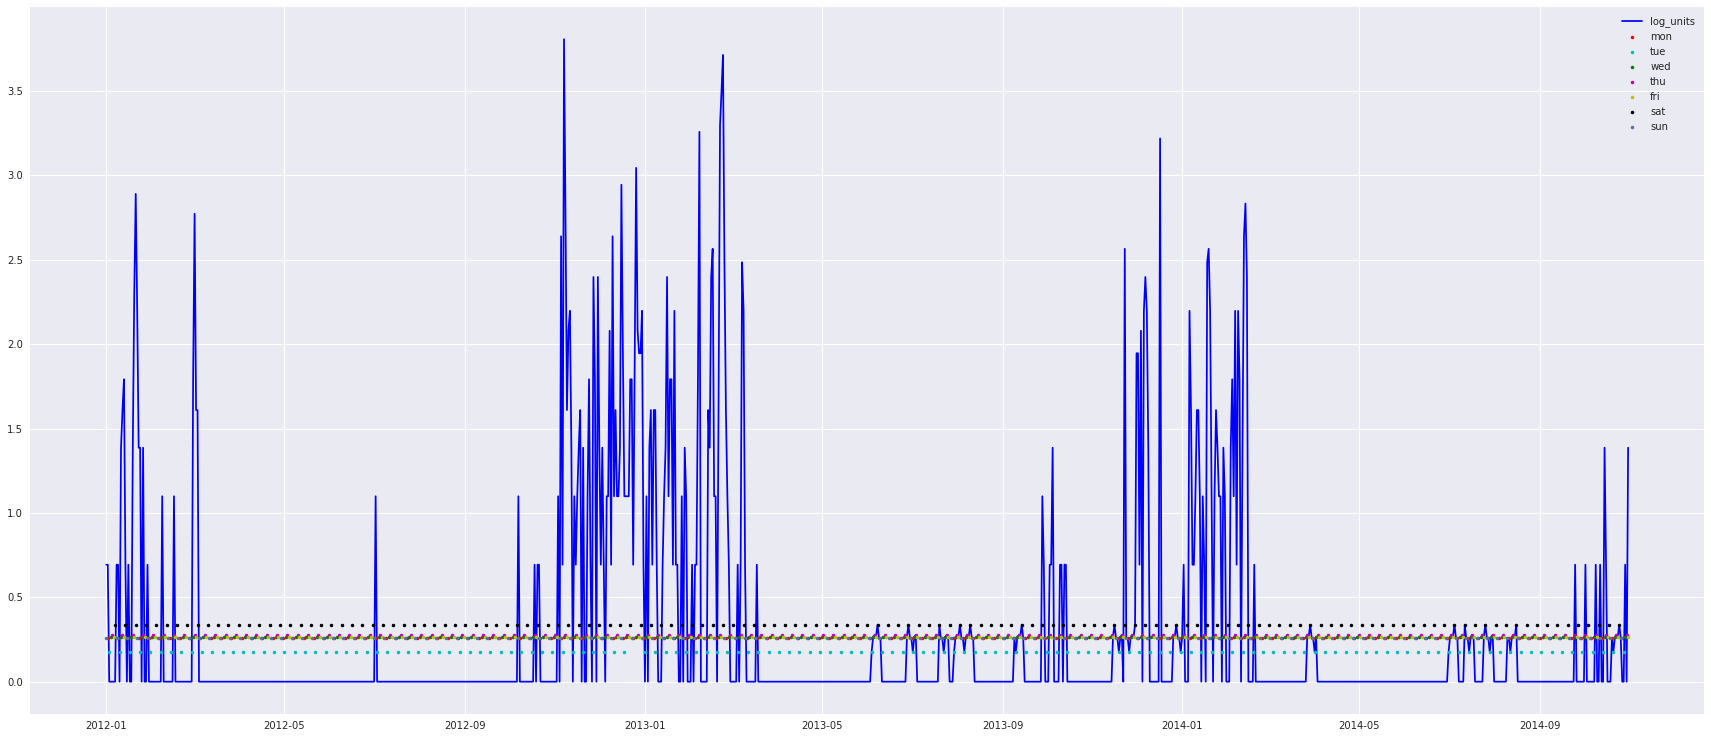

In [168]:
plt.figure(figsize=(30,13))
plt.plot(new['date'], new['log_units'])
plt.plot(mon['date'], mon['mean_per_weekday'], 'r.', label='mon')
plt.plot(tue['date'], tue['mean_per_weekday'], 'c.', label='tue')
plt.plot(wed['date'], wed['mean_per_weekday'], 'g.', label='wed')
plt.plot(thu['date'], thu['mean_per_weekday'], 'm.', label='thu') 
plt.plot(fri['date'], fri['mean_per_weekday'], 'y.', label='fri') 
plt.plot(sat['date'], sat['mean_per_weekday'], 'k.', label='sat')
plt.plot(sun['date'], sun['mean_per_weekday'], 'b.', label='sun')
plt.legend()
plt.show()

## Result

<img src = '../sub_test11.png'>

<img src = '../sub_test11_rank.png'>

## Outlier 대체 후

<img src = '../outlier.png'>